# Data Analysis - Why is the ````pidTest.pb```` slower for the TPU?

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit

In [3]:
tdp_tpu = 2 # watts
tdp_vpu = 1.5 # watts
tdp_cpu = 15 # watts 

To investigate, we first need to find out if the data transfer is the limiting factor.

## 1. Bottleneck Analysis

I measured the time needed to set the input tensors and the obtain the output tensors in order to find out if the USB 3.1 connection that we have is a bottleneck or not.

### For ````angleTest.pb```` and ````pidTest.pb````

Below are the times needed to send the images through the USB.

In [4]:
images_bottlenecks = {'tpu': [pd.read_csv("bottleneck_test/output_files_tpu/pidTest_inputbottleneck/pidTest_inputbottleneck.csv")['latency_tpu_mean'][0],
                              pd.read_csv("bottleneck_test/output_files_tpu/angleTest_inputbottleneck/angleTest_inputbottleneck.csv")['latency_tpu_mean'][0]],
                     'vpu': [pd.read_csv("bottleneck_test/output_files_vpu/pidTest_inputbottleneck/pidTest_inputbottleneck.csv")['latency_vpu_mean'][0],
                              pd.read_csv("bottleneck_test/output_files_vpu/angleTest_inputbottleneck/angleTest_inputbottleneck.csv")['latency_vpu_mean'][0]]}

images_bottlenecks

{'tpu': [1.265249252319336e-05, 1.1337208747863769e-05],
 'vpu': [1.644284725189209e-05, 1.6059017181396483e-05]}

In [7]:
np.array(images_bottlenecks['tpu']).mean(), np.array(images_bottlenecks['tpu']).std()

(1.1994850635528565e-05, 6.576418876647958e-07)

And then below are the times needed to retrieve the outputs (either angles or PID information) through the USB.

In [4]:
angle_bottlenecks = {'tpu': pd.read_csv("bottleneck_test/output_files_tpu/angleTest_outputbottleneck/angleTest_outputbottleneck.csv")['latency_tpu_mean'][0],
                     'vpu': pd.read_csv("bottleneck_test/output_files_vpu/angleTest_outputbottleneck/angleTest_outputbottleneck.csv")['latency_vpu_mean'][0]}

angle_bottlenecks

{'tpu': 2.910706996917725e-05, 'vpu': 0.0001951311588287}

In [5]:
pid_bottlenecks = {'tpu': pd.read_csv("bottleneck_test/output_files_tpu/pidTest_outputbottleneck/pidTest_outputbottleneck.csv")['latency_tpu_mean'][0],
                     'vpu': pd.read_csv("bottleneck_test/output_files_vpu/pidTest_outputbottleneck/pidTest_outputbottleneck.csv")['latency_vpu_mean'][0]}

pid_bottlenecks

{'tpu': 1.9166517257690428e-05, 'vpu': 4.557275772094727e-05}

### Bottleneck

We want to know how much of the processing time is spent in transferring the data.

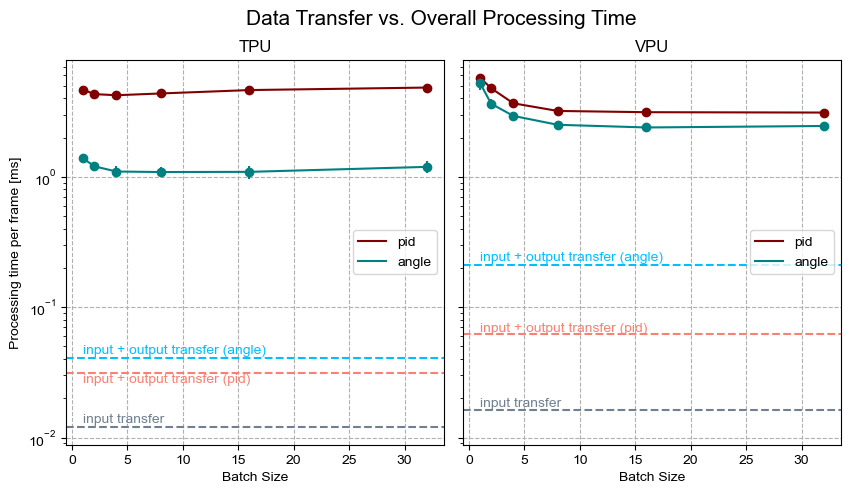

In [6]:
angleTest = {'tpu': pd.read_csv("angle_test/model_py/data_analysis/2023-08-17/tpu_data/edgetpu_B/data.csv"),
           'vpu': pd.read_csv("angle_test/model_py/data_analysis/2023-08-17/vpu_data/vpu_B/data.csv")}


pidTest = {'tpu': pd.read_csv("pid_test/model_py/output_files/evalSession_2023_09_01-13_29/evalSession_2023_09_01-13_29.csv"),
           'vpu': pd.read_csv("pid_test/model_py/output_files/evalSession_2023_10_03-17_20/evalSession_2023_10_03-17_20.csv")}


plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace= 0.05)
fig.suptitle('Data Transfer vs. Overall Processing Time', fontsize=15)

ax[0].set_title('TPU')
ax[0].plot(pidTest['tpu']['batch_size'], pidTest['tpu']['latency_tpu_mean']*1000, color = 'maroon', label='pid')
ax[0].errorbar(pidTest['tpu']['batch_size'], pidTest['tpu']['latency_tpu_mean']*1000, fmt='o', yerr=pidTest['tpu']['latency_tpu_stdev']*1000, color = 'maroon')
ax[0].plot(angleTest['tpu']['batch_size'], angleTest['tpu']['latency_tpu_mean']*1000, color = 'teal', label='angle')
ax[0].errorbar(angleTest['tpu']['batch_size'], angleTest['tpu']['latency_tpu_mean']*1000, fmt='o', yerr=angleTest['tpu']['latency_tpu_stdev']*1000, color = 'teal')
ax[0].axhline(y= np.mean(images_bottlenecks['tpu'])*1000, linestyle='--', color='slategrey')
ax[0].text(x= 1, y= np.mean(images_bottlenecks['tpu'])*1000 + 0.001, s='input transfer', color='slategrey')
ax[0].axhline(y= (pid_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*1000, linestyle='--', color='salmon')
ax[0].text(x= 1, y= (pid_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*1000 - 0.005, s='input + output transfer (pid)', color='salmon')
ax[0].axhline(y= (angle_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*1000, linestyle='--', color='deepskyblue')
ax[0].text(x= 1, y= (angle_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*1000 + 0.003, s='input + output transfer (angle)', color='deepskyblue')
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Processing time per frame [ms]')
ax[0].set_yscale('log')
ax[0].grid(linestyle='--')
ax[0].legend(loc="right")

ax[1].set_title('VPU')
ax[1].plot(pidTest['vpu']['batch_size'], pidTest['vpu']['latency_vpu_mean']*1000, color = 'maroon', label='pid')
ax[1].errorbar(pidTest['vpu']['batch_size'], pidTest['vpu']['latency_vpu_mean']*1000, fmt='o', yerr=pidTest['vpu']['latency_vpu_stdev']*1000, color = 'maroon')
ax[1].plot(angleTest['vpu']['batch_size'], angleTest['vpu']['latency_vpu_mean']*1000, color = 'teal', label='angle')
ax[1].errorbar(angleTest['vpu']['batch_size'], angleTest['vpu']['latency_vpu_mean']*1000, fmt='o', yerr=angleTest['vpu']['latency_vpu_stdev']*1000, color = 'teal')
ax[1].axhline(y= np.mean(images_bottlenecks['vpu'])*1000, linestyle='--', color='slategrey')
ax[1].text(x= 1, y= np.mean(images_bottlenecks['vpu'])*1000 + 0.001, s='input transfer', color='slategrey')
ax[1].axhline(y= (pid_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*1000, linestyle='--', color='salmon')
ax[1].text(x= 1, y= (pid_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*1000 + 0.003, s='input + output transfer (pid)', color='salmon')
ax[1].axhline(y= (angle_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*1000, linestyle='--', color='deepskyblue')
ax[1].text(x= 1, y= (angle_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*1000 + 0.015, s='input + output transfer (angle)', color='deepskyblue')
ax[1].set_xlabel('Batch Size')
ax[1].set_yscale('log')
ax[1].grid(linestyle='--')
ax[1].legend(loc="right")

We evaluate the **percentages of the data transfer time** to the overall processing time.

In [7]:
max_data_transfer_time_perc = pd.DataFrame.from_dict(
    {'tpu': [ (pid_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*100. / max(pidTest['tpu']['latency_tpu_mean']), 
             (angle_bottlenecks['tpu'] + np.mean(images_bottlenecks['tpu']))*100. / max(angleTest['tpu']['latency_tpu_mean'])],
        'vpu':  [ (pid_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*100. / max(pidTest['vpu']['latency_vpu_mean']), 
             (angle_bottlenecks['vpu'] + np.mean(images_bottlenecks['vpu']))*100. / max(angleTest['vpu']['latency_vpu_mean'])]
}, orient='index', columns=['pid', 'angle'])

max_data_transfer_time_perc

,pid,angle
tpu,0.644025,2.959493
vpu,1.075126,4.038208


As we can see, the rates are not mainly due to the data transfer - not a bottleneck.

Since the input/output data transfer is not a bottleneck we can stick to the respective USB modules of each accelerator chip.


## 2. Layer per Layer Analysis

We want to know the performance of each layer.

For the TPU we need to build models cut at different places, since we cannot evaluate layer per layer with the Coral Runtime.

In [3]:
# tpu_opt_idx = pidTest['tpu']['latency_tpu_mean'].idxmin()
tpu_opt_idx = 0
tpu_opt_batch = 2**tpu_opt_idx

tpu_opt_idx, tpu_opt_batch

(0, 1)

In [3]:
output_shapes = {}

pidmodel = tf.keras.models.load_model("pid_test/model_py/model.hf5")

pidmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_yx (InputLayer)       [(None, 16, 32, 1)]          0         []                            
                                                                                                  
 input_yz (InputLayer)       [(None, 16, 32, 1)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 16, 32, 2)            0         ['input_yx[0][0]',            
                                                                     'input_yz[0][0]']            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 32, 64)           192       ['concatenate[0][0]']     

In [67]:
pidmodel_outputshapes = {}

for layer in pidmodel.layers:
    pidmodel_outputshapes[layer.name] = layer.output_shape
    
pidmodel_outputshapes

{'input_yx': [(None, 16, 32, 1)],
 'input_yz': [(None, 16, 32, 1)],
 'concatenate': (None, 16, 32, 2),
 'conv2d': (None, 16, 32, 64),
 'conv2d_1': (None, 16, 32, 64),
 'conv2d_2': (None, 16, 32, 64),
 'conv2d_3': (None, 16, 32, 64),
 'concatenate_1': (None, 16, 32, 256),
 'conv2d_8': (None, 16, 32, 128),
 'max_pooling2d': (None, 14, 30, 128),
 'conv2d_9': (None, 14, 30, 64),
 'conv2d_4': (None, 14, 30, 64),
 'conv2d_5': (None, 14, 30, 64),
 'conv2d_6': (None, 14, 30, 64),
 'conv2d_7': (None, 14, 30, 64),
 'concatenate_2': (None, 14, 30, 256),
 'max_pooling2d_1': (None, 10, 26, 256),
 'conv2d_10': (None, 10, 26, 128),
 'max_pooling2d_2': (None, 6, 22, 128),
 'conv2d_11': (None, 6, 22, 64),
 'max_pooling2d_3': (None, 4, 20, 64),
 'flatten': (None, 5120),
 'dense': (None, 256),
 'dense_1': (None, 128),
 'dropout': (None, 128),
 'dense_2': (None, 26),
 'output_1': (None, 26)}

In [81]:
# we have to subtract the evaluation time of the last layer

anglemodel = tf.keras.models.load_model("angle_test/model_py/model.hf5")

anglemodel_outputshapes = {}

for layer in anglemodel.layers:
    anglemodel_outputshapes[layer.name] = layer.output_shape
    print(layer.output_shape)
    if len(layer.output_shape) == 4:
        print(np.log2(layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3]))
        # print(layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3])
        
    elif len(layer.output_shape) == 2:
        # print(layer.output_shape[1])
        print(np.log2(layer.output_shape[1]))

[(None, 16, 32, 1)]
[(None, 16, 32, 1)]
(None, 16, 32, 512)
18.0
(None, 16, 32, 64)
15.0
(None, 12, 28, 64)
14.39231742277876
(None, 12, 28, 64)
14.39231742277876
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 64)
13.584962500721156
(None, 8, 24, 256)
15.584962500721156
(None, 8, 24, 256)
15.584962500721156
(None, 4, 20, 256)
14.321928094887362
(None, 4, 20, 64)
12.321928094887362
(None, 4, 20, 128)
13.321928094887362
(None, 4, 20, 128)
13.321928094887362
(None, 10240)
13.321928094887362
(None, 10240)
13.321928094887362
(None, 200)
7.643856189774724
(None, 200)
7.643856189774724
(None, 200)
7.643856189774724
(None, 180)
7.491853096329675
(None, 360)
8.491853096329674
(None, 180)
7.491853096329675
(None, 360)
8.491853096329674
(None, 180)
7.491853096329675
(None, 3

In [69]:
# we have to subtract the evaluation time of the last layer
pid_process_times_tpu = [ tpu_data[dir_name]['latency_tpu_mean'][0]*1e3 for dir_name in dir_list]

output_processing_time = []

for i in range(len(tpu_perf['layers_added'])):
    layer_name = tpu_perf['layers_added'][i]
    
    if len(pidmodel_outputshapes[layer_name]) == 4:
        output_size = 1
        for i in np.arange(1,4):
            output_size *= pidmodel_outputshapes[layer_name][i]    
        
    elif len(pidmodel_outputshapes[layer_name]) == 2:
        output_size = pidmodel_outputshapes[layer_name][1]
        
    file_directory_last_layer = "matmul_test/output_files_tpu_pid/matmul_" + str(output_size) + "_26/matmul_" + str(output_size) + "_26.csv"
    
    proc_time_last = pd.read_csv(file_directory_last_layer)['latency_tpu_mean'][0]*1e3
    
    print(layer_name)
    print(np.log2(output_size))
    print(proc_time_last)
    print("\n")
    
    output_processing_time.append(proc_time_last)

    
output_processing_time

concatenate
10.0
0.4400417804718


conv2d
15.0
3.8040065765380002


conv2d_1
15.0
3.8040065765380002


conv2d_2
15.0
3.8040065765380002


conv2d_3
15.0
3.8040065765380002


concatenate_1
17.0
10.6581933498382


conv2d_8
16.0
5.7436118125915


max_pooling2d
15.714245517666123
5.5141553878784


conv2d_9
14.714245517666123
3.8981368541717


conv2d_4
14.714245517666123
3.8981368541717


conv2d_5
14.714245517666123
3.8981368541717


conv2d_6
14.714245517666123
3.8981368541717


conv2d_7
14.714245517666123
3.8981368541717


concatenate_2
16.71424551766612
10.0165073871612


max_pooling2d_1
16.022367813028456
6.8158798217773


conv2d_10
15.022367813028454
4.4987258911132


max_pooling2d_2
14.044394119358454
3.0907697677612


conv2d_11
13.044394119358454
1.614343881607


max_pooling2d_3
12.321928094887362
0.5702345371245999


flatten
12.321928094887362
0.5702345371245999


dense
8.0
0.5049355030059001


dense_1
7.0
0.6453163623809


dropout
7.0
0.6453163623809


dense_2
4.700439718141092
0.404

[0.4400417804718,
 3.8040065765380002,
 3.8040065765380002,
 3.8040065765380002,
 3.8040065765380002,
 10.6581933498382,
 5.7436118125915,
 5.5141553878784,
 3.8981368541717,
 3.8981368541717,
 3.8981368541717,
 3.8981368541717,
 3.8981368541717,
 10.0165073871612,
 6.8158798217773,
 4.4987258911132,
 3.0907697677612,
 1.614343881607,
 0.5702345371245999,
 0.5702345371245999,
 0.5049355030059001,
 0.6453163623809,
 0.6453163623809,
 0.40446758270259997]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


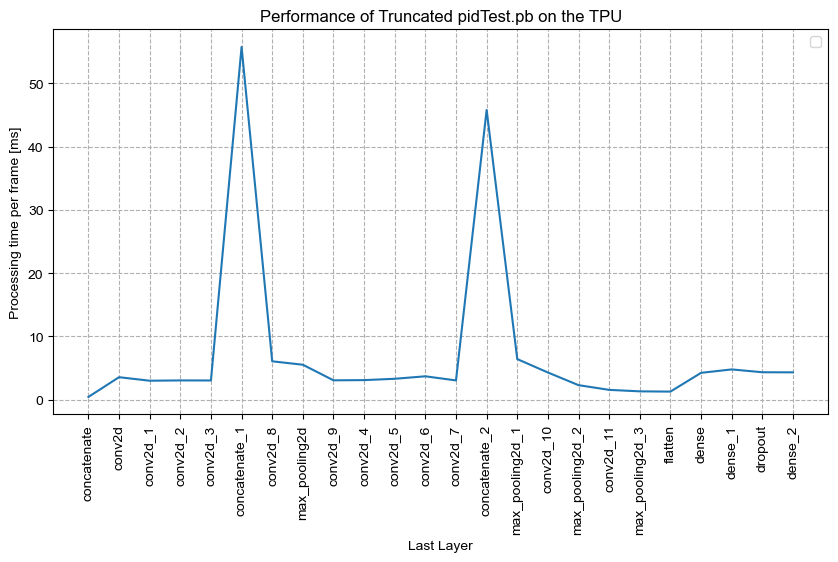

In [184]:
### plot the TPU cumulative graph like the one I did before the holidays
tpu_data = {}

dir_list = sorted(os.listdir("pid_test_buildup/eval/tpu_new/"), key=lambda x: int(os.path.splitext(x)[0].split("_")[1]))

for directory in dir_list:
    tpu_data[directory] = pd.read_csv("pid_test_buildup/eval/tpu_new/" + directory + "/" + directory + ".csv")

tpu_perf = {'model_depth': [dir_name.split("_")[1] for dir_name in dir_list ],
            'layers_added': ["_".join(dir_name.split("_")[2:]) for dir_name in dir_list]}

plt.figure(figsize=(10,5))
plt.title("Performance of Truncated pidTest.pb on the TPU")
plt.plot(tpu_perf['layers_added'], [ tpu_data[dir_name]['latency_tpu_mean'][0]*1e3 for dir_name in dir_list])
# plt.plot(tpu_perf['layers_added'], np.array([ tpu_data[dir_name]['latency_tpu_mean'][0]*1e3 for dir_name in dir_list]) -  np.array(output_processing_time))
plt.xlabel("Last Layer")
plt.ylabel("Processing time per frame [ms]")
plt.xticks(rotation = 90)
plt.grid(linestyle='--')
plt.legend(loc='upper right')

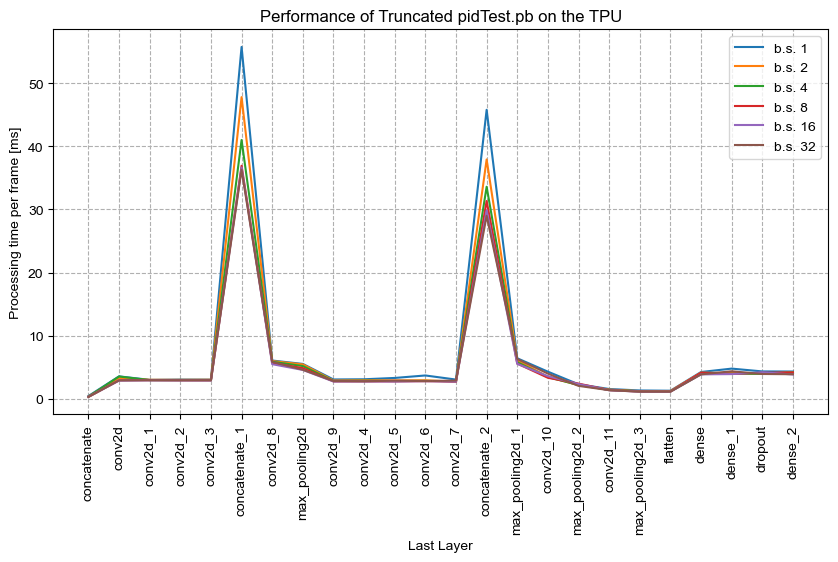

In [64]:
### plot the TPU cumulative graph like the one I did before the holidays
tpu_data = {}

dir_list = sorted(os.listdir("pid_test_buildup/eval/tpu_new/"), key=lambda x: int(os.path.splitext(x)[0].split("_")[1]))

for directory in dir_list:
    tpu_data[directory] = pd.read_csv("pid_test_buildup/eval/tpu_new/" + directory + "/" + directory + ".csv")

tpu_perf = {'model_depth': [dir_name.split("_")[1] for dir_name in dir_list ],
            'layers_added': ["_".join(dir_name.split("_")[2:]) for dir_name in dir_list]}

plt.figure(figsize=(10,5))
plt.title("Performance of Truncated pidTest.pb on the TPU")
for idx in range(6):
    plt.plot(tpu_perf['layers_added'], [ tpu_data[dir_name]['latency_tpu_mean'][idx]*1e3 for dir_name in dir_list], label='b.s. ' + str(2**idx))
plt.xlabel("Last Layer")
plt.ylabel("Processing time per frame [ms]")
plt.xticks(rotation = 90)
plt.grid(linestyle='--')
plt.legend(loc='upper right')

*?????????*

For the VPU it is easier to get the layer per layer performance. OpenVINO can supply this information.

In [ ]:
vpu_layer_perf = pd.read_csv("pid_test/model_py/output_files/evalSession_2023_10_03-17_20/evalSession_2023_10_03-17_20_layer_perf.csv")

vpu_layer_perf

In [ ]:
get_vpu_layer_perf('dense')

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')

def get_vpu_layer_perf(layer, batch_idx):
    keys = []
    for key in vpu_layer_perf.keys():
        if key.split("-")[0] == "vpu" and key.split("-")[2] == "mean":
            if layer in key.split("-")[1].split(",")[0].split("/"):
                keys.append(key)
          
    return np.sum(np.array([ vpu_layer_perf[key][batch_idx] for key in keys ]))

vpu_perf = {'model_depth': tpu_perf['model_depth'],
            'layers': tpu_perf['layers_added']}

plt.figure(figsize=(10,5))
plt.title("Performance of pidTest.pb layers on the VPU")
for idx in range(6):
    plt.plot(vpu_perf['layers'], [ get_vpu_layer_perf(layer, idx)/(2**idx) for layer in tpu_perf['layers_added'] ], 
             label='b.s. ' + str(2**idx), color=cmap(np.linspace(0,0.8,6)[idx]), alpha=(1-idx*1/6*0.75))
plt.xlabel("Layer")
plt.ylabel("Processing time per frame [ms]")
plt.xticks(rotation=90)
plt.grid(linestyle='--')
plt.legend(loc='upper right')

If we still don't know the cause we need to find out the analysis of matrix multiplication (the Dense Layer)

## 2. Matrix Multiplication Analysis

In [3]:
matmul_bottlenecks = {'tpu': [ pd.read_csv("bottleneck_test/output_files_tpu/matmul_" + str(i) + "_1/matmul_" + str(i) + "_1.csv")['latency_tpu_mean'][0] for i in [2**j for j in range(14)] ],
                     'vpu': [ pd.read_csv("bottleneck_test/output_files_vpu/matmul_" + str(i) + "_1/matmul_" + str(i) + "_1.csv")['latency_vpu_mean'][0] for i in [2**j for j in range(14)] ]}

matmul_bottlenecks

{'tpu': [8.464479446411133e-06,
  8.506393432617187e-06,
  1.0028982162475586e-05,
  1.1336803436279298e-05,
  9.469962120056156e-06,
  8.353376388549805e-06,
  6.243109703063965e-06,
  9.240889549255372e-06,
  9.577393531799316e-06,
  1.1687731742858887e-05,
  7.819676399230958e-06,
  9.218335151672364e-06,
  7.30125904083252e-06,
  6.194639205932617e-06],
 'vpu': [9.848499298095703e-06,
  1.4062261581420895e-05,
  1.4056301116943358e-05,
  1.038498878479004e-05,
  1.2500786781311036e-05,
  7.81128406524658e-06,
  1.2358570098876951e-05,
  8.890032768249512e-06,
  9.377932548522947e-06,
  1.0875821113586426e-05,
  1.1372613906860352e-05,
  1.0376739501953124e-05,
  9.745049476623537e-06,
  1.194002628326416e-05]}

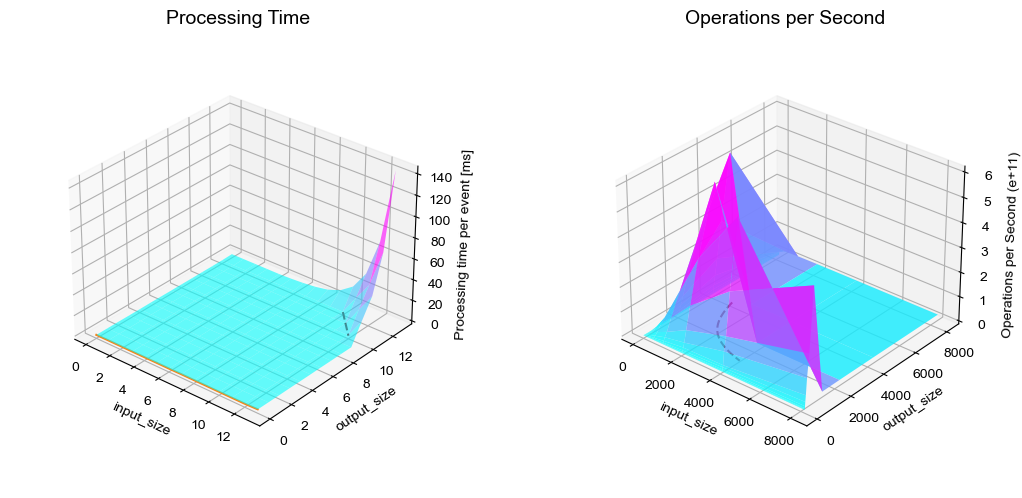

In [4]:
# importing the matrix multiplication data

max_size_idx = 14
matmul_data = {}
flops = {}
input_sizes = [2**i for i in range(max_size_idx)]
output_sizes = [2**j for j in range(max_size_idx)]
flops_mean = []

for i in input_sizes:
    for j in output_sizes:
        matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.read_csv("matmul_test/output_files_tpu_2/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv")
        flops[ "matmul_" + str(i) + "_" + str(j) ] = ( matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_tpu_mean'][0], matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_tpu_stdev'][0])
    flops_mean.append([flops[ "matmul_" + str(i) + "_" + str(j) ][0] for j in [2**k for k in range(max_size_idx)] ])    
        
flops_mean = np.array(flops_mean)

processing_time = np.array([[matmul_data["matmul_" + str(i) + "_" + str(j)]['latency_tpu_mean'][0] for j in output_sizes] for i in input_sizes])

flops = np.array([[ ((2**i)*8*(2**j)*8)/processing_time[i,j] for j in range(max_size_idx)] for i in range(max_size_idx)])

# input width data
input_width_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_tpu_width/matmul_" + str(2**i) + "_1/matmul_" + str(2**i) + "_1.csv")['latency_tpu_mean'][0]*1e3 for i in range(18)]]

# output height data
output_height_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_tpu_height/matmul_1_" + str(2**i) + "/matmul_1_" + str(2**i) + ".csv")['latency_tpu_mean'][0]*1e3 for i in range(18)]]


# Convert input_sizes and output_sizes to 2D arrays
input_sizes_mesh, output_sizes_mesh = np.meshgrid(input_sizes, output_sizes)

plt.rcParams.update({'font.sans-serif':'Arial'})

fig = plt.figure(figsize=(20, 60))

ax = fig.add_subplot(1,3,2, projection='3d')
 
ax.plot_surface(input_sizes_mesh, output_sizes_mesh, flops, cmap='cool', alpha=0.8)
ax.plot(np.linspace(1024,4096,100), 1024*4096/np.linspace(1024,4096,100), linestyle='--', color='maroon')

ax.set_title('Operations per Second', fontsize=14)
ax.set_xlabel('input_size', fontsize=10)
# ax.set_xscale('log')
ax.set_ylabel('output_size', fontsize=10)
# ax.set_yscale('log')
ax.set_zlabel('Operations per Second (e+11)', fontsize=10)
ax.set_box_aspect(aspect=None, zoom=0.83)
ax.view_init(30, 310)

ax2 = fig.add_subplot(1,3,1, projection='3d')
 
ax2.plot_surface(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), processing_time*1e3, cmap='cool', alpha=0.6)
ax2.plot(np.log2(np.linspace(1024,4096,100)), np.log2(1024*4096/np.linspace(1024,4096,100)), linestyle='--', color='maroon')
ax2.text(x=2500, y=2048, z=0, s="input_size*\noutput_size \n= 4194304", color='maroon')
#ax2.plot(input_width_data[0][:14], input_width_data[1][:14], zdir='y')
ax2.plot(np.log2(input_width_data[0][:max_size_idx]), input_width_data[1][:max_size_idx], zdir='y')
# ax2.contour(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, zdir='z', offset=40, cmap='cool')
# ax2.set_xticks(input_sizes)
# ax2.set_yticks(output_sizes)
ax2.set_box_aspect(aspect=None, zoom=0.83)
ax2.set_title('Processing Time', fontsize=14)
ax2.set_xlabel('input_size', fontsize=10)
ax2.set_ylabel('output_size', fontsize=10)
ax2.set_zlabel('Processing time per event [ms]', fontsize=10)
ax2.view_init(30, 310)

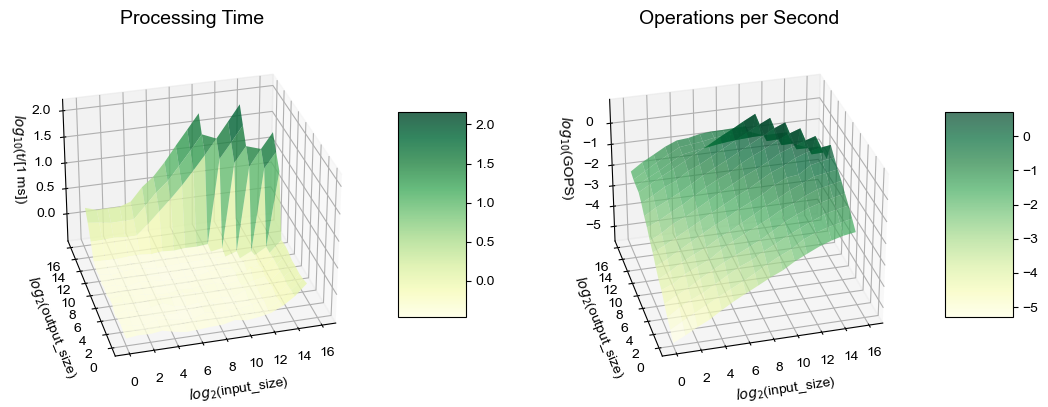

In [5]:
# importing the matrix multiplication data

max_size_idx = 17
matmul_data = {}
flops = {}
input_sizes = [2**i for i in range(max_size_idx)]
output_sizes = [2**j for j in range(max_size_idx)]
flops_mean = []

for i in input_sizes:
    for j in output_sizes:
        if os.path.isfile("matmul_test/output_files_tpu_2/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv"):
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.read_csv("matmul_test/output_files_tpu_2/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv")
            flops[ "matmul_" + str(i) + "_" + str(j) ] = ( matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_tpu_mean'][0], matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_tpu_stdev'][0])
        else:
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.DataFrame({'latency_tpu_mean': [np.nan], 'flops_tpu_mean': [np.nan], 'flops_tpu_stdev': [np.nan]})
            flops[ "matmul_" + str(i) + "_" + str(j) ]  = ( np.nan, np.nan )
    flops_mean.append([flops[ "matmul_" + str(i) + "_" + str(j) ][0] for j in [2**k for k in range(max_size_idx)] ])    
        
flops_mean = np.array(flops_mean)

processing_time = np.array([[matmul_data["matmul_" + str(i) + "_" + str(j)]['latency_tpu_mean'][0] for j in output_sizes] for i in input_sizes])

flops = np.array([[ ((2**i)*(2**j))/processing_time[i,j] for j in range(max_size_idx)] for i in range(max_size_idx)])

# input width data
input_width_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_tpu_width/matmul_" + str(2**i) + "_1/matmul_" + str(2**i) + "_1.csv")['latency_tpu_mean'][0]*1e3 for i in range(18)]]

# output height data
output_height_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_tpu_height/matmul_1_" + str(2**i) + "/matmul_1_" + str(2**i) + ".csv")['latency_tpu_mean'][0]*1e3 for i in range(18)]]


# Convert input_sizes and output_sizes to 2D arrays
input_sizes_mesh, output_sizes_mesh = np.meshgrid(input_sizes, output_sizes)

plt.rcParams.update({'font.sans-serif':'Arial'})

fig = plt.figure(figsize=(20, 60))

ax = fig.add_subplot(1,3,2, projection='3d')
 
ops_surface = ax.plot_surface(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(flops/1e9), cmap='YlGn', alpha=0.7)
# ax.plot(np.linspace(1024,4096,100), 1024*4096/np.linspace(1024,4096,100), linestyle='--', color='maroon')

ax.set_title('Operations per Second', fontsize=14)
ax.set_xlabel(r'$log_2$(input_size)', fontsize=10)
# ax.set_xscale('log')
ax.set_ylabel(r'$log_2$(output_size)', fontsize=10)
# ax.set_yscale('log')
ax.set_zlabel(r'$log_{10}$(GOPS)', fontsize=10)
ax.set_box_aspect(aspect=None, zoom=0.95)
ax.view_init(30, 255)

ax.set_xticks(np.log2(input_sizes[::2]))
ax.set_yticks(np.log2(output_sizes[::2]))

fig.colorbar(ops_surface, shrink=0.5, aspect=3)

ax2 = fig.add_subplot(1,3,1, projection='3d')
 
proc_time_surface = ax2.plot_surface(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(processing_time*1e3), cmap='YlGn', alpha=0.8)
# ax2.plot(np.linspace(10,14,100), 24 - np.linspace(10,14,100), zs=-0.5, linestyle='--', color='blue')
# ax2.plot(np.linspace(0,10,100), [14 for i in np.linspace(0,10,100)], zs=-0.5, linestyle='--', color='tomato')
# ax2.plot([14 for i in np.linspace(0,10,100)], np.linspace(0,10,100), zs=-0.5, linestyle='--', color='tomato')
# ax2.plot(np.log2(np.linspace(32,4096,100)), np.log2(1024*4096/np.linspace(32,4096,100)), linestyle='--', color='maroon')
# ax2.text(x=2500, y=2048, z=0, s="input_size*\noutput_size \n= 4194304", color='maroon')
# ax2.plot(np.log2(input_width_data[0][:17]), np.log10(input_width_data[1][:17]), zdir='y')
# ax2.plot(np.log2(input_width_data[0][:max_size_idx]), input_width_data[1][:max_size_idx], zdir='y')
# ax2.contour(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, zdir='z', offset=40, cmap='cool')
# ax2.set_xticks(input_sizes)
# ax2.set_yticks(output_sizes)
ax2.set_box_aspect(aspect=None, zoom=0.95)
ax2.set_title('Processing Time', fontsize=14)
ax2.set_xlabel(r'$log_2$(input_size)', fontsize=10)
ax2.set_ylabel(r'$log_2$(output_size)', fontsize=10)
ax2.set_zlabel(r'$log_{10}$(t/[1 ms])', fontsize=10)
ax2.set_xticks(np.log2(input_sizes[::2]))
ax2.set_yticks(np.log2(output_sizes[::2]))
ax2.view_init(30, 255)
fig.colorbar(proc_time_surface, shrink=0.5, aspect=3)

fig.savefig("graphs/matmul_3d_tpu.pdf", bbox_inches='tight')

In [6]:
processing_time*1e3

array([[  0.39449382,   0.41993046,   0.41004825,   0.43937778,
          0.38487434,   0.35514903,   0.36464906,   0.3799603 ,
          0.38650227,   0.43809438,   0.40023732,   0.42717147,
          0.47226667,   0.59992766,   0.84937453,   1.3909564 ,
                 nan],
       [  0.39002538,   0.37999821,   0.37493587,   0.37522149,
          0.36969876,   0.38514709,   0.40993333,   0.39995766,
          0.37497306,   0.3800776 ,   0.42548132,   0.3599987 ,
          0.42464185,   0.56970096,   0.83998299,   1.27613068,
                 nan],
       [  0.41485095,   0.35041451,   0.34494615,   0.38973594,
          0.36991644,   0.34504747,   0.32986712,   0.39453816,
          0.36499548,   0.38498712,   0.3852241 ,   0.420017  ,
          0.46867657,   0.54508352,   0.79693604,   1.21906924,
                 nan],
       [  0.3899641 ,   0.38014102,   0.39508343,   0.34995317,
          0.33497453,   0.33478498,   0.36497593,   0.39691687,
          0.4196434 ,   0.39473891,

In [7]:
flops

array([[2.53489397e+03, 4.76269335e+03, 9.75494966e+03, 1.82075660e+04,
        4.15720098e+04, 9.01030194e+04, 1.75511217e+05, 3.36877301e+05,
        6.62350580e+05, 1.16869795e+06, 2.55848204e+06, 4.79432769e+06,
        8.67306593e+06, 1.36549796e+07, 1.92894882e+07, 2.35578915e+07,
                   nan],
       [5.12787146e+03, 1.05263655e+04, 2.13369825e+04, 4.26414808e+04,
        8.65569572e+04, 1.66170279e+05, 3.12245897e+05, 6.40067756e+05,
        1.36543143e+06, 2.69418666e+06, 4.81337231e+06, 1.13778188e+07,
        1.92915513e+07, 2.87589477e+07, 3.90103139e+07, 5.13552422e+07,
                   nan],
       [9.64201721e+03, 2.28301045e+04, 4.63840521e+04, 8.21068753e+04,
        1.73012046e+05, 3.70963446e+05, 7.76070063e+05, 1.29771983e+06,
        2.80551420e+06, 5.31965854e+06, 1.06327718e+07, 1.95039723e+07,
        3.49580097e+07, 6.01155578e+07, 8.22349563e+07, 1.07518093e+08,
                   nan],
       [2.05147087e+04, 4.20896435e+04, 8.09955513e+04, 1.828

In [8]:
np.nanmin(flops)/1e3, np.nanmax(flops)/1e9

(2.534893967039618, 9.532368390508582)

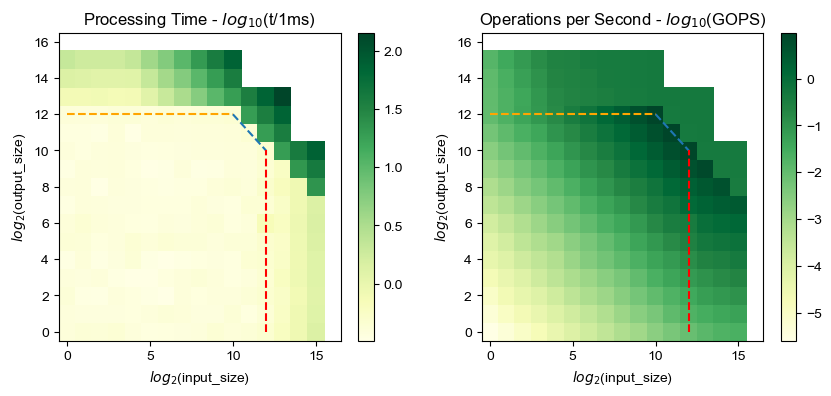

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title(r'Processing Time - $log_{10}$(t/1ms)')
heatmap_proctime = ax[0].pcolor(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(processing_time*1e3), cmap='YlGn')
ax[0].set_xlabel(r'$log_2$(input_size)')
ax[0].set_ylabel(r'$log_2$(output_size)')
ax[0].plot(np.linspace(10,12,100), 22 - np.linspace(10,12,100), linestyle='--')
ax[0].plot(np.linspace(0,10,100), [12 for i in np.linspace(0,10,100)], color='orange', linestyle='--')
ax[0].plot([12 for i in np.linspace(0,10,100)], np.linspace(0,10,100), color='red', linestyle='--')
fig.colorbar(heatmap_proctime)

# for i in range(len(input_sizes_mesh)):
#     for j in range(len(output_sizes_mesh)):
#          if str(processing_time[i,j]) != "nan":
#              ax[0].text(np.log2(input_sizes_mesh[i, j]), np.log2(output_sizes_mesh[i, j]), f'{np.log10(processing_time[i, j]*1e3):.2g}', color='black', ha='center', va='center')


ax[1].set_title(r'Operations per Second - $log_{10}$(GOPS)')
heatmap_ops = ax[1].pcolor(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(flops/1e9), cmap='YlGn')
ax[1].set_xlabel(r'$log_2$(input_size)')
ax[1].set_ylabel(r'$log_2$(output_size)')
ax[1].plot(np.linspace(10,12,100), 22 - np.linspace(10,12,100), linestyle='--')
ax[1].plot(np.linspace(0,10,100), [12 for i in np.linspace(0,10,100)], color='orange', linestyle='--')
ax[1].plot([12 for i in np.linspace(0,10,100)], np.linspace(0,10,100), color='red', linestyle='--')
fig.colorbar(heatmap_ops)

# for i in range(len(input_sizes_mesh)):
#    for j in range(len(output_sizes_mesh)):
#        if str(processing_time[i,j]) != "nan":
#            ax[1].text(np.log2(input_sizes_mesh[i, j]), np.log2(output_sizes_mesh[i, j]), f'{flops[i, j]:.2g}', color='black', ha='center', va='center')

fig.savefig("graphs/matmul_htmp_tpu.pdf", bbox_inches='tight')

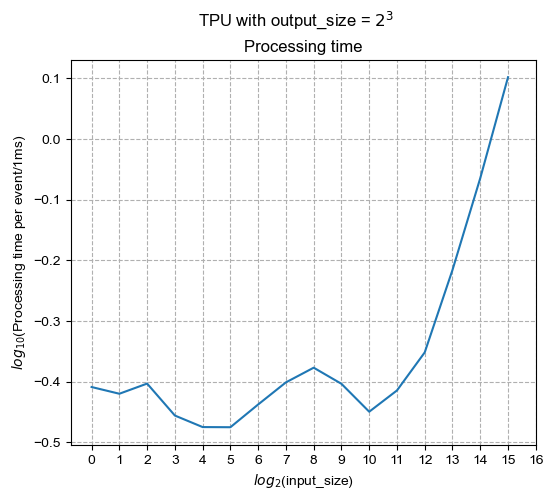

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
fig.suptitle(r'TPU with output_size = $2^{3}$')
ax.set_title("Processing time")
ax.set_xlabel(r'$log_{2}$(input_size)')
ax.set_ylabel(r'$log_{10}$(Processing time per event/1ms)')
# ax[0].plot(np.log2(input_width_data[0]), input_width_data[0])
ax.plot(np.log2(input_sizes_mesh[3,:]), np.log10(processing_time[3,:]*1e3))
ax.set_xticks(np.arange(0,len(np.log2(output_sizes_mesh[:,3]))))
ax.grid(linestyle="--")

In [79]:
flops[:,12]

array([8.67306593e+06, 1.92915513e+07, 3.49580097e+07, 7.36788360e+07,
       1.40984791e+08, 2.70314990e+08, 3.78386733e+08, 1.20434175e+09,
       2.07651607e+09, 4.70918722e+09, 8.92825803e+09, 4.37060219e+08,
       4.55728860e+08, 4.62108759e+08,            nan,            nan,
                  nan])

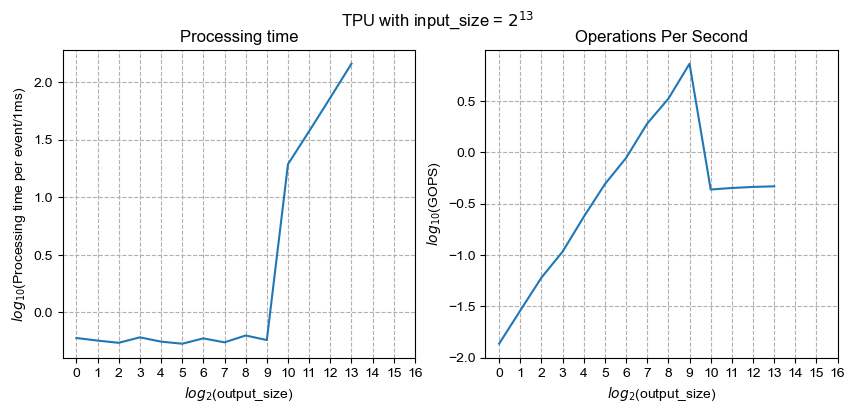

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(r'TPU with input_size = $2^{13}$')
ax[0].set_title("Processing time")
ax[0].set_xlabel(r'$log_{2}$(output_size)')
ax[0].set_ylabel(r'$log_{10}$(Processing time per event/1ms)')
# ax[0].plot(np.log2(input_width_data[0]), input_width_data[0])
ax[0].plot(np.log2(input_sizes_mesh[13,:]), np.log10(processing_time[:,13]*1e3))
ax[0].set_xticks(np.arange(0,len(np.log2(output_sizes_mesh[13,:]))))
ax[0].grid(linestyle="--")
ax[1].set_title("Operations Per Second")
ax[1].set_xlabel(r'$log_{2}$(output_size)')
ax[1].set_ylabel(r'$log_{10}$(GOPS)')
ax[1].plot(np.log2(input_sizes_mesh[13,:]), np.log10(flops[:,13]/1e9))
ax[1].set_xticks(np.arange(0,len(np.log2(input_sizes_mesh[13,:]))))
ax[1].grid(linestyle="--")

fig.savefig("graphs/matmul_input2p13_tpu.pdf", bbox_inches="tight", pad_inches=0)

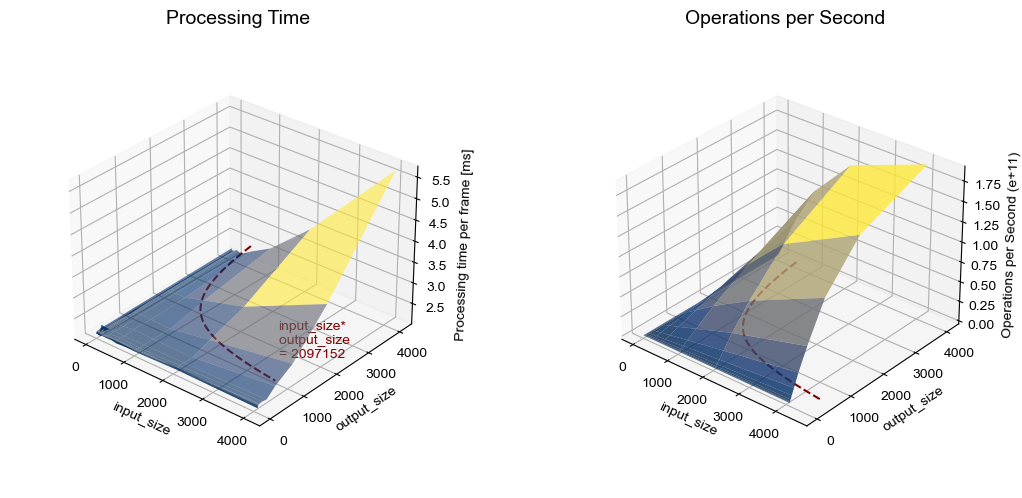

In [81]:
# importing the matrix multiplication data

max_size_idx = 13
matmul_data = {}
flops = {}
input_sizes = [2**i for i in range(max_size_idx)]
output_sizes = [2**j for j in range(max_size_idx)]
flops_mean = []

for i in input_sizes:
    for j in output_sizes:
        if os.path.isfile("matmul_test/output_files_vpu/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv"):
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.read_csv("matmul_test/output_files_vpu/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv")
            flops[ "matmul_" + str(i) + "_" + str(j) ] = ( matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_vpu_mean'][0], matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_vpu_stdev'][0])
        else:
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.DataFrame({'latency_vpu_mean': [np.nan], 'flops_vpu_mean': [np.nan], 'flops_vpu_stdev': [np.nan]})
            flops[ "matmul_" + str(i) + "_" + str(j) ]  = ( np.nan, np.nan )
    flops_mean.append([flops[ "matmul_" + str(i) + "_" + str(j) ][0] for j in [2**k for k in range(max_size_idx)] ])    
        
flops_mean = np.array(flops_mean)
processing_time = np.array([[matmul_data["matmul_" + str(i) + "_" + str(j)]['latency_vpu_mean'][0] for j in output_sizes] for i in input_sizes])

flops = np.array([[ ((2**i)*8*(2**j)*8)/processing_time[i,j] for j in range(max_size_idx)] for i in range(max_size_idx)])

# input width data
input_width_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_vpu_width/matmul_" + str(2**i) + "_1/matmul_" + str(2**i) + "_1.csv")['latency_vpu_mean'][0]*1e3 for i in range(18)]]

# output height data
output_height_data = [[2**i for i in range(16)], [ pd.read_csv("matmul_test/output_files_vpu_height/matmul_1_" + str(2**i) + "/matmul_1_" + str(2**i) + ".csv")['latency_vpu_mean'][0]*1e3 for i in range(16)]]

# Convert input_sizes and output_sizes to 2D arrays
input_sizes_mesh, output_sizes_mesh = np.meshgrid(input_sizes, output_sizes)

plt.rcParams.update({'font.sans-serif':'Arial'})

fig = plt.figure(figsize=(20, 60))

ax = fig.add_subplot(1,3,2, projection='3d')
 
ax.plot_surface(input_sizes_mesh, output_sizes_mesh, flops, cmap='cividis', alpha=0.8)
ax.plot(np.linspace(512,4500,100), 1024*2048/np.linspace(512,4500,100), zs=2.5, linestyle='--', color='maroon')

ax.set_title('Operations per Second', fontsize=14)
ax.set_xlabel('input_size', fontsize=10)
# ax.set_xscale('log')
ax.set_ylabel('output_size', fontsize=10)
# ax.set_yscale('log')
ax.set_zlabel('Operations per Second (e+11)', fontsize=10)
ax.set_box_aspect(aspect=None, zoom=0.83)
ax.view_init(30, 310)

ax2 = fig.add_subplot(1,3,1, projection='3d')
 
ax2.plot_surface(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, cmap='cividis', alpha=0.6)
ax2.plot(np.linspace(512,2**(max_size_idx-1),100), 1024*2048/np.linspace(512,2**(max_size_idx-1),100), zs=2.5, linestyle='--', color='maroon')
ax2.text(x=4100, y=600, z=3, s="input_size*\noutput_size \n= 2097152", color='maroon')
ax2.contour(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, zdir='z', offset=40, cmap='cool')
ax2.set_box_aspect(aspect=None, zoom=0.83)
ax2.set_title('Processing Time', fontsize=14)
ax2.set_xlabel('input_size', fontsize=10)
ax2.set_ylabel('output_size', fontsize=10)
ax2.set_zlabel('Processing time per frame [ms]', fontsize=10)
ax2.view_init(30, 310)

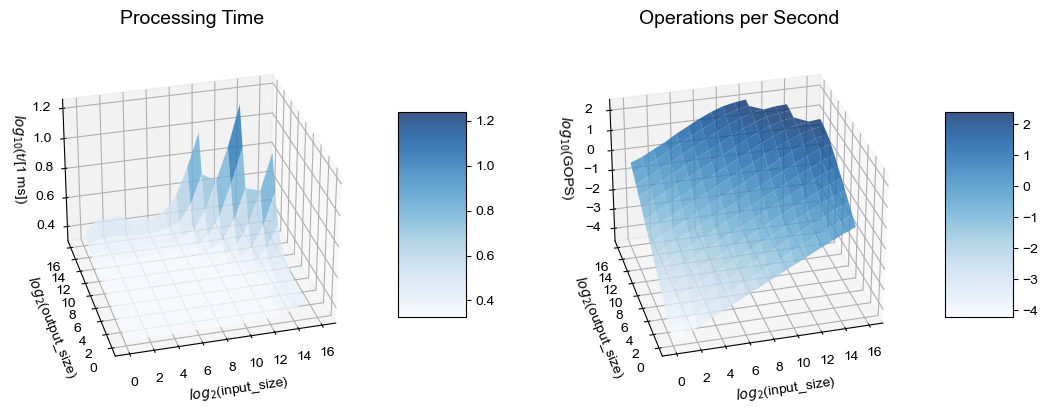

In [26]:
# importing the matrix multiplication data

max_size_idx = 17
matmul_data = {}
flops = {}
input_sizes = [2**i for i in range(max_size_idx)]
output_sizes = [2**j for j in range(max_size_idx)]
flops_mean = []

for i in input_sizes:
    for j in output_sizes:
        if os.path.isfile("matmul_test/output_files_vpu/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv"):
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.read_csv("matmul_test/output_files_vpu/matmul_" + str(i) + "_" + str(j) + "/matmul_" + str(i) + "_" + str(j) + ".csv")
            flops[ "matmul_" + str(i) + "_" + str(j) ] = ( matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_vpu_mean'][0], matmul_data[ "matmul_" + str(i) + "_" + str(j) ]['flops_vpu_stdev'][0])
        else:
            matmul_data[ "matmul_" + str(i) + "_" + str(j) ] = pd.DataFrame({'latency_vpu_mean': [np.nan], 'flops_vpu_mean': [np.nan], 'flops_vpu_stdev': [np.nan]})
            flops[ "matmul_" + str(i) + "_" + str(j) ]  = ( np.nan, np.nan )
    flops_mean.append([flops[ "matmul_" + str(i) + "_" + str(j) ][0] for j in [2**k for k in range(max_size_idx)] ])    
        
flops_mean = np.array(flops_mean)
processing_time = np.array([[matmul_data["matmul_" + str(i) + "_" + str(j)]['latency_vpu_mean'][0] for j in output_sizes] for i in input_sizes])

flops = np.array([[ ((2**i)*8*(2**j)*8)/processing_time[i,j] for j in range(max_size_idx)] for i in range(max_size_idx)])

# input width data
input_width_data = [[2**i for i in range(18)], [ pd.read_csv("matmul_test/output_files_vpu_width/matmul_" + str(2**i) + "_1/matmul_" + str(2**i) + "_1.csv")['latency_vpu_mean'][0]*1e3 for i in range(18)]]

# output height data
output_height_data = [[2**i for i in range(16)], [ pd.read_csv("matmul_test/output_files_vpu_height/matmul_1_" + str(2**i) + "/matmul_1_" + str(2**i) + ".csv")['latency_vpu_mean'][0]*1e3 for i in range(16)]]

# Convert input_sizes and output_sizes to 2D arrays
input_sizes_mesh, output_sizes_mesh = np.meshgrid(input_sizes, output_sizes)

plt.rcParams.update({'font.sans-serif':'Arial'})

fig = plt.figure(figsize=(20, 60))

ax = fig.add_subplot(1,3,2, projection='3d')
 
ops_surface = ax.plot_surface(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(flops/1e9), cmap='Blues', alpha=0.8)
# ax.plot(np.linspace(512,4500,100), 1024*2048/np.linspace(512,4500,100), zs=2.5, linestyle='--', color='maroon')

ax.set_title('Operations per Second', fontsize=14)
ax.set_xlabel(r'$log_2$(input_size)', fontsize=10)
ax.set_ylabel(r'$log_2$(output_size)', fontsize=10)
ax.set_zlabel(r'$log_{10}$(GOPS)', fontsize=10)
ax.set_box_aspect(aspect=None, zoom=0.95)
ax.view_init(30, 255)
ax.set_xticks(np.log2(input_sizes[::2]))
ax.set_yticks(np.log2(output_sizes[::2]))
fig.colorbar(ops_surface, shrink=0.5, aspect=3)


ax2 = fig.add_subplot(1,3,1, projection='3d')

# ax2.plot(np.linspace(10,14,100), 24 - np.linspace(10,14,100), zs=0.4, linestyle='--', color='tomato')
# ax2.plot(np.linspace(0,10,100), [14 for i in np.linspace(0,10,100)], zs=0.4, linestyle='--', color='tomato')
# ax2.plot([14 for i in np.linspace(0,10,100)], np.linspace(0,10,100), zs=0.4, linestyle='--', color='tomato')
proc_time_surface = ax2.plot_surface(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(processing_time*1e3), cmap='Blues', alpha=0.8)

# ax2.plot(np.linspace(512,2**(max_size_idx-1),100), 1024*2048/np.linspace(512,2**(max_size_idx-1),100), zs=2.5, linestyle='--', color='maroon')
# ax2.text(x=4100, y=600, z=3, s="input_size*\noutput_size \n= 2097152", color='maroon')
# ax2.contour(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, zdir='z', offset=40, cmap='cool')
ax2.set_box_aspect(aspect=None, zoom=0.95)
ax2.set_title('Processing Time', fontsize=14)
ax2.set_title('Processing Time', fontsize=14)
ax2.set_xlabel(r'$log_2$(input_size)', fontsize=10)
ax2.set_ylabel(r'$log_2$(output_size)', fontsize=10)
ax2.set_zlabel(r'$log_{10}$(t/[1 ms])', fontsize=10)
ax2.view_init(30, 255)
ax2.set_xticks(np.log2(input_sizes[::2]))
ax2.set_yticks(np.log2(output_sizes[::2]))
fig.colorbar(proc_time_surface, shrink=0.5, aspect=3)
fig.savefig("graphs/matmul_3d_vpu.pdf", bbox_inches='tight')

In [27]:
np.nanmin(flops)/1e3, np.nanmax(flops)/1e9

(29.623971588581387, 247.5852350694762)

In [28]:
processing_time*1e3

array([[ 2.16041255,  2.15181422,  2.15609288,  2.14585233,  2.14785218,
         2.16995764,  2.15664768,  2.13198781,  2.15253043,  2.16186857,
         2.1439693 ,  2.17734361,  2.18747354,  2.26600099,  2.36302137,
         2.67809749,         nan],
       [ 2.15179968,  2.12531257,  2.1097002 ,  2.11462331,  2.12577367,
         2.1288712 ,  2.10610604,  2.12487817,  2.12824225,  2.14136362,
         2.13937402,  2.14480567,  2.11885715,  2.20288014,  2.3857286 ,
         2.61148047,         nan],
       [ 2.14792967,  2.12082863,  2.13558888,  2.13333797,  2.14699674,
         2.14389014,  2.1335156 ,  2.13020372,  2.1207037 ,  2.13337541,
         2.11299348,  2.1422441 ,  2.15960526,  2.21274543,  2.28955603,
         2.62473989,         nan],
       [ 2.17213416,  2.10423088,  2.12815714,  2.13599706,  2.13202953,
         2.11490297,  2.11253238,  2.14125109,  2.14392662,  2.14575386,
         2.1333673 ,  2.14358234,  2.15570116,  2.22025108,  2.32103705,
         2.61007738

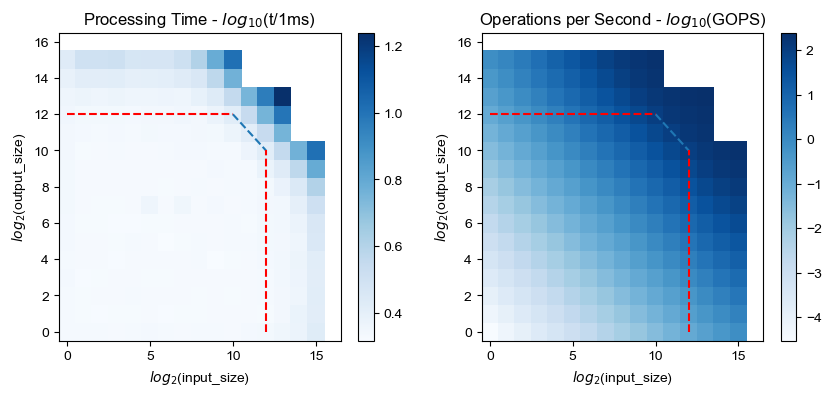

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title(r'Processing Time - $log_{10}$(t/1ms)')
heatmap_proctime = ax[0].pcolor(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(processing_time*1e3), cmap='Blues')
ax[0].set_xlabel(r'$log_2$(input_size)')
ax[0].set_ylabel(r'$log_2$(output_size)')
ax[0].plot(np.linspace(10,12,100), 22 - np.linspace(10,12,100), linestyle='--')
ax[0].plot(np.linspace(0,10,100), [12 for i in np.linspace(0,10,100)], color='red', linestyle='--')
ax[0].plot([12 for i in np.linspace(0,10,100)], np.linspace(0,10,100), color='red', linestyle='--')

# for i in range(len(input_sizes_mesh)):
#    for j in range(len(output_sizes_mesh)):
#        if str(processing_time[i,j]) != "nan":
#            ax[0].text(np.log2(input_sizes_mesh[i, j]), np.log2(output_sizes_mesh[i, j]), f'{processing_time[i, j]*1e3:.2g}', color='black', ha='center', va='center')

fig.colorbar(heatmap_proctime)

ax[1].set_title(r'Operations per Second - $log_{10}$(GOPS)')
heatmap_ops = ax[1].pcolor(np.log2(input_sizes_mesh), np.log2(output_sizes_mesh), np.log10(flops/1e9), cmap='Blues')
ax[1].set_xlabel(r'$log_2$(input_size)')
ax[1].set_ylabel(r'$log_2$(output_size)')
ax[1].plot(np.linspace(10,12,100), 22 - np.linspace(10,12,100), linestyle='--')
ax[1].plot(np.linspace(0,10,100), [12 for i in np.linspace(0,10,100)], color='red', linestyle='--')
ax[1].plot([12 for i in np.linspace(0,10,100)], np.linspace(0,10,100), color='red', linestyle='--')
fig.colorbar(heatmap_ops)

# for i in range(len(input_sizes_mesh)):
#     for j in range(len(output_sizes_mesh)):
#         if str(processing_time[i,j]) != "nan":
#             ax[1].text(np.log2(input_sizes_mesh[i, j]), np.log2(output_sizes_mesh[i, j]), f'{flops[i, j]*1e3:.2g}', color='black', ha='center', va='center')

fig.savefig("graphs/matmul_htmp_vpu.pdf", bbox_inches='tight')

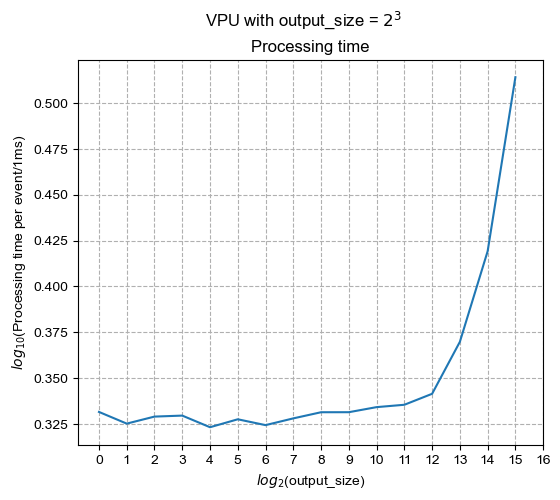

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
fig.suptitle(r'VPU with output_size = $2^{3}$')
ax.set_title("Processing time")
ax.set_xlabel(r'$log_{2}$(output_size)')
ax.set_ylabel(r'$log_{10}$(Processing time per event/1ms)')
# ax[0].plot(np.log2(input_width_data[0]), input_width_data[0])
ax.plot(np.log2((input_sizes_mesh[3,:])), np.log10(processing_time[:,3]*1e3))
ax.set_xticks(np.arange(0,len(np.log2(input_sizes_mesh[3,:]))))
ax.grid(linestyle="--")

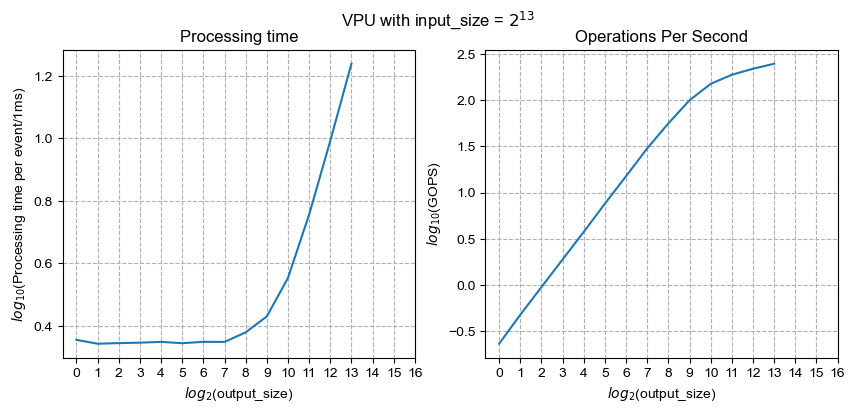

In [86]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle(r'VPU with input_size = $2^{13}$')
ax[0].set_title("Processing time")
ax[0].set_xlabel(r'$log_{2}$(output_size)')
ax[0].set_ylabel(r'$log_{10}$(Processing time per event/1ms)')
# ax[0].plot(np.log2(input_width_data[0]), input_width_data[0])
ax[0].plot(np.log2((input_sizes_mesh[13,:])), np.log10(processing_time[:,13]*1e3))
ax[0].set_xticks(np.arange(0,len(np.log2(input_sizes_mesh[13,:]))))
ax[0].grid(linestyle="--")
ax[1].set_title("Operations Per Second")
ax[1].set_xlabel(r'$log_{2}$(output_size)')
ax[1].set_ylabel(r'$log_{10}$(GOPS)')
ax[1].plot(np.log2(input_sizes_mesh[13,:]), np.log10(flops[:,13]/1e9))
ax[1].set_xticks(np.arange(0,len(np.log2(input_sizes_mesh[13,:]))))
ax[1].grid(linestyle="--")

fig.savefig("graphs/matmul_input2p13_vpu.pdf", bbox_inches="tight", pad_inches=0)

Nicht bei einer bestimmten Breite, sondern einfach bei einer bestimmten Anzahl der Operanden.

In [20]:
get_matmul_processing_time = interp2d(input_sizes, output_sizes, processing_time)

get_matmul_processing_time(26,26)[0]*1e3

C:\Users\Vernando Limodya\AppData\Local\Temp\ipykernel_9692\572732656.py:1: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  get_matmul_processing_time = interp2d(input_sizes, output_sizes, processing_time)
C:\Users\Vernando Limodya\AppData\Local\Temp\ipykernel_9692\572732656.py:3: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on reg

2.1424480937420705

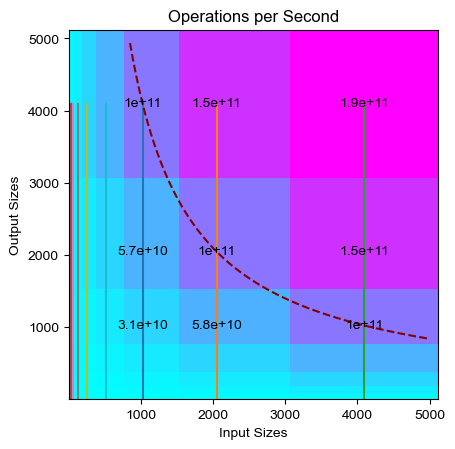

In [21]:
plt.figure()
plt.plot(input_sizes_mesh, output_sizes_mesh)
plt.pcolor(input_sizes_mesh, output_sizes_mesh, flops, cmap='cool')

for i in range(len(input_sizes_mesh)):
    for j in range(len(output_sizes_mesh)):
        if i > 9 and j > 9:
            plt.text(input_sizes_mesh[i, j], output_sizes_mesh[i, j], f'{flops[i, j]:.2g}', color='black', ha='center', va='center')

plt.plot(np.linspace(850,5000,100), 1024*4096/np.linspace(850,5000,100), linestyle='--', color='maroon')
plt.xlabel('Input Sizes')
plt.ylabel('Output Sizes')
plt.title('Operations per Second')
plt.gca().set_aspect('equal')
plt.show()

In [22]:
pid_process_times_tpu = [ tpu_data[dir_name]['latency_tpu_mean'][idx]*1e3 for dir_name in dir_list]

pid_process_time_tpu_wo_output = []

for i in range(len(tpu_perf['layers_added'])):
    layer_name = tpu_perf['layers_added'][i]
    
    if len(pidmodel_outputshapes[layer_name]) == 4:
        input_size = 1
        for i in np.arange(1,4):
            input_size *= pidmodel_outputshapes[layer_name][i]    
        
    elif len(pidmodel_outputshapes[layer_name]) == 2:
        input_size = pidmodel_outputshapes[layer_name][1]
        
    print(input_size)
    
    matmul_time = get_matmul_processing_time(input_size,26)[0]*1e3
    
    print(matmul_time)
    
    # pid_process_time_tpu_wo_output.append( pid_process_time_tpu[i] - matmul_time)
    


1024
2.1409438252448503
32768
2.18827784061425
32768
2.18827784061425
32768
2.18827784061425
32768
2.18827784061425
131072
2.18827784061425
65536
2.18827784061425
53760
2.18827784061425
26880
2.18827784061425
26880
2.18827784061425
26880
2.18827784061425
26880
2.18827784061425
26880
2.18827784061425
107520
2.18827784061425
66560
2.18827784061425
33280
2.18827784061425
16896
2.18827784061425
8448
2.18827784061425
5120
2.18827784061425
5120
2.18827784061425
256
2.1595814228057253
128
2.1231363415717874
128
2.1231363415717874
26
2.1424480937420705


C:\Users\Vernando Limodya\AppData\Local\Temp\ipykernel_9692\3619485927.py:18: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  matmul_time = get_matmul_processing_time(input_size,26)[0]*1e3


In [219]:
get_matmul_processing_time(2048,4096)[0]*1e3

C:\Users\Vernando Limodya\AppData\Local\Temp\ipykernel_12588\1800963583.py:1: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  get_matmul_processing_time(2048,4096)[0]*1e3


19.095014333724897

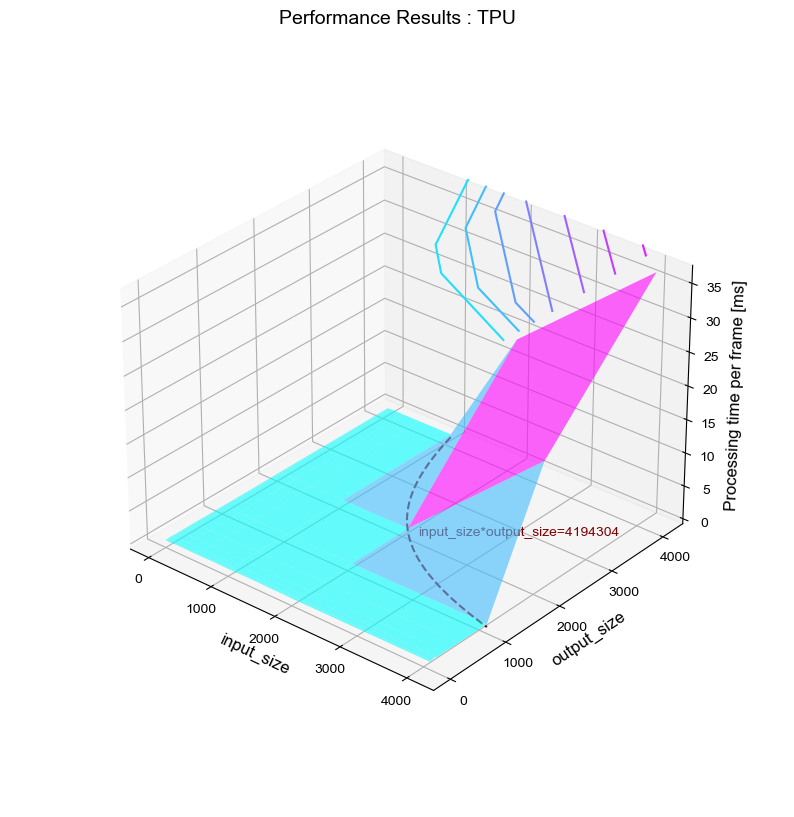

In [254]:
fig = plt.figure(figsize=(10, 15))
ax = plt.axes(projection='3d')
 
ax.plot_surface(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, cmap='cool', alpha=0.6)
ax.plot(np.linspace(1024,4096,100), 1024*4096/np.linspace(1024,4096,100), linestyle='--', color='maroon')
ax.text(x=2200, y=2048, z=0, s=r'input_size*output_size=4194304', color='maroon')
ax.contour(input_sizes_mesh, output_sizes_mesh, processing_time*1e3, zdir='z', offset=40, cmap='cool')
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.set_title('Performance Results : TPU', fontsize=14)
ax.set_xlabel('input_size', fontsize=12)
# ax.set_xscale('log')
ax.set_ylabel('output_size', fontsize=12)
# ax.set_yscale('log')
ax.set_zlabel('Processing time per frame [ms]', fontsize=12)
ax.view_init(30, 310)

C:\Users\Vernando Limodya\AppData\Local\Temp\ipykernel_12588\3361130582.py:2: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  plt.plot(input_sizes, [get_matmul_processing_time(size,2000)[0]*1e3 for size in input_sizes])


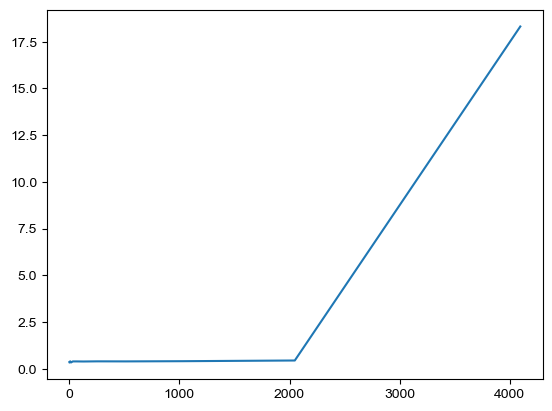

In [228]:
plt.figure()
plt.plot(input_sizes, [get_matmul_processing_time(size,2000)[0]*1e3 for size in input_sizes])
plt.show()

## 3a. Convolution With Different Kernel Sizes

10x10000 data, inputs are 32 x 32 x 1 tensors. Kernel sizes are variable. Kernel sizes are odd because that's what people usually use.

32 filters

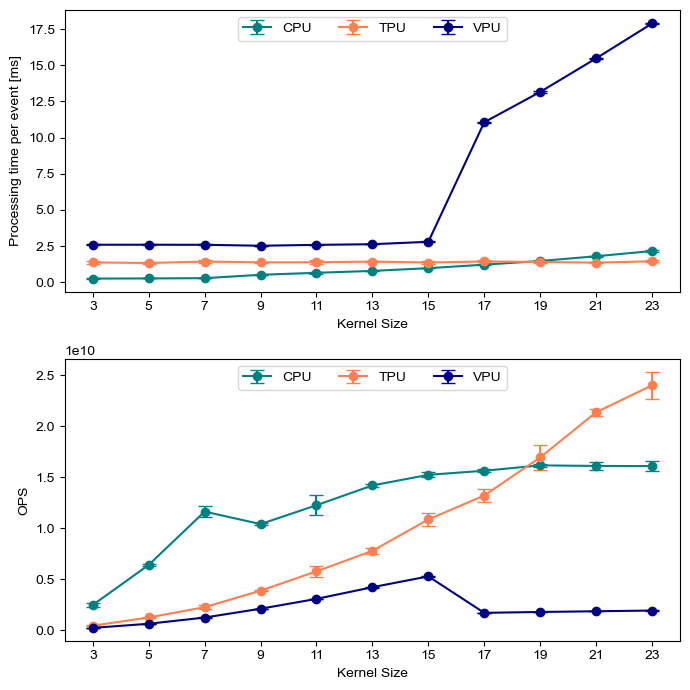

In [4]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv2d_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}


conv2d_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]

conv2d_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}

conv2d_error_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]


fig, ax = plt.subplots(2,1, figsize=(7,7))

x_values = [ str(size) for size in conv2d_data['kernel_sizes'] ]

# ax[0].bar(np.arange(len(x_values)) - 0.15, conv2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['cpu_ov_data'], yerr = conv2d_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['tpu_data'], yerr = conv2d_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['vpu_data'], yerr = conv2d_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

# ax[0].grid(linestyle='--', color='lightgrey')
# ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(len(x_values)), x_values)
ax[0].set_xlabel('Kernel Size')
ax[0].set_ylabel('Processing time per event [ms]')
ax[0].legend(ncol=4, loc="upper center")

# ax[1].bar(np.arange(len(x_values)) - 0.15, conv2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[1].bar(np.arange(len(x_values)) - 0.05, conv2d_data['tpu_data'], width=0.1, label='TPU', color='coral')
# ax[1].bar(np.arange(len(x_values)) + 0.05, conv2d_data['cpu_ov_data'], width=0.1, label='CPU (OV)', color='teal')
# ax[1].bar(np.arange(len(x_values)) + 0.15, conv2d_data['vpu_data'], width=0.1, label='VPU', color='navy')
# ax[1].grid(linestyle='--')
# ax[1].set_title('(Without CPU (TF))')
# ax[1].set_ylim(top=40)
# ax[1].set_xticks(np.arange(len(x_values)), x_values)
# ax[1].set_xlabel('Kernel Size')
# ax[1].set_ylabel('Processing time per event [ms]')
# ax[1].legend()

# ax[1].bar(np.arange(len(x_values)) - 0.15, np.array(conv2d_data['operations'])/(np.array(conv2d_data['cpu_tf_data'])), width=0.2, label='CPU (TF)', color='maroon')
# ax[1].bar(np.arange(len(x_values)) - 0.2, np.array(conv2d_data['operations'])/(np.array(conv2d_data['cpu_ov_data'])), width=0.2, label='CPU', color='teal')
# ax[1].bar(np.arange(len(x_values)), np.array(conv2d_data['operations'])/(np.array(conv2d_data['tpu_data'])), width=0.2, label='TPU', color='coral')
# ax[1].bar(np.arange(len(x_values)) + 0.2, np.array(conv2d_data['operations'])/(np.array(conv2d_data['vpu_data'])), width=0.2, label='VPU', color='navy')
# ax[1].grid(linestyle='--',color='lightgrey')

ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['cpu_ov_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['cpu_ov_data'])**2)*conv2d_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])**2)*conv2d_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])**2)*conv2d_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].set_xlabel('Kernel Size')
ax[1].set_ylabel('OPS')
ax[1].legend(ncol=4, loc="upper center")


fig.tight_layout()
fig.savefig("graphs/convolution_kernel_sizes.pdf")

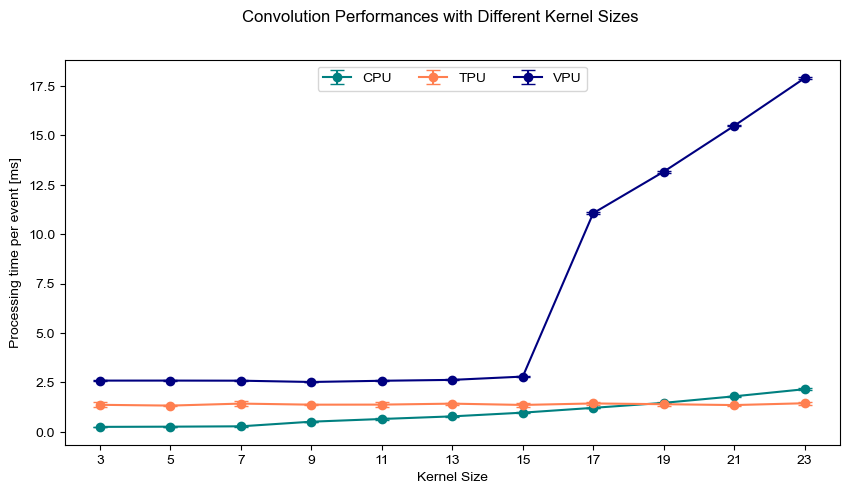

In [6]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv2d_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}

conv2d_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]

conv2d_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}

conv2d_error_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]


fig, ax = plt.subplots(1,1, figsize=(10,5))

x_values = [ str(size) for size in conv2d_data['kernel_sizes'] ]

fig.suptitle('Convolution Performances with Different Kernel Sizes')

# ax.bar(np.arange(len(x_values)) - 0.15, conv2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
ax.errorbar(np.arange(len(x_values)), conv2d_data['cpu_ov_data'], yerr = conv2d_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv2d_data['tpu_data'], yerr = conv2d_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv2d_data['vpu_data'], yerr = conv2d_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

# ax.grid(linestyle='--', color='lightgrey')
# ax.set_yscale('log')
ax.set_xticks(np.arange(len(x_values)), x_values)
ax.set_xlabel('Kernel Size')
ax.set_ylabel('Processing time per event [ms]')
ax.legend(ncol=4, loc="upper center")

fig.savefig("graphs/convolution_kernel_sizes_time_only.pdf")

In [8]:
np.min((np.array(conv2d_data['cpu_ov_data']))), np.max((np.array(conv2d_data['cpu_ov_data'])))

(0.250355477333, 2.1559053945541)

In [6]:
np.min((np.array(conv2d_data['tpu_data']))), np.min((np.array(conv2d_data['vpu_data'])))

(1.3268746161459999, 2.5215641188621)

In [7]:
np.max((np.array(conv2d_data['tpu_data']))), np.max((np.array(conv2d_data['vpu_data'])))

(1.4451571583747, 17.891551554203)

In [44]:
np.max(np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])))/1e9, np.max(np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])))/1e9

(24.01213722597958, 5.289205700995514)

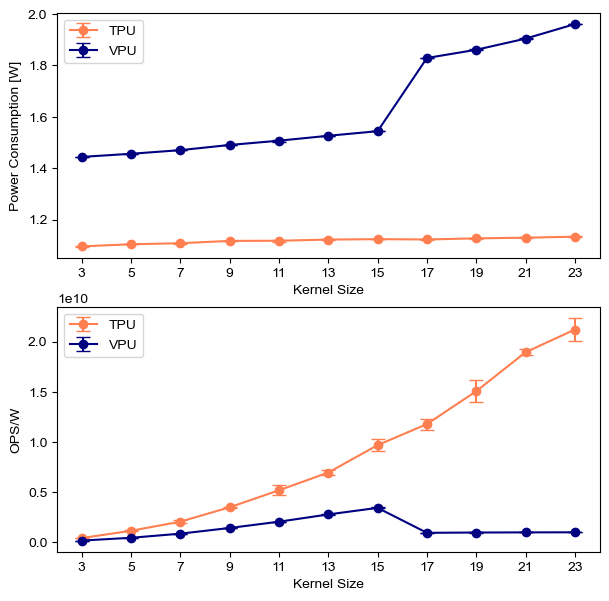

In [81]:
tpu_power_data = pd.read_csv("conv_kernel_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_kernel_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(2,1,figsize=(7,7))

# fig.suptitle("Power Evaluation for Different Kernel Sizes")

x_values = conv2d_data['kernel_sizes']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax[0].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[0].set_title('Power Consumption')
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(x_values)), x_values)
ax[0].legend()
ax[0].set_xlabel('Kernel Size')

ops_tpu = np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data']))
ops_tpu_error = np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])**2)*conv2d_error_data['tpu_data']

ops_vpu = np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data']))
ops_vpu_error = np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])**2)*conv2d_error_data['vpu_data']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu)
ops_w_tpu_error = np.sqrt((ops_tpu_error / np.array(yvalues_tpu))**2 + (ops_tpu*np.array(yerr_tpu) / np.array(yvalues_tpu)**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu)
ops_w_vpu_error = np.sqrt((ops_vpu_error / np.array(yvalues_vpu))**2 + (ops_vpu*np.array(yerr_tpu) / np.array(yvalues_vpu)**2)**2)

ax[1].errorbar(np.arange(len(x_values)), ops_w_tpu, yerr = ops_w_tpu_error, label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), ops_w_vpu, yerr = ops_w_vpu_error, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[1].set_title('Power Efficiency')
ax[1].set_ylabel('OPS/W')
ax[1].set_xticks(range(len(x_values)), x_values)
ax[1].legend()

ax[1].set_xlabel('Kernel Size')

fig.savefig("graphs/conv_kernel_test_power_evaluation.pdf",bbox_inches="tight", pad_inches=0)

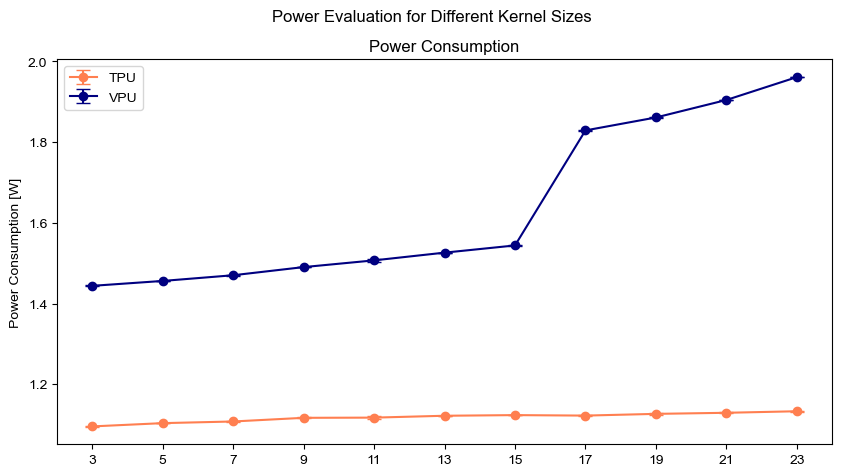

In [9]:
tpu_power_data = pd.read_csv("conv_kernel_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_kernel_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,1,figsize=(10,5))

fig.suptitle("Power Evaluation for Different Kernel Sizes")

x_values = conv2d_data['kernel_sizes']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax.errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

ax.set_title('Power Consumption')
ax.set_ylabel('Power Consumption [W]')
ax.set_xticks(range(len(x_values)), x_values)
ax.legend()

fig.savefig("graphs/conv_kernel_test_power_evaluation_power_only.pdf")

In [10]:
print(np.min(yvalues_tpu), np.max(yvalues_tpu))
print(np.min(yvalues_vpu), np.max(yvalues_vpu))

1.0955000000000001 1.1330666666666667
1.4438 1.9609032258064516


In [11]:
print(np.std(yvalues_tpu))
print(np.std(yvalues_vpu))

0.01092091152709925
0.1955717193913726


In [42]:
np.max(ops_w_tpu)/1e9, np.max(ops_w_vpu)/1e9

(21.192166297346066, 3.4259073821250934)

As comparison the results for 128 x 128 x 1 inputs

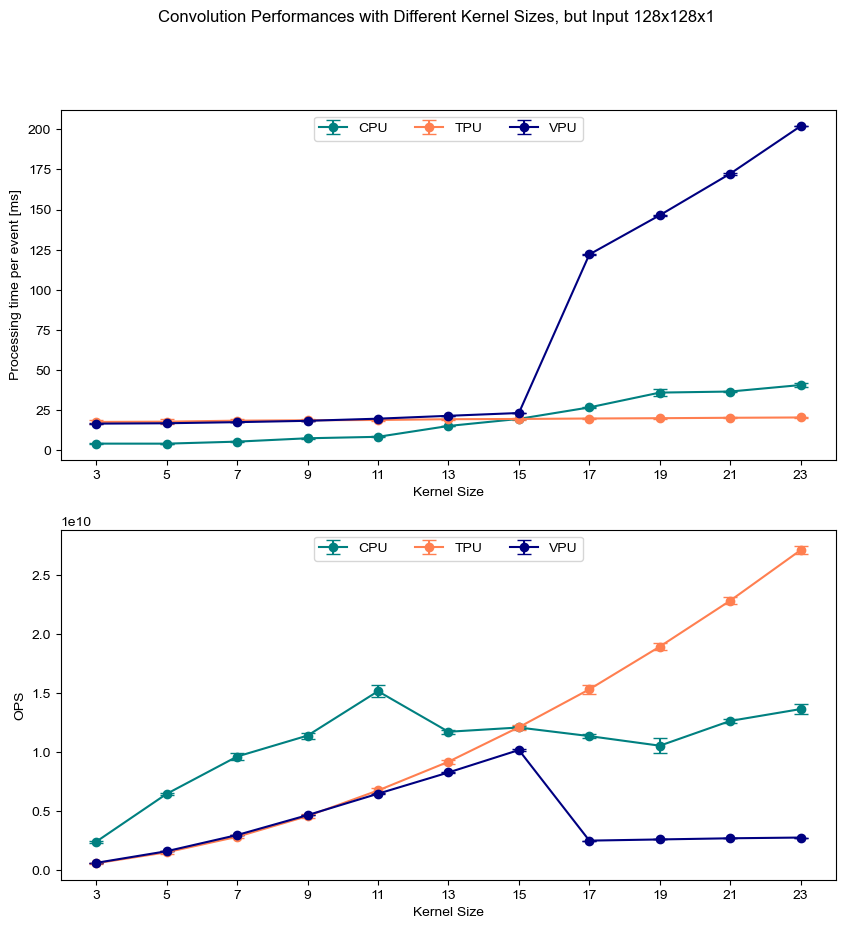

In [22]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv2d_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}


conv2d_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]

conv2d_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}

conv2d_error_data['cpu_tf_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['tpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_tpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['cpu_ov_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]
conv2d_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_data['kernel_sizes']]

conv2d_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_data['kernel_sizes']]


fig, ax = plt.subplots(2,1, figsize=(10,10))

x_values = [ str(size) for size in conv2d_data['kernel_sizes']]

fig.suptitle('Convolution Performances with Different Kernel Sizes, but Input 128x128x1')

# ax[0].bar(np.arange(len(x_values)) - 0.15, conv2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['cpu_ov_data'], yerr = conv2d_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['tpu_data'], yerr = conv2d_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv2d_data['vpu_data'], yerr = conv2d_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

# ax[0].grid(linestyle='--', color='lightgrey')
# ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(len(x_values)), x_values)
ax[0].set_xlabel('Kernel Size')
ax[0].set_ylabel('Processing time per event [ms]')
ax[0].legend(ncol=4, loc="upper center")

ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['cpu_ov_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['cpu_ov_data'])**2)*conv2d_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['tpu_data'])**2)*conv2d_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])), yerr=np.array(conv2d_data['operations'])*1e3/(np.array(conv2d_data['vpu_data'])**2)*conv2d_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].set_xlabel('Kernel Size')
ax[1].set_ylabel('OPS')
ax[1].legend(ncol=4, loc="upper center")

For the VPU, I would like to plot together the results for 32 x 32 x 1 input and the 128 x 128 x 1 input together for comparison

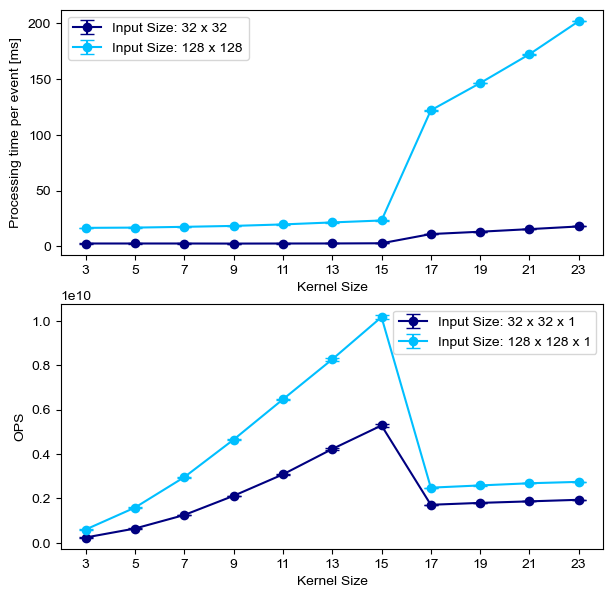

In [67]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv2d_32_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_32_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_32_data['kernel_sizes']]
conv2d_32_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_32_data['kernel_sizes']]

conv2d_32_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_32_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_32_error_data['kernel_sizes']]
conv2d_32_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_32_error_data['kernel_sizes']]

# ------------------------------------- #

conv2d_128_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_128_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_128_data['kernel_sizes']]
conv2d_128_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_128_data['kernel_sizes']]

conv2d_128_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_128_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_128_error_data['kernel_sizes']]
conv2d_128_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_128_error_data['kernel_sizes']]

# ---------------------------------------------------------------------- #

fig, ax = plt.subplots(2,1, figsize=(7,7))

x_values = [ str(size) for size in conv2d_32_data['kernel_sizes']]

# fig.suptitle('Convolution Performances for the VPU with Different Kernel Sizes')

ax[0].errorbar(np.arange(len(x_values)), conv2d_32_data['vpu_data'], yerr = conv2d_32_error_data['vpu_data'], label='Input Size: 32 x 32', color='navy', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv2d_128_data['vpu_data'], yerr = conv2d_128_error_data['vpu_data'], label='Input Size: 128 x 128', color='deepskyblue', fmt='-o', capsize=5)


# ax[0].grid(linestyle='--', color='lightgrey')
# ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(len(x_values)), x_values)
ax[0].set_xlabel('Kernel Size')
ax[0].set_ylabel('Processing time per event [ms]')
ax[0].legend(ncol=1, loc="upper left")

ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_32_data['operations'])*1e3/(np.array(conv2d_32_data['vpu_data'])), yerr=np.array(conv2d_32_data['operations'])*1e3/(np.array(conv2d_32_data['vpu_data'])**2)*conv2d_32_error_data['vpu_data'], label='Input Size: 32 x 32 x 1', color='navy', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv2d_128_data['operations'])*1e3/(np.array(conv2d_128_data['vpu_data'])), yerr=np.array(conv2d_128_data['operations'])*1e3/(np.array(conv2d_128_data['vpu_data'])**2)*conv2d_128_error_data['vpu_data'], label='Input Size: 128 x 128 x 1', color='deepskyblue', fmt='-o', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].set_xlabel('Kernel Size')
ax[1].set_ylabel('OPS')
ax[1].legend(ncol=1, loc="upper right")

fig.savefig("graphs/convolution_kernel_sizes_vpu_only.pdf",bbox_inches="tight", pad_inches=0)

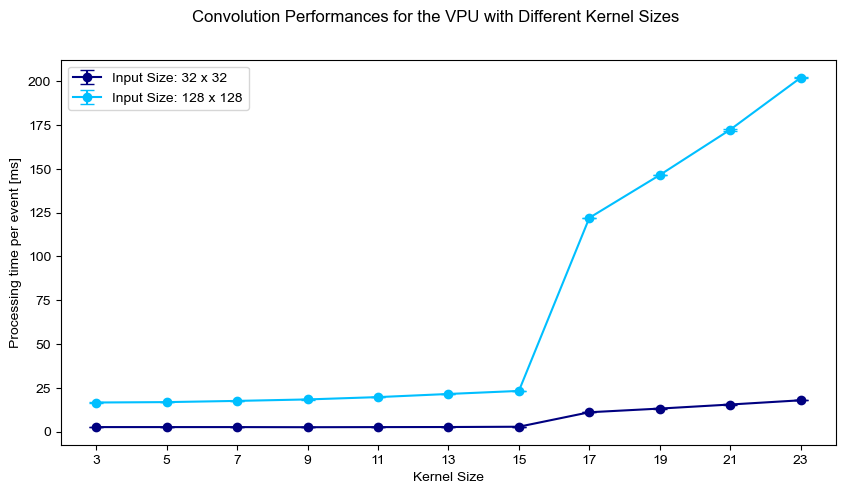

In [11]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv2d_32_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_32_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_32_data['kernel_sizes']]
conv2d_32_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_32_data['kernel_sizes']]

conv2d_32_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_32_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_32_error_data['kernel_sizes']]
conv2d_32_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_32_error_data['kernel_sizes']]

# ------------------------------------- #

conv2d_128_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_128_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in conv2d_128_data['kernel_sizes']]
conv2d_128_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_128_data['kernel_sizes']]

conv2d_128_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}
conv2d_128_error_data['vpu_data'] = [ pd.read_csv("conv_kernel_test/output_files_vpu_128_2/conv2d_" + str(size) + "/conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in conv2d_128_error_data['kernel_sizes']]
conv2d_128_error_data['operations'] = [ int(pd.read_csv("conv_kernel_test/vpu_models_128/conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in conv2d_128_error_data['kernel_sizes']]

# ---------------------------------------------------------------------- #

fig, ax = plt.subplots(1,1, figsize=(10,5))

x_values = [ str(size) for size in conv2d_32_data['kernel_sizes']]

fig.suptitle('Convolution Performances for the VPU with Different Kernel Sizes')

ax.errorbar(np.arange(len(x_values)), conv2d_32_data['vpu_data'], yerr = conv2d_32_error_data['vpu_data'], label='Input Size: 32 x 32', color='navy', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv2d_128_data['vpu_data'], yerr = conv2d_128_error_data['vpu_data'], label='Input Size: 128 x 128', color='deepskyblue', fmt='-o', capsize=5)

ax.set_xticks(np.arange(len(x_values)), x_values)
ax.set_xlabel('Kernel Size')
ax.set_ylabel('Processing time per event [ms]')
ax.legend(ncol=1, loc="upper left")

fig.savefig("graphs/convolution_kernel_sizes_vpu_time_only.pdf")

## 3b. Effects of Stride

10x1000 data, inputs have the size 32 x 32 x 1, stride in {1,2,3}

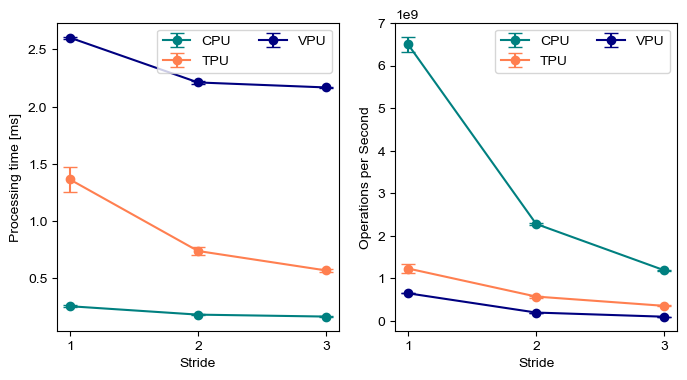

In [74]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv_stride_data = {'strides':[1,2,3]}

conv_stride_data['cpu_tf_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['tpu_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_tpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['cpu_ov_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['vpu_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_vpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]

conv_stride_data['operations'] = [ int(pd.read_csv("conv_stride_test/vpu_models/conv2d_stride_" + str(stride) + "/op_stat.csv")['flops'].sum()) for stride in conv_stride_data['strides']]

conv_stride_error_data = {'strides':[1,2,3]}

conv_stride_error_data['cpu_tf_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['tpu_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_tpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['cpu_ov_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['vpu_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_vpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]

x_values = [ str(stride) for stride in conv_stride_data['strides']]


fig, ax = plt.subplots(1,2, figsize=(8,4))
# fig.suptitle("Convolution Strides")
ax[0].set_xlabel("Stride")
ax[0].set_ylabel("Processing time [ms]")
# ax[0].bar(np.arange(len(x_values)) - 0.15, conv_stride_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[0].bar(np.arange(len(x_values)) - 0.2, conv_stride_data['cpu_ov_data'], width=0.2, label='CPU', color='teal')
# ax[0].bar(np.arange(len(x_values)), conv_stride_data['tpu_data'], width=0.2, label='TPU', color='coral')
# ax[0].bar(np.arange(len(x_values)) + 0.2, conv_stride_data['vpu_data'], width=0.2, label='VPU', color='navy')

ax[0].errorbar(np.arange(len(x_values)), conv_stride_data['cpu_ov_data'], yerr=conv_stride_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv_stride_data['tpu_data'], yerr=conv_stride_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv_stride_data['vpu_data'], yerr=conv_stride_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

ax[0].set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--',color='lightgrey')
ax[0].legend(ncol=2, loc="upper right")

ax[1].set_xlabel("Stride")
ax[1].set_ylabel("Operations per Second")
# ax[1].bar(np.arange(len(x_values)) - , np.array(conv_stride_data['operations'])/(np.array(conv_stride_data['cpu_tf_data'])), width=0.1, label='CPU (TF)', color='maroon')
# ax[1].bar(np.arange(len(x_values)) - 0.2, np.array(conv_stride_data['operations'])/(np.array(conv_stride_data['cpu_ov_data'])), width=0.2, label='CPU (OV)', color='teal')
# ax[1].bar(np.arange(len(x_values)), np.array(conv_stride_data['operations'])/(np.array(conv_stride_data['tpu_data'])), width=0.2, label='TPU', color='coral')
# ax[1].bar(np.arange(len(x_values)) + 0.2, np.array(conv_stride_data['operations'])/(np.array(conv_stride_data['vpu_data'])), width=0.2, label='VPU', color='navy')

ax[1].errorbar(np.arange(len(x_values)), np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['cpu_ov_data'])), yerr = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['cpu_ov_data'])**2)*conv_stride_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['tpu_data'])), yerr = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['tpu_data'])**2)*conv_stride_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['vpu_data'])), yerr = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['vpu_data'])**2)*conv_stride_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

# ax[1].grid(linestyle='--',color='lightgrey')
ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].legend(ncol=2, loc="upper right")

fig.savefig("graphs/convolution_stride.pdf")

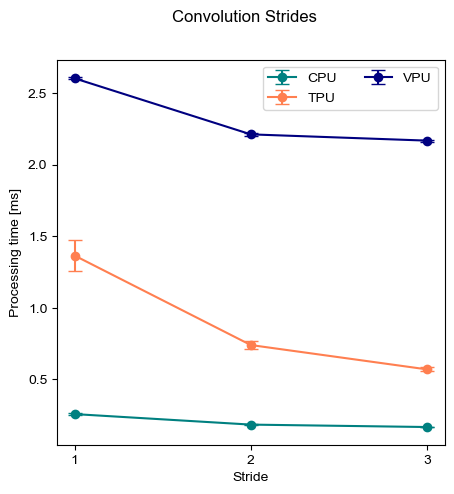

In [13]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv_stride_data = {'strides':[1,2,3]}

conv_stride_data['cpu_tf_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['tpu_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_tpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['cpu_ov_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_data['vpu_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_vpu_mean'][0]*1e3 for stride in conv_stride_data['strides']]

conv_stride_data['operations'] = [ int(pd.read_csv("conv_stride_test/vpu_models/conv2d_stride_" + str(stride) + "/op_stat.csv")['flops'].sum()) for stride in conv_stride_data['strides']]

conv_stride_error_data = {'strides':[1,2,3]}

conv_stride_error_data['cpu_tf_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['tpu_data'] = [ pd.read_csv("conv_stride_test/output_files_tpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_tpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['cpu_ov_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_cpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]
conv_stride_error_data['vpu_data'] = [ pd.read_csv("conv_stride_test/output_files_vpu/conv2d_stride_" + str(stride) + "/conv2d_stride_" + str(stride) + ".csv")['latency_vpu_stdev'][0]*1e3 for stride in conv_stride_data['strides']]

x_values = [ str(stride) for stride in conv_stride_data['strides']]


fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.suptitle("Convolution Strides")
ax.set_xlabel("Stride")
ax.set_ylabel("Processing time [ms]")

ax.errorbar(np.arange(len(x_values)), conv_stride_data['cpu_ov_data'], yerr=conv_stride_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv_stride_data['tpu_data'], yerr=conv_stride_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv_stride_data['vpu_data'], yerr=conv_stride_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=5)

ax.set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--',color='lightgrey')
ax.legend(ncol=2, loc="upper right")

fig.savefig("graphs/convolution_stride_time_only.pdf")

In [14]:
print(np.min((np.array(conv_stride_data['tpu_data']))), np.min((np.array(conv_stride_data['vpu_data']))))

print(np.max((np.array(conv_stride_data['tpu_data']))), np.max((np.array(conv_stride_data['vpu_data']))))

0.5695304584503 2.1672750473022
1.364061088562 2.6021709942816997


In [15]:
print(np.min((np.array(conv_stride_data['cpu_ov_data']))), np.max((np.array(conv_stride_data['cpu_ov_data']))))

0.1668736720085 0.2571861839294


In [48]:
np.max(np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['tpu_data'])))/1e9, np.max(np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['vpu_data'])))/1e9

(1.2251416113348368, 0.6422206702297468)

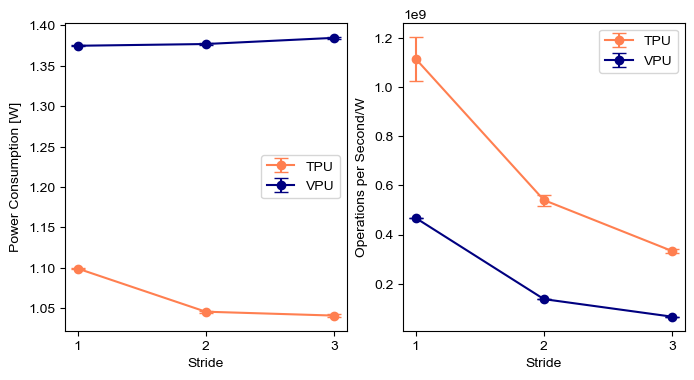

In [79]:
tpu_power_data = pd.read_csv("conv_stride_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_stride_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(8,4))

# fig.suptitle("Power Evaluation for Different Strides")

x_values = conv_stride_data['strides']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax[0].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[0].set_title('Power Consumption')
ax[0].set_xlabel("Stride")
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(x_values)), x_values)
ax[0].legend()

ops_tpu = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['tpu_data']))
ops_tpu_error = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['tpu_data'])**2)*conv_stride_error_data['tpu_data']

ops_vpu = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['vpu_data']))
ops_vpu_error = np.array(conv_stride_data['operations'])*1e3/(np.array(conv_stride_data['vpu_data'])**2)*conv_stride_error_data['vpu_data']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu)
ops_w_tpu_error = np.sqrt((ops_tpu_error / np.array(yvalues_tpu))**2 + (ops_tpu*np.array(yerr_tpu) / np.array(yvalues_tpu)**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu)
ops_w_vpu_error = np.sqrt((ops_vpu_error / np.array(yvalues_vpu))**2 + (ops_vpu*np.array(yerr_tpu) / np.array(yvalues_vpu)**2)**2)


ax[1].errorbar(np.arange(len(x_values)), ops_w_tpu, yerr = ops_w_tpu_error, label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), ops_w_vpu, yerr = ops_w_vpu_error, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[1].set_title('Power Efficiency')
ax[1].set_ylabel('Operations per Second/W')
ax[1].set_xlabel("Stride")
ax[1].set_xticks(range(len(x_values)), x_values)
ax[1].legend()

fig.savefig("graphs/conv_stride_test_power_evaluation.pdf")

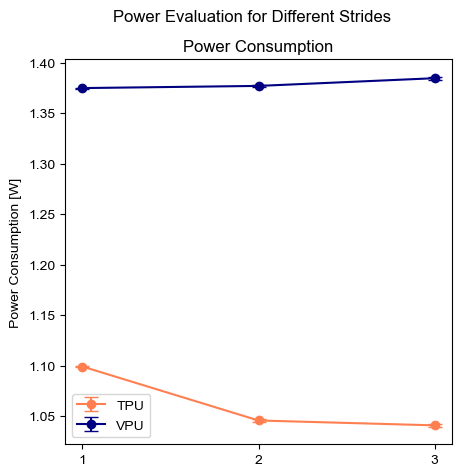

In [16]:
tpu_power_data = pd.read_csv("conv_stride_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_stride_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,1,figsize=(5,5))

# fig.suptitle("Power Evaluation for Different Strides")

x_values = conv_stride_data['strides']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax.errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

ax.set_title('Power Consumption')
ax.set_ylabel('Power Consumption [W]')
ax.set_xticks(range(len(x_values)), x_values)
ax.legend()

fig.savefig("graphs/conv_stride_test_power_evaluation_power_only.pdf")

In [33]:
print(np.min(yvalues_tpu), np.max(yvalues_tpu))
print(np.min(yvalues_vpu), np.max(yvalues_vpu))

1.041 1.0992000000000002
1.3747619047619046 1.3845294117647058


In [50]:
np.max(ops_w_tpu)/1e9, np.max(ops_w_vpu)/1e9

(1.1145757017238325, 0.4671504702052194)

## 3c. Effects of Filter numbers (eventually the number of channels)

Architecture -- 2 Conv2Ds, first Conv2D, has variable channel size and then the second Conv2D has 32 filters and a kernel size of (5,5)

10x10 000 samples 

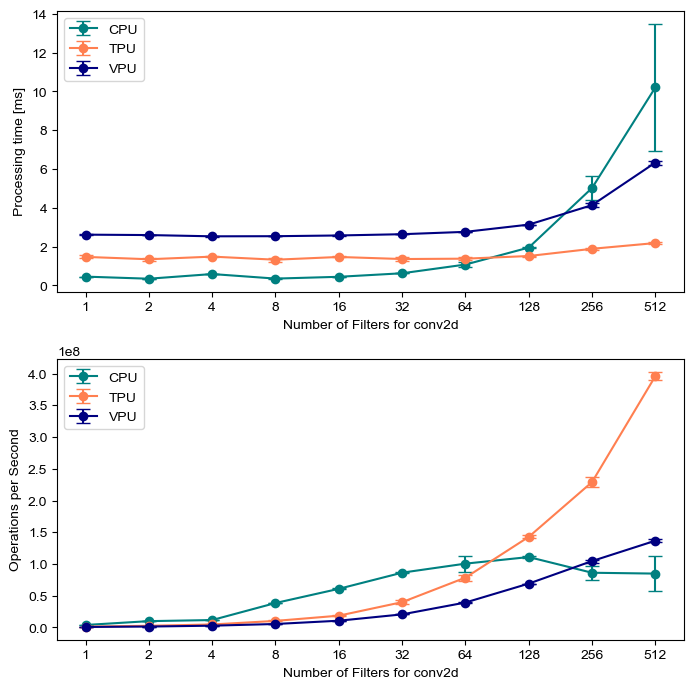

In [82]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv_channel_data = {'channels':[1,2,4,8,16,32,64,128,256,512]}

# conv_channel_data['cpu_tf_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['tpu_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_tpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['cpu_ov_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['vpu_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_vpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]

conv_channel_error_data = {'channels':[1,2,4,8,16,32,64,128,256,512]}

# conv_channel_error_data['cpu_tf_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_error_data['tpu_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_tpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]
conv_channel_error_data['cpu_ov_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]
conv_channel_error_data['vpu_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_vpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]

x_values = [ str(channel) for channel in conv_channel_data['channels']]

conv_channel_data['operations'] = [ int(pd.read_csv("conv_channels_test/vpu_models/conv2d_channel_" + str(channel) + "/op_stat.csv")['flops'].sum()) for channel in conv_channel_data['channels']]


fig, ax = plt.subplots(2,1, figsize=(7,7))
# ax[0].set_title("Number of Convolution Filters")
ax[0].set_xlabel("Number of Filters for conv2d")
ax[0].set_ylabel("Processing time [ms]")
# ax[0].bar(np.arange(len(x_values)) - 0.15, conv_channel_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[0].bar(np.arange(len(x_values)) - 0.2, conv_channel_data['cpu_ov_data'], width=0.2, label='CPU', color='teal')
# ax[0].bar(np.arange(len(x_values)), conv_channel_data['tpu_data'], width=0.2, label='TPU', color='coral')
# ax[0].bar(np.arange(len(x_values)) + 0.2, conv_channel_data['vpu_data'], width=0.2, label='VPU', color='navy')

ax[0].errorbar(np.arange(len(x_values)), conv_channel_data['cpu_ov_data'], yerr=conv_channel_error_data['cpu_ov_data'], fmt='-o', label='CPU', color='teal', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv_channel_data['tpu_data'], yerr=conv_channel_error_data['tpu_data'], fmt='-o', label='TPU', color='coral', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), conv_channel_data['vpu_data'], yerr=conv_channel_error_data['vpu_data'], fmt='-o', label='VPU', color='navy', capsize=5)

ax[0].set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--')
ax[0].legend()

# beside this please in operations per second, because it is not a level playing field, the output sizes are different
ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].set_xlabel("Number of Filters for conv2d")
ax[1].set_ylabel("Operations per Second")
# ax[1].bar(np.arange(len(x_values)) - 0.15, np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['cpu_tf_data'])), width=0.1, label='CPU (TF)', color='maroon')
# ax[1].bar(np.arange(len(x_values)) - 0.2, np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['cpu_ov_data'])), width=0.2, label='CPU', color='teal')
# ax[1].bar(np.arange(len(x_values)), np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['tpu_data'])), width=0.2, label='TPU', color='coral')
# ax[1].bar(np.arange(len(x_values)) + 0.2, np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['vpu_data'])), width=0.2, label='VPU', color='navy')

ax[1].errorbar(np.arange(len(x_values)), np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['cpu_ov_data'])), yerr = np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['cpu_ov_data'])**2)*conv_channel_error_data['cpu_ov_data'], fmt='-o', label='CPU', color='teal', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['tpu_data'])), fmt='-o', yerr = np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['tpu_data'])**2)*conv_channel_error_data['tpu_data'], label='TPU', color='coral', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['vpu_data'])), fmt='-o', yerr = np.array(conv_channel_data['operations'])/(np.array(conv_channel_data['vpu_data'])**2)*conv_channel_error_data['vpu_data'], label='VPU', color='navy', capsize=5)

# ax[1].grid(linestyle='--')
ax[1].legend()

fig.tight_layout()

fig.savefig("graphs/convolution_filter_channels.pdf", bbox_inches="tight", pad_inches=0)

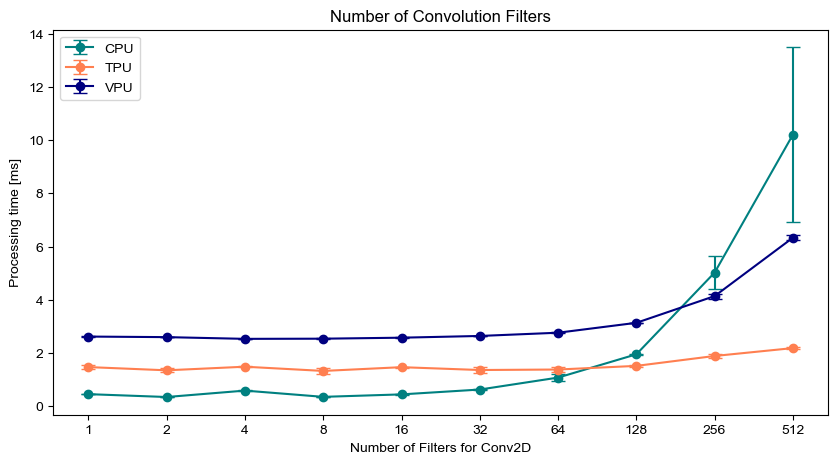

In [16]:
plt.rcParams.update({'font.sans-serif':'Arial'})

conv_channel_data = {'channels':[1,2,4,8,16,32,64,128,256,512]}

# conv_channel_data['cpu_tf_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['tpu_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_tpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['cpu_ov_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_data['vpu_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_vpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]

conv_channel_error_data = {'channels':[1,2,4,8,16,32,64,128,256,512]}

# conv_channel_error_data['cpu_tf_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_mean'][0]*1e3 for channel in conv_channel_data['channels']]
conv_channel_error_data['tpu_data'] = [ pd.read_csv("conv_channels_test/output_files_tpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_tpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]
conv_channel_error_data['cpu_ov_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_cpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]
conv_channel_error_data['vpu_data'] = [ pd.read_csv("conv_channels_test/output_files_vpu/conv2d_channel_" + str(channel) + "/conv2d_channel_" + str(channel) + ".csv")['latency_vpu_stdev'][0]*1e3 for channel in conv_channel_error_data['channels']]

x_values = [ str(channel) for channel in conv_channel_data['channels']]

conv_channel_data['operations'] = [ int(pd.read_csv("conv_channels_test/vpu_models/conv2d_channel_" + str(channel) + "/op_stat.csv")['flops'].sum()) for channel in conv_channel_data['channels']]


fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Number of Convolution Filters")
ax.set_xlabel("Number of Filters for Conv2D")
ax.set_ylabel("Processing time [ms]")
# ax[0].bar(np.arange(len(x_values)) - 0.15, conv_channel_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[0].bar(np.arange(len(x_values)) - 0.2, conv_channel_data['cpu_ov_data'], width=0.2, label='CPU', color='teal')
# ax[0].bar(np.arange(len(x_values)), conv_channel_data['tpu_data'], width=0.2, label='TPU', color='coral')
# ax[0].bar(np.arange(len(x_values)) + 0.2, conv_channel_data['vpu_data'], width=0.2, label='VPU', color='navy')

ax.errorbar(np.arange(len(x_values)), conv_channel_data['cpu_ov_data'], yerr=conv_channel_error_data['cpu_ov_data'], fmt='-o', label='CPU', color='teal', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv_channel_data['tpu_data'], yerr=conv_channel_error_data['tpu_data'], fmt='-o', label='TPU', color='coral', capsize=5)
ax.errorbar(np.arange(len(x_values)), conv_channel_data['vpu_data'], yerr=conv_channel_error_data['vpu_data'], fmt='-o', label='VPU', color='navy', capsize=5)

ax.set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--')
ax.legend()

fig.savefig("graphs/convolution_filter_channels_time_only.pdf")

In [17]:
print(np.min((np.array(conv_channel_data['tpu_data']))), np.min((np.array(conv_channel_data['vpu_data']))))

print(np.max((np.array(conv_channel_data['tpu_data']))), np.max((np.array(conv_channel_data['vpu_data']))))

1.3267161154747 2.5324539685249
2.1853959083556997 6.334751517772601


In [18]:
print(np.min((np.array(conv_channel_data['cpu_ov_data']))), np.max((np.array(conv_channel_data['cpu_ov_data']))))

0.3470303344726 10.208990314006801


In [52]:
np.max(np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['tpu_data'])))/1e9, np.max(np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['vpu_data'])))/1e9

(396.0985982861591, 136.6481784757313)

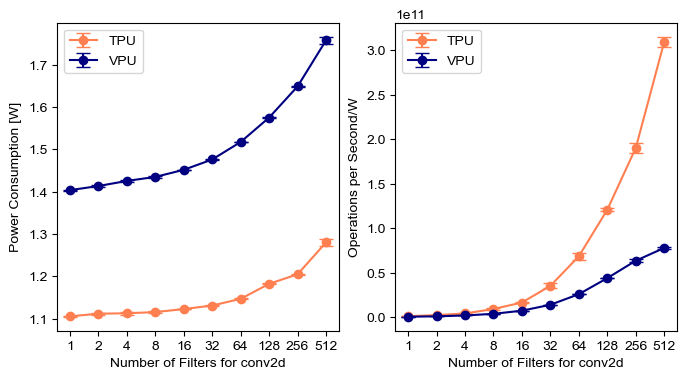

In [83]:
tpu_power_data = pd.read_csv("conv_channels_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_channels_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(8,4))

# fig.suptitle("Power Evaluation for Different Number of Convolutional Filters")

x_values = conv_channel_data['channels']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax[0].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[0].set_title('Power Consumption')
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(x_values)), x_values)
ax[0].legend()
ax[0].set_xlabel("Number of Filters for conv2d")

ops_tpu = np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['tpu_data']))
ops_tpu_error = np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['tpu_data'])**2)*conv_channel_error_data['tpu_data']

ops_vpu = np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['vpu_data']))
ops_vpu_error = np.array(conv_channel_data['operations'])*1e3/(np.array(conv_channel_data['vpu_data'])**2)*conv_channel_error_data['vpu_data']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu)
ops_w_tpu_error = np.sqrt((ops_tpu_error / np.array(yvalues_tpu))**2 + (ops_tpu*np.array(yerr_tpu) / np.array(yvalues_tpu)**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu)
ops_w_vpu_error = np.sqrt((ops_vpu_error / np.array(yvalues_vpu))**2 + (ops_vpu*np.array(yerr_tpu) / np.array(yvalues_vpu)**2)**2)

ax[1].errorbar(np.arange(len(x_values)), ops_w_tpu, yerr = ops_w_tpu_error, label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), ops_w_vpu, yerr = ops_w_vpu_error, label='VPU', color='navy', fmt='-o', capsize=5)

# ax[1].set_title('Power Efficiency')
ax[1].set_ylabel('Operations per Second/W')
ax[1].set_xticks(range(len(x_values)), x_values)
ax[1].legend()

ax[1].set_xlabel("Number of Filters for conv2d")

fig.savefig("graphs/conv_channels_test_power_evaluation.pdf")

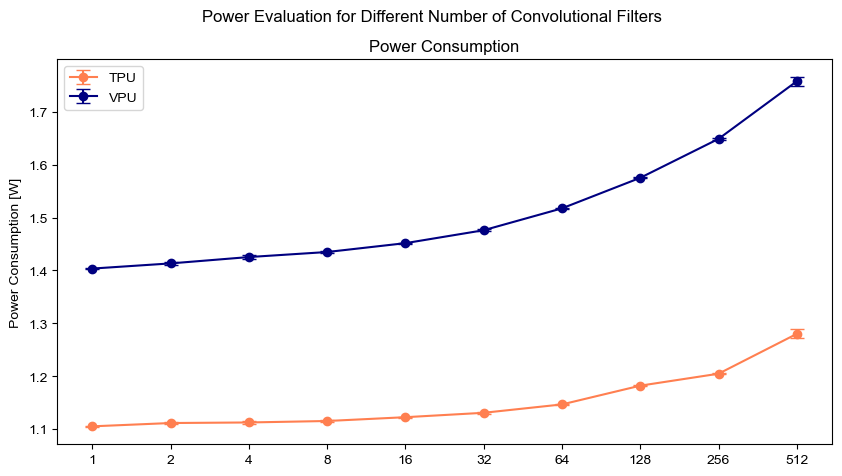

In [23]:
tpu_power_data = pd.read_csv("conv_channels_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("conv_channels_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,1,figsize=(10,5))

fig.suptitle("Power Evaluation for Different Number of Convolutional Filters")

x_values = conv_channel_data['channels']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax.errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax.errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

ax.set_title('Power Consumption')
ax.set_ylabel('Power Consumption [W]')
ax.set_xticks(range(len(x_values)), x_values)
ax.legend()

fig.savefig("graphs/conv_channels_test_power_evaluation_power_only.pdf")

In [35]:
print(np.min(yvalues_tpu), np.max(yvalues_tpu))
print(np.min(yvalues_vpu), np.max(yvalues_vpu))

1.1055000000000001 1.2802857142857142
1.403625 1.757645161290323


In [55]:
np.max(ops_w_tpu)/1e9, np.max(ops_w_vpu)/1e9

(309.3829712121305, 77.74503152582578)

## 4. Maxpooling and Average Pooling with Different Pool Sizes

10x10000 data, inputs are 128 x 128 x 1 tensors. Pool sizes are variable. Pool_sizes are even because that's what people usually use.

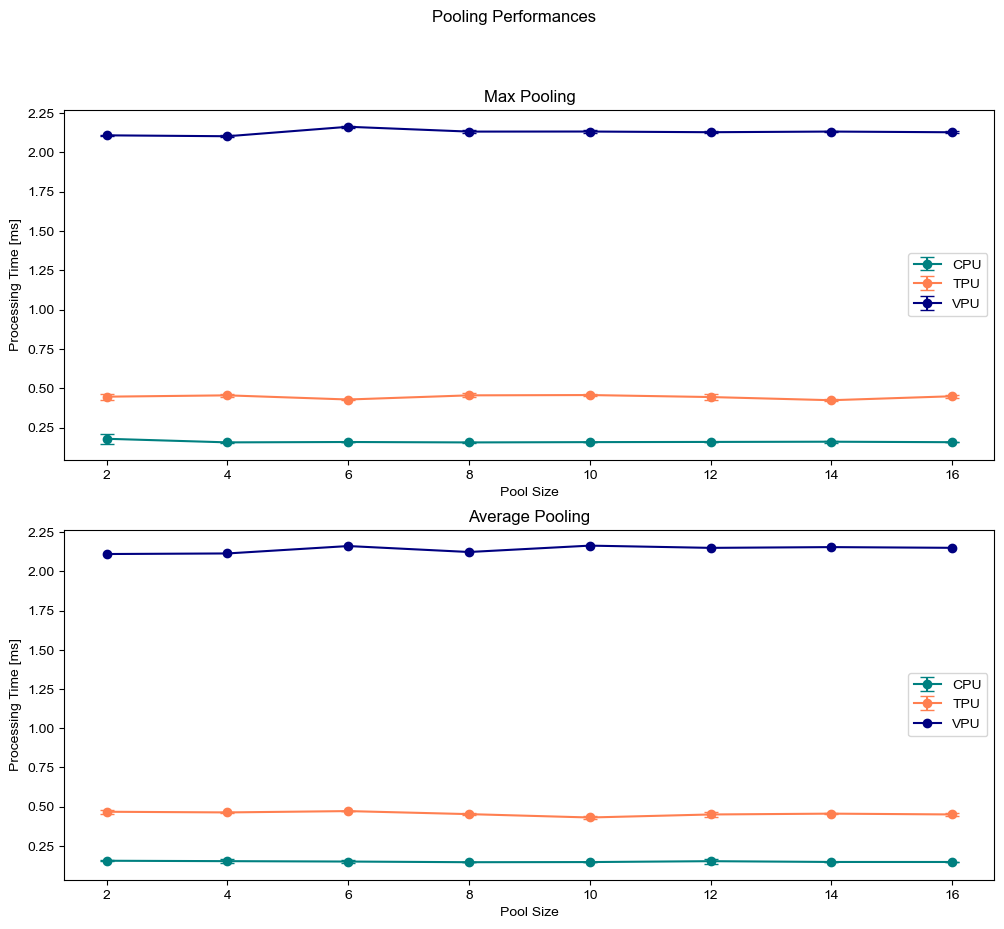

In [4]:
plt.rcParams.update({'font.sans-serif':'Arial'})

maxpooling2d_data = {'pool_sizes': [2,4,6,8,10,12,14,16]}

# maxpooling2d_data['cpu_tf_data'] = [ pd.read_csv("pooling_test/output_files_tpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in maxpooling2d_data['pool_sizes']]
maxpooling2d_data['tpu_data'] = [ pd.read_csv("pooling_test/output_files_tpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in maxpooling2d_data['pool_sizes']]
maxpooling2d_data['cpu_ov_data'] = [ pd.read_csv("pooling_test/output_files_vpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in maxpooling2d_data['pool_sizes']]
maxpooling2d_data['vpu_data'] = [ pd.read_csv("pooling_test/output_files_vpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in maxpooling2d_data['pool_sizes']]

maxpooling2d_error_data = {'pool_sizes': [2,4,6,8,10,12,14,16]}

# maxpooling2d_error_data['cpu_tf_data'] = [ pd.read_csv("pooling_test/output_files_tpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in maxpooling2d_error_data['pool_sizes']]
maxpooling2d_error_data['tpu_data'] = [ pd.read_csv("pooling_test/output_files_tpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in maxpooling2d_error_data['pool_sizes']]
maxpooling2d_error_data['cpu_ov_data'] = [ pd.read_csv("pooling_test/output_files_vpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in maxpooling2d_error_data['pool_sizes']]
maxpooling2d_error_data['vpu_data'] = [ pd.read_csv("pooling_test/output_files_vpu/maxpooling2d_" + str(size) + "/maxpooling2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in maxpooling2d_error_data['pool_sizes']]


# ------------------------------------------------------ #

avgpooling2d_data = {'pool_sizes': [2,4,6,8,10,12,14,16]}

# avgpooling2d_data['cpu_tf_data'] = [ pd.read_csv("pooling_test/output_files_tpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in avgpooling2d_data['pool_sizes']]
avgpooling2d_data['tpu_data'] = [ pd.read_csv("pooling_test/output_files_tpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in avgpooling2d_data['pool_sizes']]
avgpooling2d_data['cpu_ov_data'] = [ pd.read_csv("pooling_test/output_files_vpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in avgpooling2d_data['pool_sizes']]
avgpooling2d_data['vpu_data'] = [ pd.read_csv("pooling_test/output_files_vpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in avgpooling2d_data['pool_sizes']]

avgpooling2d_error_data = {'pool_sizes': [2,4,6,8,10,12,14,16]}

# avgpooling2d_data['cpu_tf_data'] = [ pd.read_csv("pooling_test/output_files_tpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in avgpooling2d_error_data['pool_sizes']]
avgpooling2d_error_data['tpu_data'] = [ pd.read_csv("pooling_test/output_files_tpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in avgpooling2d_error_data['pool_sizes']]
avgpooling2d_error_data['cpu_ov_data'] = [ pd.read_csv("pooling_test/output_files_vpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in avgpooling2d_error_data['pool_sizes']]
avgpooling2d_error_data['vpu_data'] = [ pd.read_csv("pooling_test/output_files_vpu/avgpooling2d_" + str(size) + "/avgpooling2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in avgpooling2d_error_data['pool_sizes']]


fig, ax = plt.subplots(2,1, figsize=(12,10))
fig.suptitle("Pooling Performances")

x_values = [ str(size) for size in maxpooling2d_data['pool_sizes']]

ax[0].set_title("Max Pooling")
# ax[0].bar(np.arange(len(x_values)) - 0.15, maxpooling2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[0].bar(np.arange(len(x_values)) - 0.2, maxpooling2d_data['cpu_ov_data'], width=0.2, label='CPU', color='teal')
# ax[0].bar(np.arange(len(x_values)), maxpooling2d_data['tpu_data'], width=0.2, label='TPU', color='coral')
# ax[0].bar(np.arange(len(x_values)) + 0.2, maxpooling2d_data['vpu_data'], width=0.2, label='VPU', color='navy')
ax[0].errorbar(np.arange(len(x_values)), maxpooling2d_data['cpu_ov_data'], yerr=maxpooling2d_error_data['cpu_ov_data'], fmt='-o', label='CPU', color='teal', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), maxpooling2d_data['tpu_data'], yerr=maxpooling2d_error_data['tpu_data'], fmt='-o', label='TPU', color='coral', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), maxpooling2d_data['vpu_data'], yerr=maxpooling2d_error_data['vpu_data'], fmt='-o', label='VPU', color='navy', capsize=5)
ax[0].set_xlabel("Pool Size")
ax[0].set_ylabel("Processing Time [ms]")
ax[0].set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--')
ax[0].legend()


ax[1].set_title("Average Pooling")
ax[1].set_xlabel("Pool Size")
ax[1].set_xlabel("Pool Size")
ax[1].set_ylabel("Processing Time [ms]")

# ax[1].bar(np.arange(len(x_values)) - 0.15, avgpooling2d_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
# ax[1].bar(np.arange(len(x_values)) - 0.2, avgpooling2d_data['cpu_ov_data'], width=0.2, label='CPU', color='teal')
# ax[1].bar(np.arange(len(x_values)), avgpooling2d_data['tpu_data'], width=0.2, label='TPU', color='coral')
# ax[1].bar(np.arange(len(x_values)) + 0.2, avgpooling2d_data['vpu_data'], width=0.2, label='VPU', color='navy')

ax[1].errorbar(np.arange(len(x_values)), avgpooling2d_data['cpu_ov_data'], yerr=avgpooling2d_error_data['cpu_ov_data'], fmt='-o', label='CPU', color='teal', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), avgpooling2d_data['tpu_data'], yerr=avgpooling2d_error_data['tpu_data'], fmt='-o', label='TPU', color='coral', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), avgpooling2d_data['vpu_data'], fmt='-o', label='VPU', color='navy', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
# ax[1].grid(linestyle='--')
ax[1].legend()

fig.savefig("graphs/pooling_performance.pdf")

In [11]:
print("Max Pooling Processing Times")

print(f"CPU: {np.mean(maxpooling2d_data['cpu_ov_data']):.2f} ± {np.std(maxpooling2d_data['cpu_ov_data']):.2f} ms")
print(f"TPU: {np.mean(maxpooling2d_data['tpu_data']):.2f} ± {np.std(maxpooling2d_data['tpu_data']):.2f} ms")
print(f"VPU: {np.mean(maxpooling2d_data['vpu_data']):.2f} ± {np.std(maxpooling2d_data['vpu_data']):.2f} ms")

print("")

print("Avg Pooling Processing Times")
print(f"CPU: {np.mean(avgpooling2d_data['cpu_ov_data']):.2f} ± {np.std(avgpooling2d_data['cpu_ov_data']):.2f} ms")
print(f"TPU: {np.mean(avgpooling2d_data['tpu_data']):.2f} ± {np.std(avgpooling2d_data['tpu_data']):.2f} ms")
print(f"VPU: {np.mean(avgpooling2d_data['vpu_data']):.2f} ± {np.std(avgpooling2d_data['vpu_data']):.2f} ms")

Max Pooling Processing Times
CPU: 0.16 ± 0.01 ms
TPU: 0.45 ± 0.01 ms
VPU: 2.13 ± 0.02 ms

Avg Pooling Processing Times
CPU: 0.15 ± 0.00 ms
TPU: 0.46 ± 0.01 ms
VPU: 2.14 ± 0.02 ms


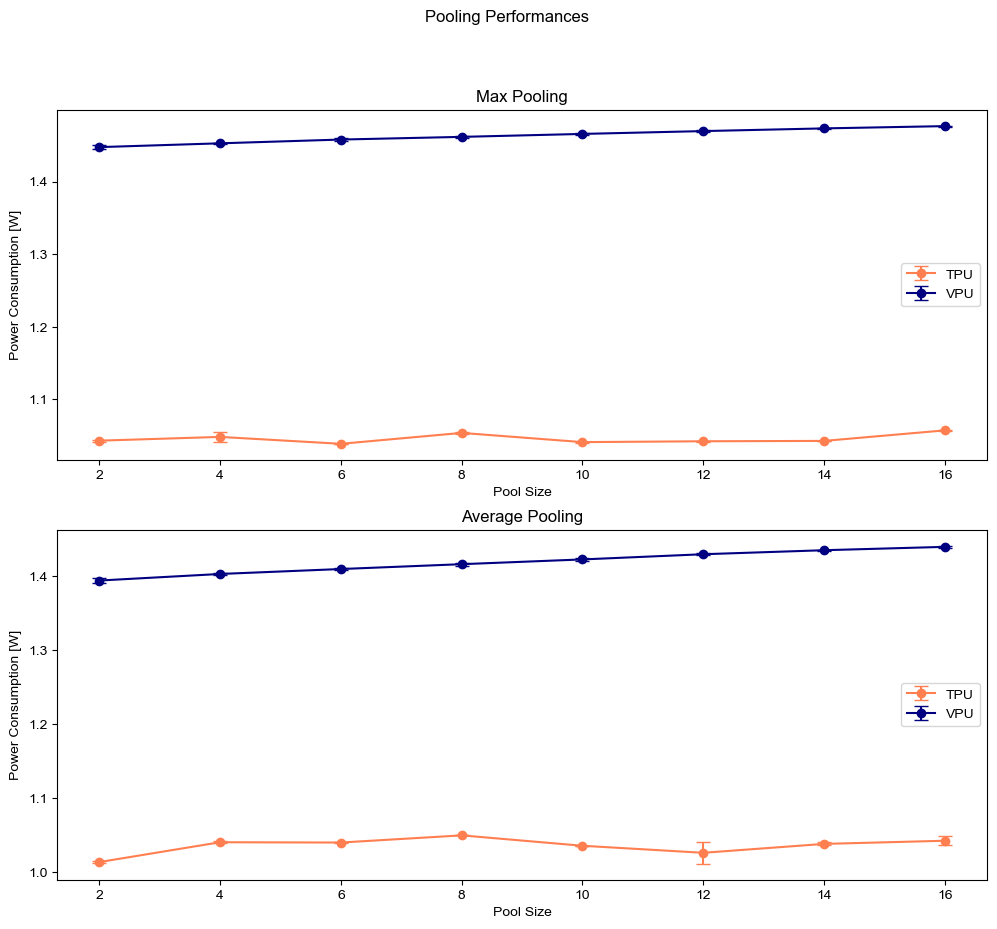

In [14]:
plt.rcParams.update({'font.sans-serif':'Arial'})

tpu_power_data = pd.read_csv("pooling_test/power_meas_usb/power_measurements_tpu.csv")
vpu_power_data = pd.read_csv("pooling_test/power_meas_usb/power_measurements_vpu.csv")

fig, ax = plt.subplots(2,1, figsize=(12,10))
fig.suptitle("Pooling Performances")

x_values = maxpooling2d_data['pool_sizes']

yvalues_tpu = np.array([ tpu_power_data.mean()["power_maxpooling2d_" + str(i) + " [W]"] for i in x_values ])
yerr_tpu = np.array([ tpu_power_data.std()["power_maxpooling2d_" + str(i) + " [W]"] for i in x_values ])

yvalues_vpu = np.array([ vpu_power_data.mean()["power_maxpooling2d_" + str(i) + " [W]"] for i in x_values ])
yerr_vpu = np.array([ vpu_power_data.std()["power_maxpooling2d_" + str(i) + " [W]"] for i in x_values ])

ax[0].set_title("Max Pooling")
ax[0].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr=yerr_tpu, fmt='-o', label='TPU', color='coral', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr=yerr_vpu, fmt='-o', label='VPU', color='navy', capsize=5)
ax[0].set_xlabel("Pool Size")
ax[0].set_ylabel("Power Consumption [W]")
ax[0].set_xticks(np.arange(len(x_values)), x_values)
ax[0].legend()

yvalues_tpu = np.array([ tpu_power_data.mean()["power_avgpooling2d_" + str(i) + " [W]"] for i in x_values ])
yerr_tpu = np.array([ tpu_power_data.std()["power_avgpooling2d_" + str(i) + " [W]"] for i in x_values ])

yvalues_vpu = np.array([ vpu_power_data.mean()["power_avgpooling2d_" + str(i) + " [W]"] for i in x_values ])
yerr_vpu = np.array([ vpu_power_data.std()["power_avgpooling2d_" + str(i) + " [W]"] for i in x_values ])

ax[1].set_title("Average Pooling")
ax[1].set_xlabel("Pool Size")
ax[1].set_xlabel("Pool Size")
ax[1].set_ylabel("Power Consumption [W]")

ax[1].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr=yerr_tpu, fmt='-o', label='TPU', color='coral', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr=yerr_vpu, fmt='-o', label='VPU', color='navy', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].legend()

fig.savefig("graphs/pooling_test_power_evaluation.pdf")

In [18]:
print("Max Pooling Power Consumption")
print(f"TPU: {np.mean(np.array([tpu_power_data.mean()['power_maxpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} ± {np.std(np.array([tpu_power_data.mean()['power_maxpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} W")
print(f"VPU: {np.mean(np.array([vpu_power_data.mean()['power_maxpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} ± {np.std(np.array([vpu_power_data.mean()['power_maxpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} W")

print("")

print("Avg Pooling Power Consumption")
print(f"TPU: {np.mean(np.array([tpu_power_data.mean()['power_avgpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} ± {np.std(np.array([tpu_power_data.mean()['power_avgpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} W")
print(f"VPU: {np.mean(np.array([vpu_power_data.mean()['power_avgpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} ± {np.std(np.array([vpu_power_data.mean()['power_avgpooling2d_' + str(i) + ' [W]'] for i in x_values])):.2f} W")

Max Pooling Power Consumption
TPU: 1.05 ± 0.01 W
VPU: 1.46 ± 0.01 W

Avg Pooling Power Consumption
TPU: 1.04 ± 0.01 W
VPU: 1.42 ± 0.01 W


## 5. Activations Comparison

Convolutions of input image 32x32 with attached activation functions. 10x10000 input data

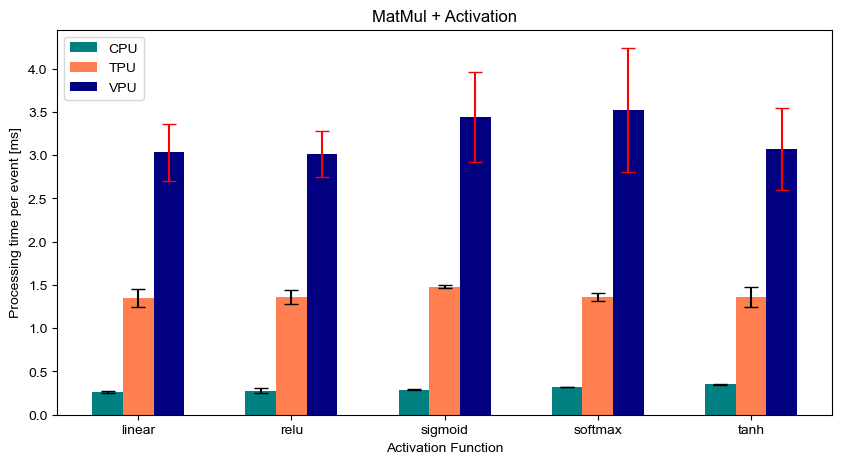

In [29]:
plt.rcParams.update({'font.sans-serif':'Arial'})

activations_data = {'activations': ['linear','relu','sigmoid','softmax','tanh']}

# activations_data['cpu_tf_data'] = [ pd.read_csv("activations_test/output_files_tpu/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_cpu_mean'][0]*1e3 for act in activations_data['activations']]
activations_data['cpu_ov_data'] = [ pd.read_csv("activations_test/output_files_vpu_2/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_cpu_mean'][0]*1e3 for act in activations_data['activations']]
activations_data['tpu_data'] = [ pd.read_csv("activations_test/output_files_tpu/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_tpu_mean'][0]*1e3 for act in activations_data['activations']]
activations_data['vpu_data'] = [ pd.read_csv("activations_test/output_files_vpu_3/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_vpu_mean'][0]*1e3 for act in activations_data['activations']]

activations_error_data = {'activations': ['linear','relu','sigmoid','softmax','tanh']}

# activations_error_data['cpu_tf_data'] = [ pd.read_csv("activations_test/output_files_tpu/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_cpu_stdev'][0]*1e3 for act in activations_data['activations']]
activations_error_data['cpu_ov_data'] = [ pd.read_csv("activations_test/output_files_vpu_2/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_cpu_stdev'][0]*1e3 for act in activations_data['activations']]
activations_error_data['tpu_data'] = [ pd.read_csv("activations_test/output_files_tpu/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_tpu_stdev'][0]*1e3 for act in activations_data['activations']]
activations_error_data['vpu_data'] = [ pd.read_csv("activations_test/output_files_vpu_3/activation_" + str(act) + "/activation_" + str(act) + ".csv")['latency_vpu_stdev'][0]*1e3 for act in activations_data['activations']]

plt.figure(figsize=(10,5))

x_values = [ str(act) for act in activations_data['activations']]

# plt.bar(np.arange(len(x_values)) - 0.15, activations_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
plt.bar(np.arange(len(x_values)) - 0.2, activations_data['cpu_ov_data'], width=0.2, yerr=activations_error_data['cpu_ov_data'], label='CPU', color='teal', capsize=5)
plt.bar(np.arange(len(x_values)), activations_data['tpu_data'], yerr=activations_error_data['tpu_data'], width=0.2, label='TPU', color='coral', capsize=5)
plt.bar(np.arange(len(x_values)) + 0.2, activations_data['vpu_data'],yerr=activations_error_data['vpu_data'], width=0.2, label='VPU', color='navy', ecolor='red', capsize=5)
# plt.grid(linestyle='--')
plt.title('MatMul + Activation')
plt.xticks(np.arange(len(x_values)), x_values)
plt.xlabel('Activation Function')
plt.ylabel('Processing time per event [ms]')
plt.legend()

plt.savefig("graphs/activation_functions_effect.pdf")

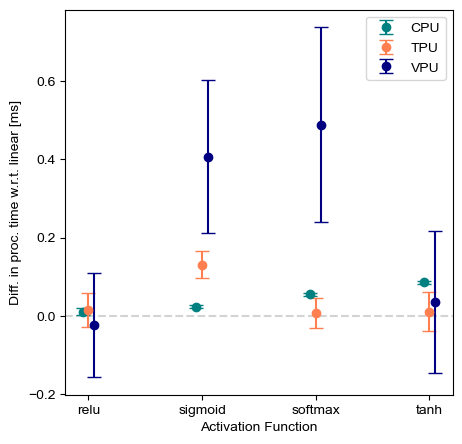

In [84]:
activations_data_diff = {'cpu_ov_data': [], 'tpu_data': [], 'vpu_data':[]}

activations_data_diff_error = {'cpu_ov_data': [], 'tpu_data': [], 'vpu_data':[]}

for i in np.arange(1,5):
    activations_data_diff['cpu_ov_data'].append(activations_data['cpu_ov_data'][i] - activations_data['cpu_ov_data'][0])
    activations_data_diff['tpu_data'].append(activations_data['tpu_data'][i] - activations_data['tpu_data'][0])
    activations_data_diff['vpu_data'].append(activations_data['vpu_data'][i] - activations_data['vpu_data'][0])
    
    activations_data_diff_error['cpu_ov_data'].append(np.sqrt(activations_error_data['cpu_ov_data'][i]**2 + activations_error_data['cpu_ov_data'][0]**2))
    activations_data_diff_error['tpu_data'].append(np.sqrt(activations_error_data['tpu_data'][i]**2 + activations_error_data['tpu_data'][0]**2))
    activations_data_diff_error['vpu_data'].append(np.sqrt(activations_error_data['vpu_data'][i]**2 + activations_error_data['vpu_data'][0]**2))


plt.figure(figsize=(5,5))

x_values = [ str(act) for act in activations_data['activations']]

plt.axhline(y=0, color='lightgrey', linestyle='--')

plt.errorbar(np.arange(len(x_values))[1:] - 0.05, activations_data_diff['cpu_ov_data'], yerr=activations_data_diff_error['cpu_ov_data']/np.sqrt(10), label='CPU', color='teal', fmt='o', capsize=5)
plt.errorbar(np.arange(len(x_values))[1:], activations_data_diff['tpu_data'], yerr=activations_data_diff_error['tpu_data']/np.sqrt(10), label='TPU', color='coral', fmt='o', capsize=5)
plt.errorbar(np.arange(len(x_values))[1:] + 0.05, activations_data_diff['vpu_data'],yerr=activations_data_diff_error['vpu_data']/np.sqrt(10), label='VPU', color='navy', fmt='o', capsize=5)



# plt.title('Activation Functions Effect')
plt.xticks(np.arange(len(x_values))[1:], x_values[1:])
plt.xlabel('Activation Function')
plt.ylabel('Diff. in proc. time w.r.t. linear [ms]')
plt.legend()

plt.savefig("graphs/activation_functions_effect_difference.pdf", bbox_inches="tight", pad_inches=0)

In [31]:
activations_data_diff['tpu_data'], activations_data_diff['vpu_data'], activations_data_diff['cpu_ov_data']

([0.01484400272369979,
  0.13093797206879998,
  0.007062427997599929,
  0.010468780994399962],
 [-0.023490528265600386,
  0.40666945060089965,
  0.48845738728839994,
  0.03540062983829939],
 [0.010624997615799936,
  0.02296869993209999,
  0.05499942779540001,
  0.08562363862990002])

In [33]:
activations_data_diff_error['tpu_data']/np.sqrt(10), activations_data_diff_error['vpu_data']/np.sqrt(10), activations_data_diff_error['cpu_ov_data']/np.sqrt(10)

(array([0.04313005, 0.0347031 , 0.037436  , 0.04932795]),
 array([0.13305674, 0.19471917, 0.24864042, 0.18159271]),
 array([0.00927287, 0.0036111 , 0.00362288, 0.00340897]))

## 6. Inception Architecture Effects

Luise likes to use it, she said. Maybe I can test. 32x32x1 inputs, 10x10000 of it.

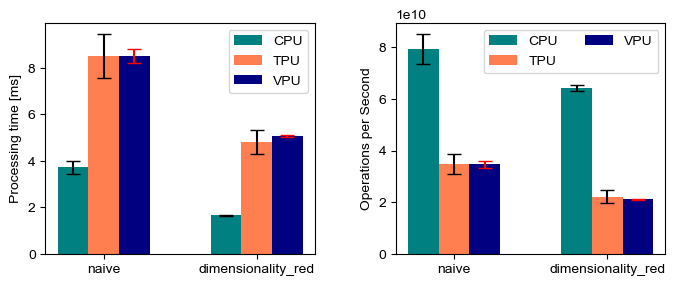

In [55]:
plt.rcParams.update({'font.sans-serif':'Arial'})

inception_data = {'names':['naive', 'dimensionality_red']}

inception_data['cpu_tf_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['cpu_ov_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['tpu_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_tpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['vpu_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_vpu_mean'][0]*1e3 for name in inception_data['names']]

inception_error_data = {'names':['naive', 'dimensionality_red']}

inception_error_data['cpu_tf_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['cpu_ov_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['tpu_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_tpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['vpu_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_vpu_stdev'][0]*1e3 for name in inception_data['names']]

inception_data['operations'] = [int(pd.read_csv("inception_test/vpu_models/inception_" + str(name) + "/op_stat.csv")['flops'].sum()) for name in inception_data['names']]

x_values = [ str(name) for name in inception_data['names']]


fig, ax = plt.subplots(1,2, figsize=(8,3))
fig.subplots_adjust(wspace=0.3)
ax[0].set_ylabel("Processing time [ms]")
# ax[0].bar(np.arange(len(x_values)) - 0.15, inception_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
ax[0].bar(np.arange(len(x_values)) - 0.2, inception_data['cpu_ov_data'], yerr=inception_error_data['cpu_ov_data'], width=0.2, label='CPU', color='teal', capsize=5)
ax[0].bar(np.arange(len(x_values)), inception_data['tpu_data'], yerr=inception_error_data['tpu_data'], width=0.2, label='TPU', color='coral', capsize=5)
ax[0].bar(np.arange(len(x_values)) + 0.2, inception_data['vpu_data'], yerr=inception_error_data['vpu_data'], width=0.2, label='VPU', color='navy', ecolor='red', capsize=5)
ax[0].set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--')
ax[0].legend(ncol=1, loc="upper right")

ax[1].set_ylabel("Operations per Second")
# ax[1].bar(np.arange(len(x_values)) - 0.15, np.array(inception_data['operations'])/(np.array(inception_data['cpu_tf_data'])), width=0.1, label='CPU (TF)', color='maroon')
ax[1].bar(np.arange(len(x_values)) - 0.2, np.array(inception_data['operations'])*1e3/(np.array(inception_data['cpu_ov_data'])), yerr=np.array(inception_data['operations'])*1e3/(np.array(inception_data['cpu_ov_data'])**2)*inception_error_data['cpu_ov_data'], width=0.2, label='CPU', color='teal', capsize=5)
ax[1].bar(np.arange(len(x_values)), np.array(inception_data['operations'])*1e3/(np.array(inception_data['tpu_data'])), yerr=np.array(inception_data['operations'])*1e3/(np.array(inception_data['tpu_data'])**2)*inception_error_data['tpu_data'], width=0.2, label='TPU', color='coral', capsize=5)
ax[1].bar(np.arange(len(x_values)) + 0.2, np.array(inception_data['operations'])*1e3/(np.array(inception_data['vpu_data'])), yerr=np.array(inception_data['operations'])*1e3/(np.array(inception_data['vpu_data'])**2)*inception_error_data['vpu_data'], width=0.2, label='VPU', color='navy', ecolor='red', capsize=5)
ax[1].set_xticks(np.arange(len(x_values)), x_values)
# ax[1].grid(linestyle='--')
# ax[1].set_yscale('log')
ax[1].legend(ncol=2, loc="upper right")

fig.savefig("graphs/inception_layer_evaluation.pdf")

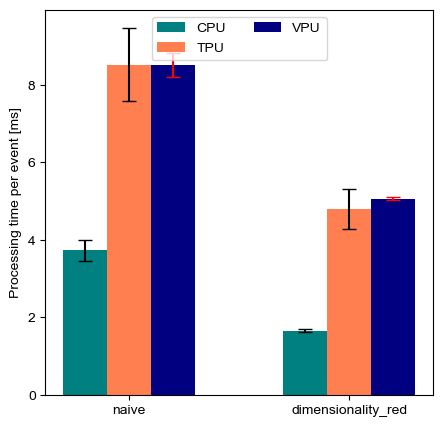

In [85]:
plt.rcParams.update({'font.sans-serif':'Arial'})

inception_data = {'names':['naive', 'dimensionality_red']}

inception_data['cpu_tf_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['cpu_ov_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['tpu_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_tpu_mean'][0]*1e3 for name in inception_data['names']]
inception_data['vpu_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_vpu_mean'][0]*1e3 for name in inception_data['names']]

inception_error_data = {'names':['naive', 'dimensionality_red']}

inception_error_data['cpu_tf_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['cpu_ov_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_cpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['tpu_data'] = [ pd.read_csv("inception_test/output_files_tpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_tpu_stdev'][0]*1e3 for name in inception_data['names']]
inception_error_data['vpu_data'] = [ pd.read_csv("inception_test/output_files_vpu/inception_" + str(name) + "/inception_" + str(name) + ".csv")['latency_vpu_stdev'][0]*1e3 for name in inception_data['names']]

inception_data['operations'] = [int(pd.read_csv("inception_test/vpu_models/inception_" + str(name) + "/op_stat.csv")['flops'].sum()) for name in inception_data['names']]

x_values = [ str(name) for name in inception_data['names']]


fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.subplots_adjust(wspace=0.3)
ax.set_ylabel("Processing time per event [ms]")
# ax[0].bar(np.arange(len(x_values)) - 0.15, inception_data['cpu_tf_data'], width=0.1, label='CPU (TF)', color='maroon')
ax.bar(np.arange(len(x_values)) - 0.2, inception_data['cpu_ov_data'], yerr=inception_error_data['cpu_ov_data'], width=0.2, label='CPU', color='teal', capsize=5)
ax.bar(np.arange(len(x_values)), inception_data['tpu_data'], yerr=inception_error_data['tpu_data'], width=0.2, label='TPU', color='coral', capsize=5)
ax.bar(np.arange(len(x_values)) + 0.2, inception_data['vpu_data'], yerr=inception_error_data['vpu_data'], width=0.2, label='VPU', color='navy', ecolor='red', capsize=5)
ax.set_xticks(np.arange(len(x_values)), x_values)
# ax[0].grid(linestyle='--')
ax.legend(ncol=2, loc="upper center")

fig.savefig("graphs/inception_layer_evaluation_time_only.pdf")

In [86]:
np.array(inception_data['tpu_data']), np.array(inception_error_data['tpu_data'])

(array([8.52109148, 4.8043731 ]), array([0.94336896, 0.52070388]))

In [87]:
np.array(inception_data['vpu_data']), np.array(inception_error_data['vpu_data'])

(array([8.51283182, 5.067455  ]), array([0.31936517, 0.03256966]))

In [88]:
np.array(inception_data['cpu_ov_data']), np.array(inception_error_data['cpu_ov_data'])

(array([3.72749907, 1.66124911]), array([0.27845013, 0.03051262]))

In [89]:
np.array(inception_data['operations'])*1e3/(np.array(inception_data['tpu_data']))

array([3.46519514e+10, 2.21937534e+10])

In [90]:
np.array(inception_data['operations'])*1e3/(np.array(inception_data['vpu_data']))

array([3.46855728e+10, 2.10415429e+10])

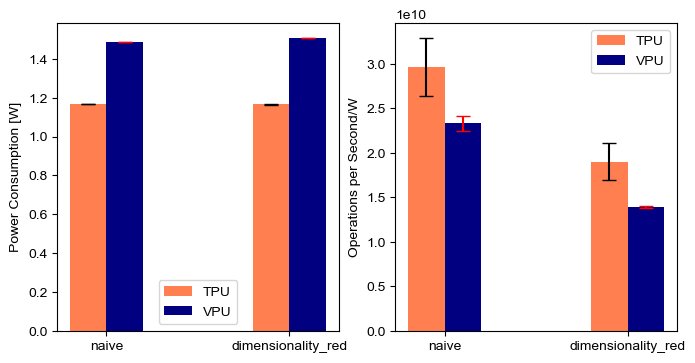

In [97]:
tpu_power_data = pd.read_csv("inception_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("inception_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(8,4))

x_values = inception_data['names']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax[0].bar(np.arange(len(x_values)) - 0.1, yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', width=0.2, capsize=5)
ax[0].bar(np.arange(len(x_values)) + 0.1, yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', width=0.2, capsize=5, ecolor='red')

ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(x_values)), x_values)
ax[0].legend()

ops_tpu = np.array(inception_data['operations'])*1e3/(np.array(inception_data['tpu_data']))
ops_tpu_error = np.array(inception_data['operations'])*1e3/(np.array(inception_data['tpu_data'])**2)*inception_error_data['tpu_data']

ops_vpu = np.array(inception_data['operations'])*1e3/(np.array(inception_data['vpu_data']))
ops_vpu_error = np.array(inception_data['operations'])*1e3/(np.array(inception_data['vpu_data'])**2)*inception_error_data['vpu_data']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu)
ops_w_tpu_error = np.sqrt((ops_tpu_error / np.array(yvalues_tpu))**2 + (ops_tpu*np.array(yerr_tpu) / np.array(yvalues_tpu)**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu)
ops_w_vpu_error = np.sqrt((ops_vpu_error / np.array(yvalues_vpu))**2 + (ops_vpu*np.array(yerr_tpu) / np.array(yvalues_vpu)**2)**2)

ax[1].bar(np.arange(len(x_values)) - 0.1, ops_w_tpu, yerr = ops_w_tpu_error, label='TPU', color='coral', width=0.2, capsize=5)
ax[1].bar(np.arange(len(x_values)) + 0.1, ops_w_vpu, yerr = ops_w_vpu_error, label='VPU', color='navy', width=0.2, capsize=5, ecolor='red')

# ax[1].set_title('Power Efficiency')
ax[1].set_ylabel('Operations per Second/W')
ax[1].set_xticks(range(len(x_values)), x_values)
ax[1].legend()

fig.savefig("graphs/inception_test_power_evaluation.pdf")

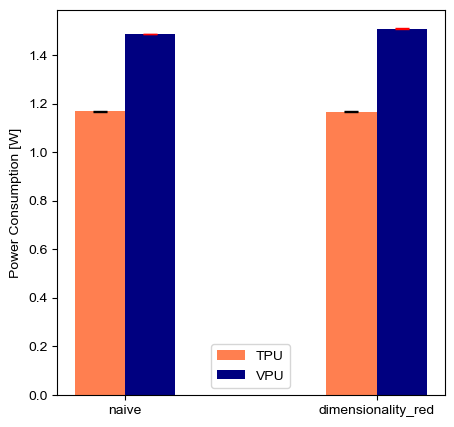

In [38]:
tpu_power_data = pd.read_csv("inception_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("inception_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,1,figsize=(5,5))

x_values = inception_data['names']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax.bar(np.arange(len(x_values)) - 0.1, yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', width=0.2, capsize=5)
ax.bar(np.arange(len(x_values)) + 0.1, yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', width=0.2, capsize=5, ecolor='red')

ax.set_ylabel('Power Consumption [W]')
ax.set_xticks(range(len(x_values)), x_values)
ax.legend()

fig.savefig("graphs/inception_test_power_evaluation_power_only.pdf")

In [39]:
yvalues_tpu, yerr_tpu

(array([1.16735484, 1.16609677]), array([0.00125295, 0.00175793]))

In [40]:
yvalues_vpu, yerr_vpu

(array([1.48703226, 1.50841935]), array([0.00653444, 0.00256612]))

In [62]:
ops_w_tpu, ops_w_vpu

(array([2.96841631e+10, 1.90325142e+10]),
 array([2.33253668e+10, 1.39493987e+10]))

## 7. Depth model

10 x 100 samples

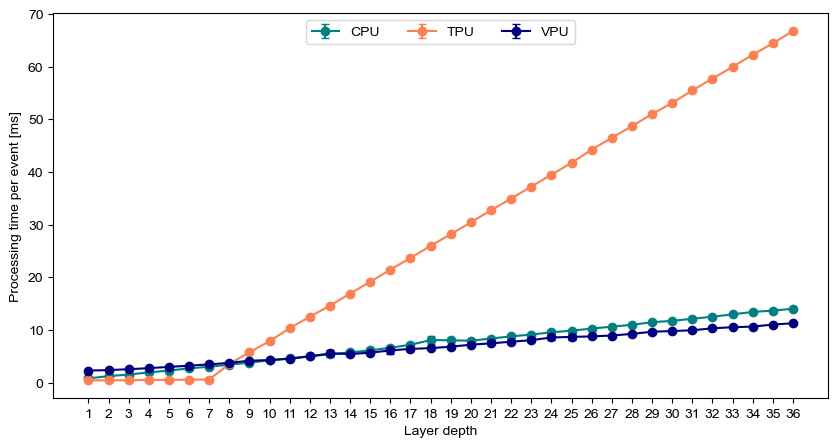

In [3]:
def linear_function(x,m,c):
    return m*x+c

plt.rcParams.update({'font.sans-serif':'Arial'})

depth_data = {'depth': [i for i in np.arange(1,37,1)]}

depth_data['cpu_tf_data'] = [ pd.read_csv("depth_1024_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['tpu_data'] = [ pd.read_csv("depth_1024_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['cpu_ov_data'] = [ pd.read_csv("depth_1024_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['vpu_data'] = [ pd.read_csv("depth_1024_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in depth_data['depth']]

depth_data['operations'] = [int(pd.read_csv("depth_1024_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]

depth_error_data = {'depth': [i for i in np.arange(1,37,1)]}

depth_error_data['cpu_tf_data'] = [ pd.read_csv("depth_1024_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['tpu_data'] = [ pd.read_csv("depth_1024_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['cpu_ov_data'] = [ pd.read_csv("depth_1024_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['vpu_data'] = [ pd.read_csv("depth_1024_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in depth_data['depth']]

depth_error_data['operations'] = [ int(pd.read_csv("depth_1024_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]

fig, ax = plt.subplots(1,1, figsize=(10,5))

x_values = [ str(size) for size in depth_data['depth'] ]

fig.suptitle('')

# popt_cpu_t, pcov_cpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['cpu_ov_data'])
# popt_tpu_t, pcov_tpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['tpu_data'])
# popt_vpu_t, pcov_vpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['vpu_data'])

ax.errorbar(np.arange(len(x_values)), depth_data['cpu_ov_data'], yerr = depth_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), depth_data['tpu_data'], yerr = depth_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), depth_data['vpu_data'], yerr = depth_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=3)

# ax.plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_cpu_t), color='teal', alpha=0.5)
# ax.plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_tpu_t), color='coral', alpha=0.5)
# ax.plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_vpu_t), color='navy', alpha=0.5)

# ax.text(x=12, y=1.5, s=f'Gradient : {round(popt_cpu_t[0],4)} ms/layer', color='teal')
# ax.text(x=12, y=0.8, s=f'Gradient : {round(popt_tpu_t[0],4)} ms/layer', color='coral')
# ax.text(x=12, y=2.5, s=f'Gradient : {round(popt_vpu_t[0],4)} ms/layer', color='navy')

ax.set_xticks(np.arange(len(x_values)), x_values)
ax.set_xlabel('Layer depth')
ax.set_ylabel('Processing time per event [ms]')
ax.legend(ncol=4, loc="upper center")

# fig.savefig("graphs/depth_dense.pdf")

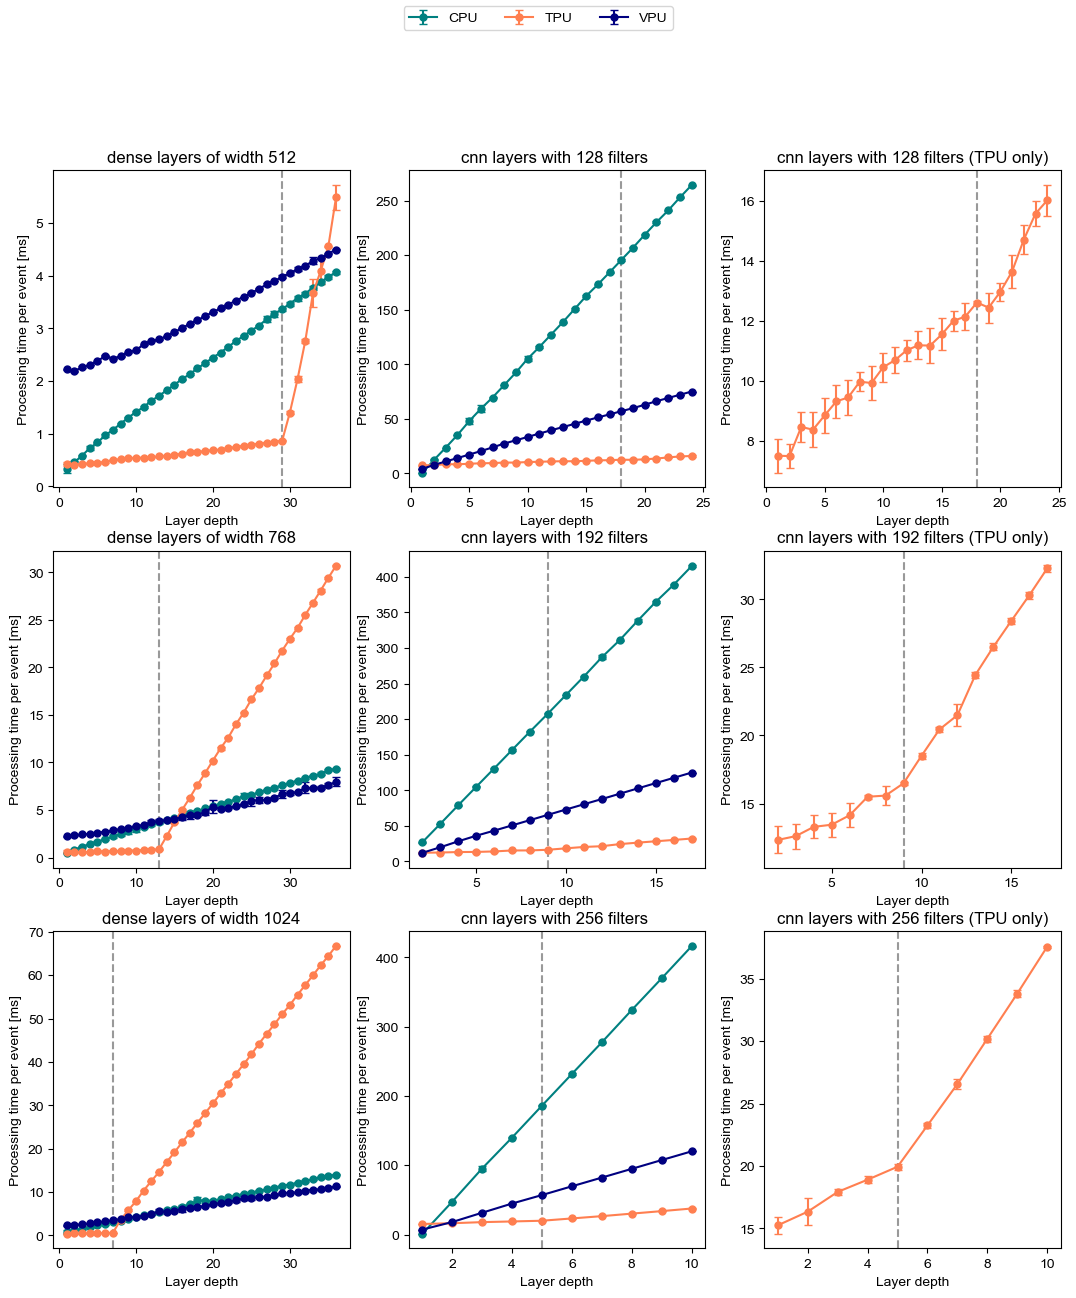

In [4]:
plt.rcParams.update({'font.sans-serif':'Arial'})

def get_depth_data(width, cnn=False):
    
    if cnn == True:
        if width == 128:
            depth_data = {'depth': [i for i in np.arange(1,25,1)]}
        elif width == 192:
            depth_data = {'depth': [i for i in np.arange(2,18,1)]}
        elif width == 256:
            depth_data = {'depth': [i for i in np.arange(1,11,1)]}
        
    else:
        depth_data = {'depth': [i for i in np.arange(1,37,1)]}
        
    if cnn == True:
        depth_data['cpu_tf_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_tpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['tpu_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_tpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['cpu_ov_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_vpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['vpu_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_vpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in depth_data['depth']]

        depth_data['operations'] = [int(pd.read_csv("depth_cnn_" + str(width) + "_test/vpu_models/depth_conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]
    else:
        depth_data['cpu_tf_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['tpu_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['cpu_ov_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
        depth_data['vpu_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in depth_data['depth']]

        depth_data['operations'] = [int(pd.read_csv("depth_" + str(width) + "_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]
    
    depth_error_data = {}
    depth_error_data['depth']  = depth_data['depth']
    
    if cnn == True:
        depth_error_data['cpu_tf_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_tpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['tpu_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_tpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['cpu_ov_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_vpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['vpu_data'] = [ pd.read_csv("depth_cnn_" + str(width) + "_test/output_files_vpu/depth_conv2d_" + str(size) + "/depth_conv2d_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in depth_data['depth']]

        depth_error_data['operations'] = [ int(pd.read_csv("depth_cnn_" + str(width) + "_test/vpu_models/depth_conv2d_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]
    
    else:
        depth_error_data['cpu_tf_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['tpu_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['cpu_ov_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
        depth_error_data['vpu_data'] = [ pd.read_csv("depth_" + str(width) + "_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in depth_data['depth']]

        depth_error_data['operations'] = [ int(pd.read_csv("depth_" + str(width) + "_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]
    
    return {'values': depth_data, 'errors': depth_error_data}

dense_widths = [512, 768, 1024]

fig, ax = plt.subplots(3,3, figsize=(13,14))

for i in range(len(dense_widths)):
    
    width = dense_widths[i]
    
    ax[i,0].set_title("dense layers of width " + str(width))
    ax[i,0].errorbar(get_depth_data(width)['values']['depth'], get_depth_data(width)['values']['cpu_ov_data'], yerr = get_depth_data(width)['errors']['cpu_ov_data'], label='CPU', color='teal', fmt='-o', ms=5, capsize=3)
    ax[i,0].errorbar(get_depth_data(width)['values']['depth'], get_depth_data(width)['values']['tpu_data'], yerr = get_depth_data(width)['errors']['tpu_data'], label='TPU', color='coral', fmt='-o', ms=5, capsize=3)
    ax[i,0].errorbar(get_depth_data(width)['values']['depth'], get_depth_data(width)['values']['vpu_data'], yerr = get_depth_data(width)['errors']['vpu_data'], label='VPU', color='navy', fmt='-o', ms=5, capsize=3)
    ax[i,0].set_xlabel('Layer depth')
    ax[i,0].set_ylabel('Processing time per event [ms]')
    
    
cnn_filters = [128, 192 ,256]

for i in range(len(cnn_filters)):
    
    width = cnn_filters[i]
    
    ax[i,1].set_title("cnn layers with " + str(width) + " filters ")
    ax[i,1].errorbar(get_depth_data(width, True)['values']['depth'], get_depth_data(width, True)['values']['cpu_ov_data'], yerr = get_depth_data(width, True)['errors']['cpu_ov_data'], label='CPU', color='teal', fmt='-o', ms=5, capsize=3)
    ax[i,1].errorbar(get_depth_data(width, True)['values']['depth'], get_depth_data(width, True)['values']['tpu_data'], yerr = get_depth_data(width, True)['errors']['tpu_data'], label='TPU', color='coral', fmt='-o', ms=5, capsize=3)
    ax[i,1].errorbar(get_depth_data(width, True)['values']['depth'], get_depth_data(width, True)['values']['vpu_data'], yerr = get_depth_data(width, True)['errors']['vpu_data'], label='VPU', color='navy', fmt='-o', ms=5, capsize=3)
    ax[i,1].set_xlabel('Layer depth')
    ax[i,1].set_ylabel('Processing time per event [ms]')
    
    
    ax[i,2].set_title("cnn layers with " + str(width) + " filters (TPU only)")
    ax[i,2].errorbar(get_depth_data(width, True)['values']['depth'], get_depth_data(width, True)['values']['tpu_data'], yerr = get_depth_data(width, True)['errors']['tpu_data'], label='TPU', color='coral', fmt='-o', ms=5, capsize=3)
    ax[i,2].set_xlabel('Layer depth')
    ax[i,2].set_ylabel('Processing time per event [ms]')


ax[1,1].set_xticks([i for i in np.arange(5,20,5)])
ax[1,2].set_xticks([i for i in np.arange(5,20,5)])

# vertical lines
ax[0,0].axvline(x=29, color='grey', linestyle='--', alpha = 0.8)
ax[1,0].axvline(x=13, color='grey', linestyle='--', alpha = 0.8)
ax[2,0].axvline(x=7, color='grey', linestyle='--', alpha = 0.8)

ax[0,1].axvline(x=18, color='grey', linestyle='--', alpha = 0.8)
ax[1,1].axvline(x=9, color='grey', linestyle='--', alpha = 0.8)
ax[2,1].axvline(x=5, color='grey', linestyle='--', alpha = 0.8)

ax[0,2].axvline(x=18, color='grey', linestyle='--', alpha = 0.8)
ax[1,2].axvline(x=9, color='grey', linestyle='--', alpha = 0.8)
ax[2,2].axvline(x=5, color='grey', linestyle='--', alpha = 0.8)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(*ax[0,0].get_legend_handles_labels(), loc='upper center', ncol=4)

fig.savefig("graphs/depth_dense_and_cnn.pdf",bbox_inches="tight", pad_inches=0)

In [18]:
(get_depth_data(512)['values']['tpu_data'][-1] - get_depth_data(512)['values']['tpu_data'][-3])/(get_depth_data(512)['values']['depth'][-1] - get_depth_data(512)['values']['depth'][-3])

0.69896463155745

In [15]:
(get_depth_data(768)['values']['tpu_data'][-1] - get_depth_data(768)['values']['tpu_data'][-2])/(get_depth_data(768)['values']['depth'][-1] - get_depth_data(768)['values']['depth'][-2])

1.2782175540924001

In [16]:
(get_depth_data(1024)['values']['tpu_data'][-1] - get_depth_data(1024)['values']['tpu_data'][-2])/(get_depth_data(1024)['values']['depth'][-1] - get_depth_data(1024)['values']['depth'][-2])

2.335482120513916

In [13]:
(get_depth_data(256, True)['values']['tpu_data'][-1] - get_depth_data(256, True)['values']['tpu_data'][-2])/(get_depth_data(256, True)['values']['depth'][-1] - get_depth_data(256, True)['values']['depth'][-2])

3.756584856510095

In [12]:
(get_depth_data(128, True)['values']['tpu_data'][-1] - get_depth_data(128, True)['values']['tpu_data'][-2])/(get_depth_data(128, True)['values']['depth'][-1] - get_depth_data(128, True)['values']['depth'][-2])

0.4414869332312996

In [14]:
(get_depth_data(192, True)['values']['tpu_data'][-1] - get_depth_data(192, True)['values']['tpu_data'][-2])/(get_depth_data(192, True)['values']['depth'][-1] - get_depth_data(192, True)['values']['depth'][-2])

1.9791814565657972

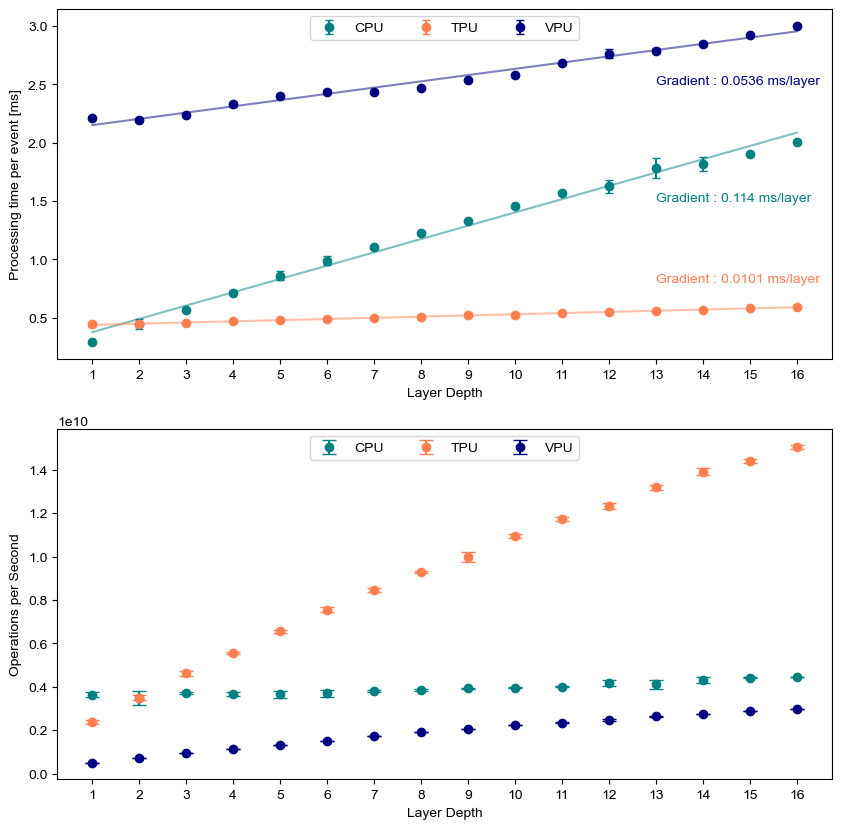

In [32]:
def linear_function(x,m,c):
    return m*x+c

plt.rcParams.update({'font.sans-serif':'Arial'})

depth_data = {'depth': [i for i in np.arange(1,17,1)]}

depth_data['cpu_tf_data'] = [ pd.read_csv("depth_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['tpu_data'] = [ pd.read_csv("depth_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['cpu_ov_data'] = [ pd.read_csv("depth_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in depth_data['depth']]
depth_data['vpu_data'] = [ pd.read_csv("depth_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in depth_data['depth']]

depth_data['operations'] = [int(pd.read_csv("depth_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]

depth_error_data = {'kernel_sizes': [3,5,7,9,11,13,15,17,19,21,23]}

depth_error_data['cpu_tf_data'] = [ pd.read_csv("depth_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['tpu_data'] = [ pd.read_csv("depth_test/output_files_tpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['cpu_ov_data'] = [ pd.read_csv("depth_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in depth_data['depth']]
depth_error_data['vpu_data'] = [ pd.read_csv("depth_test/output_files_vpu/depth_" + str(size) + "/depth_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in depth_data['depth']]

depth_error_data['operations'] = [ int(pd.read_csv("depth_test/vpu_models/depth_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in depth_data['depth']]

fig, ax = plt.subplots(2,1, figsize=(10,10))

x_values = [ str(size) for size in depth_data['depth'] ]

fig.suptitle('')

popt_cpu_t, pcov_cpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['cpu_ov_data'])
popt_tpu_t, pcov_tpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['tpu_data'])
popt_vpu_t, pcov_vpu_t = curve_fit(linear_function, np.arange(len(x_values)), depth_data['vpu_data'])

ax[0].errorbar(np.arange(len(x_values)), depth_data['cpu_ov_data'], yerr = depth_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='o', capsize=3)
ax[0].errorbar(np.arange(len(x_values)), depth_data['tpu_data'], yerr = depth_error_data['tpu_data'], label='TPU', color='coral', fmt='o', capsize=3)
ax[0].errorbar(np.arange(len(x_values)), depth_data['vpu_data'], yerr = depth_error_data['vpu_data'], label='VPU', color='navy', fmt='o', capsize=3)

ax[0].plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_cpu_t), color='teal', alpha=0.5)
ax[0].plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_tpu_t), color='coral', alpha=0.5)
ax[0].plot(np.arange(len(x_values)), linear_function(np.arange(len(x_values)), *popt_vpu_t), color='navy', alpha=0.5)

ax[0].set_xticks(np.arange(len(x_values)), x_values)
ax[0].set_xlabel('Layer Depth')
ax[0].set_ylabel('Processing time per event [ms]')
ax[0].legend(ncol=4, loc="upper center")

ax[0].text(x=12, y=1.5, s=f'Gradient : {round(popt_cpu_t[0],4)} ms/layer', color='teal')
ax[0].text(x=12, y=0.8, s=f'Gradient : {round(popt_tpu_t[0],4)} ms/layer', color='coral')
ax[0].text(x=12, y=2.5, s=f'Gradient : {round(popt_vpu_t[0],4)} ms/layer', color='navy')

ax[1].errorbar(np.arange(len(x_values)), np.array(depth_data['operations'])*1e3/(np.array(depth_data['cpu_ov_data'])), yerr=np.array(depth_data['operations'])*1e3/(np.array(depth_data['cpu_ov_data'])**2)*depth_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(depth_data['operations'])*1e3/(np.array(depth_data['tpu_data'])), yerr=np.array(depth_data['operations'])*1e3/(np.array(depth_data['tpu_data'])**2)*depth_error_data['tpu_data'], label='TPU', color='coral', fmt='o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), np.array(depth_data['operations'])*1e3/(np.array(depth_data['vpu_data'])), yerr=np.array(depth_data['operations'])*1e3/(np.array(depth_data['vpu_data'])**2)*depth_error_data['vpu_data'], label='VPU', color='navy', fmt='o', capsize=5)

ax[1].set_xticks(np.arange(len(x_values)), x_values)
ax[1].set_xlabel('Layer Depth')
ax[1].set_ylabel('Operations per Second')
ax[1].legend(ncol=4, loc="upper center")

fig.savefig("graphs/depth_dense_w_flops.pdf")

In [4]:
tpu_power_data = pd.read_csv("depth_test/power_meas_usb/power_measurements_tpu.csv")

vpu_power_data = pd.read_csv("depth_test/power_meas_usb/power_measurements_vpu.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(2,1,figsize=(10,10))

fig.suptitle("")

x_values = depth_data['depth']

yvalues_tpu = tpu_power_data.mean()[1:].values
yerr_tpu = tpu_power_data.std()[1:].values

yvalues_vpu = vpu_power_data.mean()[1:].values
yerr_vpu = vpu_power_data.std()[1:].values

ax[0].errorbar(np.arange(len(x_values)), yvalues_tpu, yerr = yerr_tpu, label='TPU', color='coral', fmt='-o', capsize=5)
ax[0].errorbar(np.arange(len(x_values)), yvalues_vpu, yerr = yerr_tpu, label='VPU', color='navy', fmt='-o', capsize=5)

ax[0].set_title('')
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(x_values)), x_values)
ax[0].legend()

ops_tpu = np.array(depth_data['operations'])*1e3/(np.array(depth_data['tpu_data']))
ops_tpu_error = np.array(depth_data['operations'])*1e3/(np.array(depth_data['tpu_data'])**2)*depth_error_data['tpu_data']

ops_vpu = np.array(depth_data['operations'])*1e3/(np.array(depth_data['vpu_data']))
ops_vpu_error = np.array(depth_data['operations'])*1e3/(np.array(depth_data['vpu_data'])**2)*depth_error_data['vpu_data']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu)
ops_w_tpu_error = np.sqrt((ops_tpu_error / np.array(yvalues_tpu))**2 + (ops_tpu*np.array(yerr_tpu) / np.array(yvalues_tpu)**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu)
ops_w_vpu_error = np.sqrt((ops_vpu_error / np.array(yvalues_vpu))**2 + (ops_vpu*np.array(yerr_tpu) / np.array(yvalues_vpu)**2)**2)

ax[1].errorbar(np.arange(len(x_values)), ops_w_tpu, yerr = ops_w_tpu_error, label='TPU', color='coral', fmt='-o', capsize=5)
ax[1].errorbar(np.arange(len(x_values)), ops_w_vpu, yerr = ops_w_vpu_error, label='VPU', color='navy', fmt='-o', capsize=5)

ax[1].set_title('Power Efficiency')
ax[1].set_ylabel('OPS/W')
ax[1].set_xticks(range(len(x_values)), x_values)
ax[1].legend()

fig.savefig("graphs/depth_dense_power.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'depth_test/power_meas_usb/power_measurements_tpu.csv'

## 8. Angle and PID models, in general

10x10000 samples

[1000. 1000.]


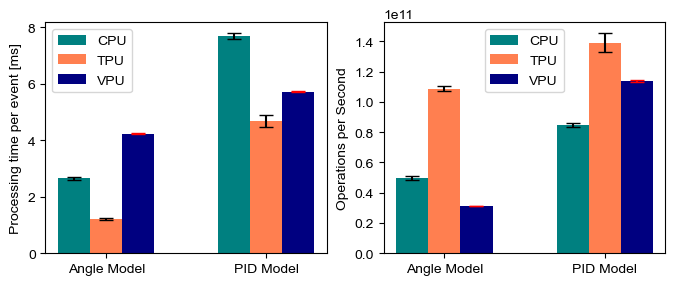

In [51]:
plt.rcParams.update({'font.sans-serif':'Arial'})

benchmarks_proctime = {'names':['Angle Model', 'PID Model'],
                'cpu_tf': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3],
                'tpu': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_tpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3],
                'cpu_ov': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3],
                  'vpu': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_vpu_mean'][0]*1e3,
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3]}

benchmarks_error_proctime = {'names':['Angle Model', 'PID Model'],
                        'tpu': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_tpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3],
                    'cpu_ov': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_cpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3],
                      'vpu': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_vpu_stdev'][0]*1e3,
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3]}

benchmarks_operations = [132072000, 651083000]

fig, ax = plt.subplots(1,2,figsize=(8,3))


ax[0].bar(np.arange(len(benchmarks_proctime['names'])) - 0.2, benchmarks_proctime['cpu_ov'], yerr=benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
ax[0].bar(np.arange(len(benchmarks_proctime['names'])), benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
ax[0].bar(np.arange(len(benchmarks_proctime['names'])) + 0.2, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
ax[0].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
ax[0].set_ylabel("Processing time per event [ms]")
ax[0].legend()

print(np.array(benchmarks_proctime['cpu_tf']))


ax[1].bar(np.arange(len(benchmarks_proctime['names']))-0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])), yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])**2)*benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
ax[1].bar(np.arange(len(benchmarks_proctime['names'])), np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])), color='coral', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])**2)*benchmarks_error_proctime['tpu'], label='TPU', width=0.2, capsize=5)
ax[1].bar(np.arange(len(benchmarks_proctime['names']))+0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])), color='navy', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])**2)*benchmarks_error_proctime['vpu'], label='VPU', width=0.2, ecolor='red', capsize=5)
ax[1].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
ax[1].set_ylabel("Operations per Second")
ax[1].legend()


fig.savefig("graphs/angle_pid_evaluation.pdf")

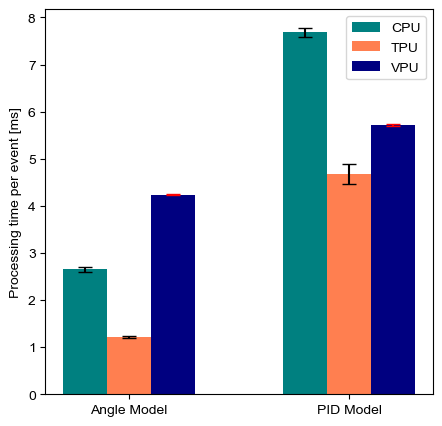

In [23]:
plt.rcParams.update({'font.sans-serif':'Arial'})

benchmarks_proctime = {'names':['Angle Model', 'PID Model'],
                'cpu_tf': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3],
                'tpu': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_tpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3],
                'cpu_ov': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3],
                  'vpu': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_vpu_mean'][0]*1e3,
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3]}

benchmarks_error_proctime = {'names':['Angle Model', 'PID Model'],
                        'tpu': [pd.read_csv("angle_test/model_py/output_files/angle_tpu/angle_tpu.csv")['latency_tpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3],
                    'cpu_ov': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_cpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3],
                      'vpu': [pd.read_csv("angle_test/model_py/output_files/angle_vpu/angle_vpu.csv")['latency_vpu_stdev'][0]*1e3,
                         pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3]}

benchmarks_operations = [132072000, 651083000]

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.bar(np.arange(len(benchmarks_proctime['names'])) - 0.2, benchmarks_proctime['cpu_ov'], yerr=benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
ax.bar(np.arange(len(benchmarks_proctime['names'])), benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
ax.bar(np.arange(len(benchmarks_proctime['names'])) + 0.2, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
ax.set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
ax.set_ylabel("Processing time per event [ms]")
ax.legend()

fig.savefig("graphs/angle_pid_evaluation_time_only.pdf")

In [24]:
np.array(benchmarks_proctime['tpu']), np.array(benchmarks_error_proctime['tpu'])

(array([1.21353183, 4.68166132]), array([0.02116075, 0.21135004]))

In [27]:
np.array(benchmarks_proctime['vpu']), np.array(benchmarks_error_proctime['vpu'])

(array([4.23456552, 5.72052053]), array([0.01059394, 0.02748476]))

In [26]:
np.array(benchmarks_proctime['cpu_ov']), np.array(benchmarks_error_proctime['cpu_ov'])

(array([2.65391623, 7.68703797]), array([0.05651935, 0.09662023]))

In [64]:
np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])), np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu']))

(array([1.08832745e+11, 1.39070931e+11]),
 array([3.11890321e+10, 1.13815342e+11]))

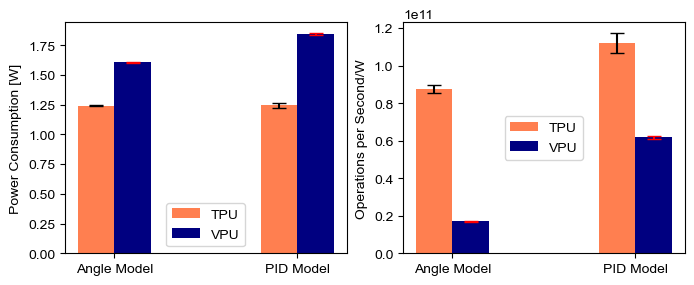

In [52]:
angle_power_data = pd.read_csv("angle_test/model_py/power_meas_usb/power_measurements.csv")

pid_power_data = pd.read_csv("pid_test/model_py/power_meas_usb/power_measurements.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(8,3))

xlabels = ['Angle Model', 'PID Model']

yvalues_tpu = [angle_power_data['power_tpu_inference [W]'].mean(), pid_power_data['power_tpu_inference [W]'].mean()]
yerr_tpu = [angle_power_data['power_tpu_inference [W]'].std(), pid_power_data['power_tpu_inference [W]'].std()]

yvalues_vpu = [angle_power_data['power_vpu_inference [W]'].mean(), pid_power_data['power_vpu_inference [W]'].mean()]
yerr_vpu = [angle_power_data['power_vpu_inference [W]'].std(), pid_power_data['power_vpu_inference [W]'].std()]

ax[0].bar(np.arange(len(xlabels)) - 0.1, yvalues_tpu, yerr=yerr_tpu, width=0.2, label='TPU', color='coral', capsize=5)
ax[0].bar(np.arange(len(xlabels)) + 0.1, yvalues_vpu, yerr=yerr_vpu, width=0.2, label='VPU', color='navy', capsize=5, ecolor='red')

# ax[0].set_title('Power')
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(xlabels)), xlabels)
ax[0].legend()

xlabels_efficiency = ['Angle Model', 'PID Model']

ops_tpu = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu']))
ops_tpu_error = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])**2)*benchmarks_error_proctime['tpu']

ops_vpu = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu']))
ops_vpu_error = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])**2)*benchmarks_error_proctime['vpu']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu[1:])
ops_w_tpu_error = np.sqrt( (ops_tpu_error / np.array(yvalues_tpu[1:]))**2 + (ops_tpu*np.array(yerr_tpu[1:]) / np.array(yvalues_tpu[1:])**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu[1:])
ops_w_vpu_error = np.sqrt( (ops_vpu_error / np.array(yvalues_vpu[1:]))**2 + (ops_vpu*np.array(yerr_tpu[1:]) / np.array(yvalues_vpu[1:])**2)**2)

ax[1].bar(np.arange(len(benchmarks_proctime['names'])) - 0.1, ops_w_tpu, yerr=ops_w_tpu_error, label='TPU', color='coral', width=0.2, capsize=5)
ax[1].bar(np.arange(len(benchmarks_proctime['names'])) + 0.1, ops_w_vpu, yerr=ops_w_vpu_error, label='VPU', color='navy', width=0.2, ecolor='red', capsize=5)

# ax[1].set_title('Efficiency')
ax[1].set_ylabel('Operations per Second/W')
ax[1].set_xticks(range(len(xlabels_efficiency)), xlabels_efficiency)
ax[1].legend()

fig.savefig("graphs/angle_pid_power_evaluation.pdf")

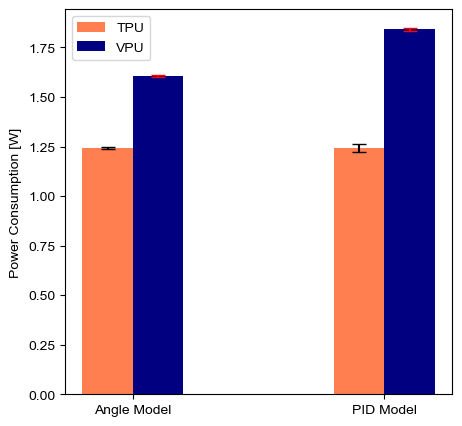

In [41]:
angle_power_data = pd.read_csv("angle_test/model_py/power_meas_usb/power_measurements.csv")

pid_power_data = pd.read_csv("pid_test/model_py/power_meas_usb/power_measurements.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,1,figsize=(5,5))

xlabels = ['Angle Model', 'PID Model']

yvalues_tpu = [angle_power_data['power_tpu_inference [W]'].mean(), pid_power_data['power_tpu_inference [W]'].mean()]
yerr_tpu = [angle_power_data['power_tpu_inference [W]'].std(), pid_power_data['power_tpu_inference [W]'].std()]

yvalues_vpu = [angle_power_data['power_vpu_inference [W]'].mean(), pid_power_data['power_vpu_inference [W]'].mean()]
yerr_vpu = [angle_power_data['power_vpu_inference [W]'].std(), pid_power_data['power_vpu_inference [W]'].std()]

ax.bar(np.arange(len(xlabels)) - 0.1, yvalues_tpu, yerr=yerr_tpu, width=0.2, label='TPU', color='coral', capsize=5)
ax.bar(np.arange(len(xlabels)) + 0.1, yvalues_vpu, yerr=yerr_vpu, width=0.2, label='VPU', color='navy', capsize=5, ecolor='red')

# ax[0].set_title('Power')
ax.set_ylabel('Power Consumption [W]')
ax.set_xticks(range(len(xlabels)), xlabels)
ax.legend()

fig.savefig("graphs/angle_pid_power_evaluation_power_only.pdf")

In [44]:
yvalues_tpu, yerr_tpu

([1.2402380952380954, 1.2429032258064514],
 [0.0051176631571915885, 0.018977802540002135])

In [45]:
yvalues_vpu, yerr_vpu

([1.6047741935483868, 1.8413870967741937],
 [0.003955668316221284, 0.008689754194278993])

## 9. Optimized PID Model

In [20]:
int(pd.read_csv("pid_optimized_test/vpu_models/optimized_model/op_stat.csv")['flops'].sum())

650101146

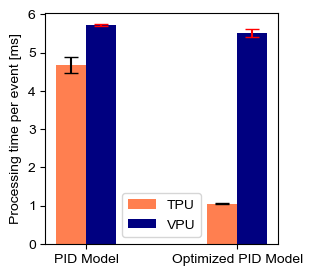

In [47]:
plt.rcParams.update({'font.sans-serif':'Arial'})

benchmarks_proctime = {'names':['PID Model', 'Optimized PID Model'],
                'cpu_tf': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_test/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3],
                'tpu': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_test/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3],
                'cpu_ov': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_test/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3],
                  'vpu': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3,
                         pd.read_csv("pid_optimized_test/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3]}

benchmarks_error_proctime = {'names':['PID Model', 'Optimized PID Model'],
                        'tpu': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_optimized_test/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3],
                    'cpu_ov': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_optimized_test/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3],
                      'vpu': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3,
                         pd.read_csv("pid_optimized_test/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3]}

benchmarks_operations = [651083000, 
                         int(pd.read_csv("pid_optimized_test/vpu_models/optimized_model/op_stat.csv")['flops'].sum())]

# fig, ax = plt.subplots(1,2,figsize=(10,5))

# fig.suptitle("Benchmark evaluations")


# ax[0].bar(np.arange(len(benchmarks_proctime['names'])) - 0.2, benchmarks_proctime['cpu_ov'], yerr=benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
# ax[0].bar(np.arange(len(benchmarks_proctime['names'])), benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
# ax[0].bar(np.arange(len(benchmarks_proctime['names'])) + 0.2, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
# ax[0].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
# ax[0].set_ylabel("Processing time per event [ms]")
# ax[0].legend()


#ax[1].bar(np.arange(len(benchmarks_proctime['names']))-0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])), yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])**2)*benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
#ax[1].bar(np.arange(len(benchmarks_proctime['names'])), np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])), color='coral', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])**2)*benchmarks_error_proctime['tpu'], label='TPU', width=0.2, capsize=5)
#ax[1].bar(np.arange(len(benchmarks_proctime['names']))+0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])), color='navy', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])**2)*benchmarks_error_proctime['vpu'], label='VPU', width=0.2, ecolor='red', capsize=5)
#ax[1].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
#ax[1].set_ylabel("Operations per Second")
#ax[1].legend()

fig, ax = plt.subplots(1,1,figsize=(3,3))

ax.bar(np.arange(len(benchmarks_proctime['names'])) - 0.1, benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
ax.bar(np.arange(len(benchmarks_proctime['names'])) + 0.1, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
ax.set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
ax.set_ylabel("Processing time per event [ms]")
ax.legend()


fig.savefig("graphs/pid_optimization_performance.pdf")

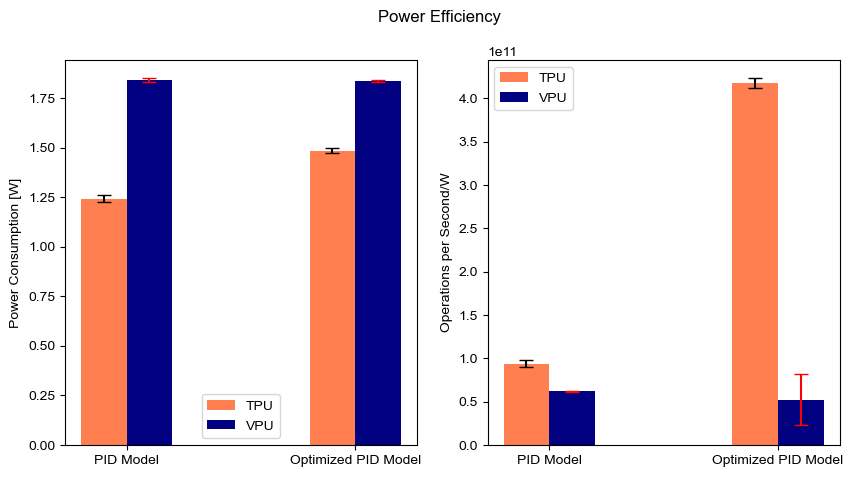

In [18]:
pid_power_data = pd.read_csv("pid_test/model_py/power_meas_usb/power_measurements.csv")

pidopt_power_data = pd.read_csv("pid_optimized_test/power_meas_usb/power_measurements.csv")

plt.rcParams.update({'font.sans-serif':'Arial'})

fig, ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Power Efficiency")

xlabels = ['PID Model', 'Optimized PID Model']

yvalues_tpu = [pid_power_data['power_tpu_inference [W]'].mean(), pidopt_power_data['power_tpu_inference [W]'].mean()]
yerr_tpu = [pid_power_data['power_tpu_inference [W]'].std(), pidopt_power_data['power_tpu_inference [W]'].std()]

yvalues_vpu = [pid_power_data['power_vpu_inference [W]'].mean(), pidopt_power_data['power_vpu_inference [W]'].mean()]
yerr_vpu = [pid_power_data['power_vpu_inference [W]'].std(), pidopt_power_data['power_vpu_inference [W]'].std()]

ax[0].bar(np.arange(len(xlabels)) - 0.1, yvalues_tpu, yerr=yerr_tpu, width=0.2, label='TPU', color='coral', capsize=5)
ax[0].bar(np.arange(len(xlabels)) + 0.1, yvalues_vpu, yerr=yerr_vpu, width=0.2, label='VPU', color='navy', capsize=5, ecolor='red')

# ax[0].set_title('Power')
ax[0].set_ylabel('Power Consumption [W]')
ax[0].set_xticks(range(len(xlabels)), xlabels)
ax[0].legend()

xlabels_efficiency = ['PID Model', 'Optimized PID Model']

ops_tpu = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu']))
ops_tpu_error = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])**2)*benchmarks_error_proctime['tpu']

ops_vpu = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu']))
ops_vpu_error = np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])**2)*benchmarks_error_proctime['vpu']

ops_w_tpu = ops_tpu / np.array(yvalues_tpu[1:])
ops_w_tpu_error = np.sqrt( (ops_tpu_error / np.array(yvalues_tpu[1:]))**2 + (ops_tpu*np.array(yerr_tpu[1:]) / np.array(yvalues_tpu[1:])**2)**2)

ops_w_vpu = ops_vpu / np.array(yvalues_vpu[1:])
ops_w_vpu_error = np.sqrt( (ops_vpu_error / np.array(yvalues_vpu[1:]))**2 + (ops_vpu*np.array(yerr_tpu[1:]) / np.array(yvalues_vpu[1:])**2)**2)

ax[1].bar(np.arange(len(benchmarks_proctime['names'])) - 0.1, ops_w_tpu, yerr=ops_w_tpu_error, label='TPU', color='coral', width=0.2, capsize=5)
ax[1].bar(np.arange(len(benchmarks_proctime['names'])) + 0.1, ops_w_vpu, yerr=ops_w_vpu_error, label='VPU', color='navy', width=0.2, ecolor='red', capsize=5)

# ax[1].set_title('Efficiency')
ax[1].set_ylabel('Operations per Second/W')
ax[1].set_xticks(range(len(xlabels_efficiency)), xlabels_efficiency)
ax[1].legend()

fig.savefig("graphs/pid_optimization_power_evaluation.pdf")

In [66]:
ops_w_tpu, ops_w_vpu

(array([8.75633296e+10, 1.11892003e+11]),
 array([1.69377923e+10, 6.18095685e+10]))

In [24]:
angle_power_data['power_tpu_idle [W]'].mean()

0.3691612903225806

In [25]:
angle_power_data['power_tpu_idle [W]'].std()

0.0003738782505529834

In [26]:
angle_power_data['power_vpu_idle [W]'].mean()

0.6408387096774193

In [27]:
angle_power_data['power_vpu_idle [W]'].std()

0.0007787500323616216

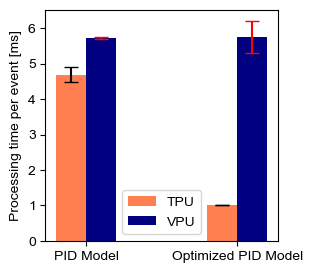

In [46]:
plt.rcParams.update({'font.sans-serif':'Arial'})

benchmarks_proctime = {'names':['PID Model', 'Optimized PID Model'],
                'cpu_tf': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_tpu/pid_tpu.csv")['latency_cpu_mean'][0]*1e3],
                'tpu': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_mean'][0]*1e3],
                'cpu_ov': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3, 
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_mean'][0]*1e3],
                  'vpu': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3,
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_mean'][0]*1e3]}

benchmarks_error_proctime = {'names':['PID Model', 'Optimized PID Model'],
                        'tpu': [pd.read_csv("pid_test/model_py/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_tpu/pid_tpu.csv")['latency_tpu_stdev'][0]*1e3],
                    'cpu_ov': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3, 
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_vpu/pid_vpu.csv")['latency_cpu_stdev'][0]*1e3],
                      'vpu': [pd.read_csv("pid_test/model_py/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3,
                         pd.read_csv("pid_optimized_vpu_test/output_files/pid_vpu/pid_vpu.csv")['latency_vpu_stdev'][0]*1e3]}

benchmarks_operations = [651083000, 
                         int(pd.read_csv("pid_optimized_vpu_test/vpu_models/optimized_model/op_stat.csv")['flops'].sum())]

# fig, ax = plt.subplots(1,2,figsize=(10,5))

# fig.suptitle("Benchmark evaluations")


# ax[0].bar(np.arange(len(benchmarks_proctime['names'])) - 0.2, benchmarks_proctime['cpu_ov'], yerr=benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
# ax[0].bar(np.arange(len(benchmarks_proctime['names'])), benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
# ax[0].bar(np.arange(len(benchmarks_proctime['names'])) + 0.2, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
# ax[0].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
# ax[0].set_ylabel("Processing time per event [ms]")
# ax[0].legend()

# print(np.array(benchmarks_proctime['cpu_tf']))


# ax[1].bar(np.arange(len(benchmarks_proctime['names']))-0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])), yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['cpu_ov'])**2)*benchmarks_error_proctime['cpu_ov'], color='teal', label='CPU', width=0.2, capsize=5)
# ax[1].bar(np.arange(len(benchmarks_proctime['names'])), np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])), color='coral', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['tpu'])**2)*benchmarks_error_proctime['tpu'], label='TPU', width=0.2, capsize=5)
# ax[1].bar(np.arange(len(benchmarks_proctime['names']))+0.2, np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])), color='navy', yerr=np.array(benchmarks_operations)*1e3/(np.array(benchmarks_proctime['vpu'])**2)*benchmarks_error_proctime['vpu'], label='VPU', width=0.2, ecolor='red', capsize=5)
# ax[1].set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
# ax[1].set_ylabel("Operations per Second")
# ax[1].legend()

fig, ax = plt.subplots(1,1,figsize=(3,3))

ax.bar(np.arange(len(benchmarks_proctime['names'])) - 0.1, benchmarks_proctime['tpu'], yerr=benchmarks_error_proctime['tpu'], color='coral', label='TPU', width=0.2, capsize=5)
ax.bar(np.arange(len(benchmarks_proctime['names'])) + 0.1, benchmarks_proctime['vpu'], yerr=benchmarks_error_proctime['vpu'], color='navy', label='VPU', width=0.2, ecolor='red', capsize=5)
ax.set_xticks(range(len(benchmarks_proctime['names'])), benchmarks_proctime['names'])
ax.set_ylabel("Processing time per event [ms]")
ax.legend()


fig.savefig("graphs/pid_vpu_optimization_performance.pdf")

## 10. Sparsity PID & VGG16 Model

10 x 10000

pid sparsity first

Processing time mean CPU :7.553592934012375
Processing time mean TPU :4.32041657984255
Processing time mean VPU :5.73560457825655


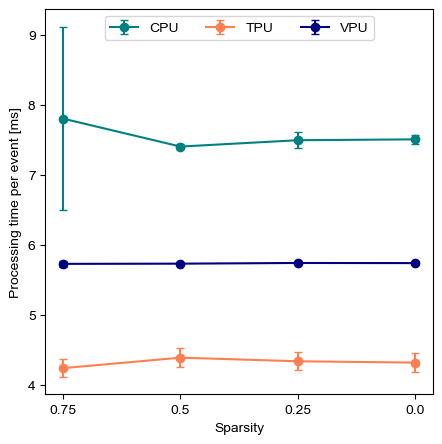

In [9]:
plt.rcParams.update({'font.sans-serif':'Arial'})

sparsity_data = {'sparsities': ['0.75', '0.5', '0.25', '0.0']}

sparsity_data['cpu_tf_data'] = [ pd.read_csv("pid_sparse_test/output_files_tpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['tpu_data'] = [ pd.read_csv("pid_sparse_test/output_files_tpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['cpu_ov_data'] = [ pd.read_csv("pid_sparse_test/output_files_vpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['vpu_data'] = [ pd.read_csv("pid_sparse_test/output_files_vpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]

# sparsity_data['operations'] = [int(pd.read_csv("pid_sparse_test/vpu_models/pid_sparsity_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in sparsity_data['sparsities']]

sparsity_error_data = {'sparsities': ['0.75', '0.5', '0.25', '0.0']}

sparsity_error_data['cpu_tf_data'] = [ pd.read_csv("pid_sparse_test/output_files_tpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['tpu_data'] = [ pd.read_csv("pid_sparse_test/output_files_tpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['cpu_ov_data'] = [ pd.read_csv("pid_sparse_test/output_files_vpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['vpu_data'] = [ pd.read_csv("pid_sparse_test/output_files_vpu/pid_sparsity_" + str(size) + "/pid_sparsity_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]

# sparsity_error_data['operations'] = [ int(pd.read_csv("pid_sparse_test/vpu_models/pid_sparsity_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in sparsity_data['sparsities']]

fig, ax = plt.subplots(1,1, figsize=(5,5))

x_values = [ str(size) for size in sparsity_data['sparsities'] ]

fig.suptitle('')

ax.errorbar(np.arange(len(x_values)), sparsity_data['cpu_ov_data'], yerr = sparsity_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), sparsity_data['tpu_data'], yerr = sparsity_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), sparsity_data['vpu_data'], yerr = sparsity_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=3)

ax.set_xticks(np.arange(len(x_values)), x_values)
ax.set_xlabel('Sparsity')
ax.set_ylabel('Processing time per event [ms]')
ax.legend(loc="upper center", ncol=4)

print("Processing time mean CPU :" + str(np.mean(sparsity_data['cpu_ov_data'])))
print("Processing time mean TPU :" + str(np.mean(sparsity_data['tpu_data'])))
print("Processing time mean VPU :" + str(np.mean(sparsity_data['vpu_data'])))

fig.savefig("graphs/pid_sparsity.pdf")

vgg16 sparsity

Processing time mean CPU :18.440010660886724
Processing time mean TPU :15.924101763963652
Processing time mean VPU :9.129395967721873


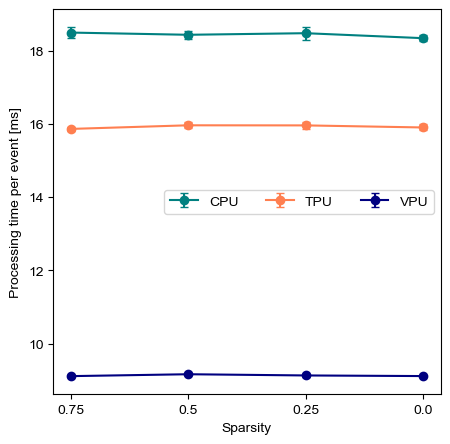

In [10]:
plt.rcParams.update({'font.sans-serif':'Arial'})

sparsity_data = {'sparsities': ['0.75', '0.5', '0.25', '0.0']}

sparsity_data['cpu_tf_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_tpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['tpu_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_tpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_tpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['cpu_ov_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_vpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_cpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_data['vpu_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_vpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_vpu_mean'][0]*1e3 for size in sparsity_data['sparsities']]

# sparsity_data['operations'] = [int(pd.read_csv("pid_sparse_test/vpu_models/pid_sparsity_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in sparsity_data['sparsities']]

sparsity_error_data = {'sparsities': ['0.75', '0.5', '0.25', '0.0']}

sparsity_error_data['cpu_tf_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_tpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['tpu_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_tpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_tpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['cpu_ov_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_vpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_cpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]
sparsity_error_data['vpu_data'] = [ pd.read_csv("vgg16_sparse_test/output_files_vpu/vgg16_sparsity_" + str(size) + "/vgg16_sparsity_" + str(size) + ".csv")['latency_vpu_stdev'][0]*1e3 for size in sparsity_data['sparsities']]

# sparsity_error_data['operations'] = [ int(pd.read_csv("pid_sparse_test/vpu_models/pid_sparsity_" + str(size) + "/op_stat.csv")['flops'].sum()) for size in sparsity_data['sparsities']]

fig, ax = plt.subplots(1,1, figsize=(5,5))

x_values = [ str(size) for size in sparsity_data['sparsities'] ]

fig.suptitle('')

ax.errorbar(np.arange(len(x_values)), sparsity_data['cpu_ov_data'], yerr = sparsity_error_data['cpu_ov_data'], label='CPU', color='teal', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), sparsity_data['tpu_data'], yerr = sparsity_error_data['tpu_data'], label='TPU', color='coral', fmt='-o', capsize=3)
ax.errorbar(np.arange(len(x_values)), sparsity_data['vpu_data'], yerr = sparsity_error_data['vpu_data'], label='VPU', color='navy', fmt='-o', capsize=3)

ax.set_xticks(np.arange(len(x_values)), x_values)
ax.set_xlabel('Sparsity')
ax.set_ylabel('Processing time per event [ms]')
ax.legend(loc="right", ncol=4)

print("Processing time mean CPU :" + str(np.mean(sparsity_data['cpu_ov_data'])))
print("Processing time mean TPU :" + str(np.mean(sparsity_data['tpu_data'])))
print("Processing time mean VPU :" + str(np.mean(sparsity_data['vpu_data'])))

fig.savefig("graphs/vgg16_sparsity.pdf")

## 11. Benchmarks

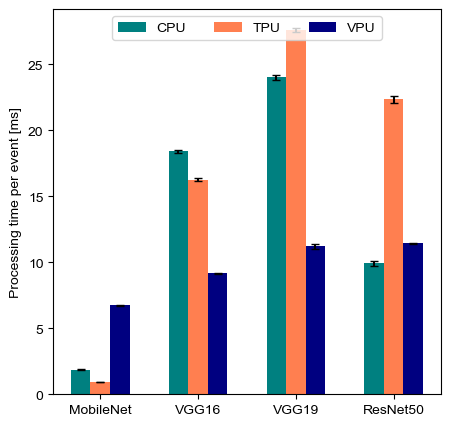

In [50]:
plt.rcParams.update({'font.sans-serif':'Arial'})

bench_data = {'benchmarks': ['MobileNet', 'VGG16', 'VGG19', 'ResNet50']}

bench_data['cpu_tf_data'] = [ pd.read_csv("keras_apps/output_files_tpu/" + bench + "/" + bench + ".csv")['latency_cpu_mean'][0]*1e3 for bench in bench_data['benchmarks']]
bench_data['tpu_data'] = [ pd.read_csv("keras_apps/output_files_tpu/" + bench + "/" + bench + ".csv")['latency_tpu_mean'][0]*1e3 for bench in bench_data['benchmarks']]
bench_data['cpu_ov_data'] = [ pd.read_csv("keras_apps/output_files_vpu/" + bench + "/" + bench + ".csv")['latency_cpu_mean'][0]*1e3 for bench in bench_data['benchmarks']]
bench_data['vpu_data'] = [ pd.read_csv("keras_apps/output_files_vpu/" + bench + "/" + bench + ".csv")['latency_vpu_mean'][0]*1e3 for bench in bench_data['benchmarks']]

bench_data['operations'] = [int(pd.read_csv("keras_apps/vpu_models/" + bench + "/op_stat.csv")['flops'].sum()) for bench in bench_data['benchmarks']]

bench_error_data = {'benchmarks': ['MobileNet', 'VGG16', 'VGG19', 'ResNet50']}

bench_error_data['cpu_tf_data'] = [ pd.read_csv("keras_apps/output_files_tpu/" + bench + "/" + bench + ".csv")['latency_cpu_stdev'][0]*1e3 for bench in bench_data['benchmarks']]
bench_error_data['tpu_data'] = [ pd.read_csv("keras_apps/output_files_tpu/" + bench + "/" + bench + ".csv")['latency_tpu_stdev'][0]*1e3 for bench in bench_data['benchmarks']]
bench_error_data['cpu_ov_data'] = [ pd.read_csv("keras_apps/output_files_vpu/" + bench + "/" + bench + ".csv")['latency_cpu_stdev'][0]*1e3 for bench in bench_data['benchmarks']]
bench_error_data['vpu_data'] = [ pd.read_csv("keras_apps/output_files_vpu/" + bench + "/" + bench + ".csv")['latency_vpu_stdev'][0]*1e3 for bench in bench_data['benchmarks']]

bench_error_data['operations'] = [ int(pd.read_csv("keras_apps/vpu_models/" + bench + "/op_stat.csv")['flops'].sum()) for bench in bench_data['benchmarks']]

fig, ax = plt.subplots(1,1, figsize=(5,5))

x_values = [ bench for bench in bench_data['benchmarks'] ]

fig.suptitle('')

ax.bar(np.arange(len(x_values)) - 0.2, bench_data['cpu_ov_data'], yerr = bench_error_data['cpu_ov_data'], label='CPU', color='teal', capsize=3, width=0.2)
ax.bar(np.arange(len(x_values)), bench_data['tpu_data'], yerr = bench_error_data['tpu_data'], label='TPU', color='coral', capsize=3, width=0.2)
ax.bar(np.arange(len(x_values)) + 0.2, bench_data['vpu_data'], yerr = bench_error_data['vpu_data'], label='VPU', color='navy', capsize=3, width=0.2)

ax.set_xticks(np.arange(len(x_values)), x_values)
# ax.set_xlabel(x_values)
ax.set_ylabel('Processing time per event [ms]')
ax.legend(loc="upper center", ncol=4)

fig.savefig("graphs/common_benchmarks.pdf")

In [35]:
bench_data['tpu_data'], bench_error_data['tpu_data']

([0.9497542214393, 16.2637672424316, 27.626660823822, 22.337838888168303],
 [0.01811116260121081, 0.1184051380412, 0.1557855607064, 0.23235259021420002])

In [36]:
bench_data['vpu_data'], bench_error_data['vpu_data']

([6.731128501892, 9.1633961439132, 11.2115668773651, 11.4434136390686],
 [0.023660203227220424,
  0.03018181816260614,
  0.17674377259489998,
  0.04296668756116123])

In [37]:
bench_data['cpu_ov_data'], bench_error_data['cpu_ov_data']

([1.8730885267256998, 18.4028675079345, 24.0142870426177, 9.929081559181201],
 [0.027781109512527113, 0.08385571269864152, 0.208065506191, 0.1793727867953])

## Conclusion (?)

VPU is better at convolutions with small kernel sizes, but only slightly. For Pooling and Feed Forward Dense Operations, TPU win.

That is why the gap between the TPU and the VPU in the Angle Model (which has less convolutions and more dense feed forward layers) is larger.


According to a Paper, the SHAVEs of the VPU have more of a RISC architecture.